# Global Clustering

This is the notebook for global clustering and evaluation.

In [1]:
import mongoengine
from mongoengine import *
from mongoengine.queryset.visitor import Q
from dbmodels import *

import numpy as np
import pandas as pd
from bson.objectid import ObjectId
import configparser
from multiprocessing import Pool
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seaborn as sns
sns.set('notebook')

In [3]:
# Read the confidentials.
credentials = configparser.ConfigParser()
credentials.read('credentials.ini')

# Connect to the database.
connect(
    db = credentials.get('lb', 'db'),
    username = credentials.get('lb', 'username'),
    password = credentials.get('lb', 'password'),
    host = credentials.get('lb', 'host'), 
    port = int(credentials.get('lb', 'port')), 
);

---

# Get Training Samples

In [4]:
import itertools

In [5]:
dis_ref = Disambiguation.objects(type="reference_disambiguation", book__exists=True)

In [6]:
books = [b.id for b in dis_ref.distinct('book')]

In [8]:
book_ref = dict()
for b in books:
    dis = Disambiguation.objects(type="reference_disambiguation", book=b)
    refs = [d.reference.id for d in dis]
    book_ref[b] = refs

/Users/suntao/anaconda3/envs/lb/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: generator 'QuerySet._iter_results' raised StopIteration


In [20]:
pd.Series(book_ref).to_pickle("book_ref.pkl")

In [21]:
print(len(book_ref))

81525


### Positive Example

In [22]:
positive = []
for b in book_ref:
    refs = book_ref[b]
    pair_list = [(refs[i], refs[j]) for i in range(len(refs)) for j in range(i+1, len(refs))]
    positive.extend(pair_list)

In [23]:
pd.Series(positive).to_pickle('positive.pkl')

In [24]:
print(len(positive))

2016276


### Negative Example
Random choose 1000 x 2 books

In [30]:
book_index = np.arange(len(books))
np.random.shuffle(book_index)

index1 = book_index[:1000]
index2 = book_index[-1000:]

In [31]:
negative = []
for i in index1:
    for j in index2:
        negative.extend(list(itertools.product(book_ref[books[i]], book_ref[books[j]])))

In [32]:
pd.Series(negative).to_pickle('negative.pkl')

In [33]:
print(len(negative))

5635899


---

In [4]:
book_ref = pd.read_pickle('book_ref.pkl').to_dict()
positive = pd.read_pickle('positive.pkl').values
negative = pd.read_pickle('negative.pkl').values

---

# Build Similarity Vector

In [666]:
from SimilarityCalculation import *

In [6]:
def getRefInfo(rid):
    ref = Reference.objects(id=rid).first()
    d = dict()
    d['rid'] = rid
    d['surface'] = ref.reference_string
    for i, c in ref.contents.items():
        tag = c['tag']
        if tag in ['title', 'author', 'year', 'publisher']:
#             d[tag] = c['surface']
            if tag in d:
                d[tag].append(c['surface'])
            else:
                d[tag] = [c['surface']]
    return d

In [ ]:
all_ref = dict()

for i, p in enumerate(positive):
    if p[0] not in all_ref:
        all_ref[p[0]] = getRefInfo(p[0])
    if p[1] not in all_ref:
        all_ref[p[1]] = getRefInfo(p[1])
    if i % 10000 == 0:
        print(i)

# for i, p in enumerate(negative):
#     if p[0] not in all_ref:
#         all_ref[p[0]] = getRefInfo(p[0])
#     if p[1] not in all_ref:
#         all_ref[p[1]] = getRefInfo(p[1])
#     if i % 10000 == 0:
#         print(i)

In [23]:
p_list = [p for pp in positive for p in pp ]

In [24]:
n_list = [n for nn in negative for n in nn ]

In [31]:
for i, r in enumerate(set(n_list)-set(p_list)):
    all_ref[r] = getRefInfo(r)

In [32]:
pd.Series(all_ref).to_pickle('all_ref_for_global_train.pkl')

In [10]:
all_ref = pd.read_pickle('all_ref_for_global_train.pkl')

### Sample

**Positive**

In [663]:
positive_sample = np.random.choice(positive, 10000)
pd.Series(positive_sample).to_pickle('positive_sample.pkl')

In [678]:
positive_vector = [featureVectorBuilder(all_ref[p[0]], all_ref[p[1]]) for p in positive_sample]

In [679]:
print(len(positive_vector))

10000


In [680]:
pd.DataFrame(positive_vector).to_pickle('positive_vector_sample.pkl')

In [13]:
positive_sample = pd.read_pickle('positive_sample.pkl').values
positive_vector = pd.read_pickle('positive_vector_sample.pkl').values

In [64]:
# manually check
# choose_index = np.random.choice(list(range(10000)), 150)
positive_choose_index = [6257, 4915, 7519, 1138, 7596, 4928, 5130, 913 , 7947, 9772,
                         3394, 2643, 6705, 8198, 5865, 995 , 9079, 1669, 8452, 1905,
                         4407, 6302, 6351, 9952, 8394, 3577, 5210, 6642, 1092, 7405,
                         8556, 5552, 3880, 9630, 4730, 8938, 2714, 2155, 8449, 2315,
                         4991, 6058, 1904, 393 , 5146, 951 , 3366, 3295, 8398, 9485]

In [61]:
# choose_index = np.random.choice(list(range(10000)), 150)
# for i in choose_index:
#     r1, r2 = positive_sample[i]
#     print('-'*10)
#     print(i)
#     print(Reference.objects(id=r1).first().reference_string)
#     print(Reference.objects(id=r2).first().reference_string)

In [65]:
positive_vector_sample = positive_vector[positive_choose_index]

**Negative**

In [16]:
negative_sample = np.random.choice(negative, 30000)
pd.Series(negative_sample).to_pickle('negative_sample.pkl')

In [33]:
negative_vector = [featureVectorBuilder(all_ref[p[0]], all_ref[p[1]]) for p in negative_sample]

In [34]:
print(len(negative_vector))

30000


In [35]:
pd.DataFrame(negative_vector).to_pickle('negative_vector_sample.pkl')

In [81]:
negative_vector = pd.read_pickle('negative_vector_sample.pkl').values

In [69]:
# manually check
negative_choose_index = [ 114,  152,  332,  360,  394,  500,  571,  586,  608,  667,
                          724, 2088, 2096, 2110, 2147, 2275, 2469, 2573, 2587, 2595,
                         3417, 3426, 3441, 3565, 3579, 3638, 3687, 3707, 3799, 3845,
                         6724, 6756, 7048, 7139, 7166, 7734, 7743, 8110, 8211, 8367,
                            0,    1,    2,    3,    4,    5,    6,    7,    8,    9]

In [83]:
negative_vector_sample = negative_vector[negative_choose_index]

**Combined**

In [491]:
X = np.concatenate([pd.DataFrame(positive_vector).values, pd.DataFrame(negative_vector[:10000]).values])

In [492]:
choose_index = positive_choose_index + [i+10000 for i in negative_choose_index]

In [493]:
X_train = np.concatenate([pd.DataFrame(positive_vector_sample).values, pd.DataFrame(negative_vector_sample).values])
y_train = np.concatenate([np.ones(50), np.zeros(50)])

### Semi-supervised Learning

**Logistic Regression**

In [546]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [547]:
new_index = []
y_new = []
for i, x in enumerate(X):
    if i not in choose_index:
        pro = np.max(lr.predict_proba(X[[i]]))
        if pro >= 0.9: # set a threshold
            new_index.append(i)
            # record the label predicted by the model
            label = lr.predict(X[[i]])[0]
            y_new.append(label)

In [548]:
X_train_new = X[choose_index+new_index]
y_train_new = np.concatenate([y_train, np.array(y_new)])

pd.Series(y_train_new).value_counts()

0.0    9695
1.0    6605
dtype: int64

In [549]:
# Balance positive/negative points
# Select 6000 positive and 6000 negative for training 
ne_index = np.random.choice(np.where(y_train_new==0)[0], 6000)
po_index = np.random.choice(np.where(y_train_new==1)[0], 6000)

balance_index = np.concatenate([po_index, ne_index])

In [550]:
X_train_new_balance = X_train_new[balance_index]
y_train_new_balance = y_train_new[balance_index]

Retrain on everything

In [551]:
lr = LogisticRegression()
lr.fit(X_train_new_balance, y_train_new_balance)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

**SVC**

In [ ]:
# from sklearn.svm import SVC
# svc = SVC()
# svc.fit(X_train, y_train)

# new_index = []
# y_new = []
# for i, x in enumerate(X):
#     if i not in choose_index:
#         pro = np.max(lr.predict_proba(X[[i]]))
#         if pro >= 0.9: # set a threshold
#             new_index.append(i)
#             # record the label predicted by the model
#             label = lr.predict(X[[i]])[0]
#             y_new.append(label)

# X_train_new = X[choose_index+new_index]
# y_train_new = np.concatenate([y_train, np.array(y_new)])

# ne_index = np.random.choice(np.where(y_train_new==0)[0], 6000)
# po_index = np.random.choice(np.where(y_train_new==1)[0], 6000)

# balance_index = np.concatenate([po_index, ne_index])

# X_train_new_balance = X_train_new[balance_index]
# y_train_new_balance = y_train_new[balance_index]

# svc = SVC()
# svc.fit(X_train_new_balance, y_train_new_balance)

### Read ground truth

In [113]:
file_path = './hash_ground_truth/'
list_df_10 = pd.read_excel(file_path+'hashing groundtruth (1-10).xlsx', sheet_name=list(range(0,10)))
list_df_100 = pd.read_excel(file_path+'hashing groundtruth (10-100).xlsx', sheet_name=list(range(0,10)))
list_df_500 = pd.read_excel(file_path+'hashing groundtruth (100-500).xlsx', sheet_name=list(range(0,10)))

In [114]:
df_list = []
for list_df in [list_df_10, list_df_100, list_df_500]:
    for i, df in enumerate(list_df.values()):
        df = df[['seed_ref_id','ref_id',True]]
        df = df.fillna(method='ffill')
        df_list.append(df)

In [115]:
df_test = pd.concat(df_list)
df_test.head()

seed_ref_id                    ref_id  True
0  58e4ce00fe7683152b573df6  59de7a2148e232540c5eeaad   0.0
1  58e4ce00fe7683152b573df6  58e4ce01fe7683152b59d220   1.0
0  58e4ce01fe7683152b58679b  59e332f68831617f5edf0185   1.0
1  58e4ce01fe7683152b58679b  59e332f68831617f5edf025e   1.0
0  58e4ce00fe7683152b55f12d  59e333088831617f5ee8442b   0.0

In [118]:
# Get all information of each reference
ref_test = list(set(df_test.seed_ref_id.values) | set(df_test.ref_id.values))

ref_test_info = dict()

for r in ref_test:
    ref_test_info[r] = getRefInfo(r)

pd.Series(ref_test_info).to_pickle('./global_eval/ref_info_for_global_eval.pkl')

In [120]:
ref_test_info = pd.read_pickle('./global_eval/ref_info_for_global_eval.pkl')

In [121]:
def calculate_fv(df):
    seed = df.seed_ref_id
    match = df.ref_id
    return featureVectorBuilder(ref_test_info[seed], ref_test_info[match])

In [122]:
# Calculate the feature vector
df_test['fv'] = df_test.apply(calculate_fv, axis=1)

In [123]:
# From dict to array
df_test['X'] = df_test['fv'].apply(lambda x: [i for i in x.values()])

In [458]:
# Treat 0.5 as 1
df_test[True] = (df_test[True]>0).astype(int)

In [459]:
df_test[True].value_counts()

0    2890
1     752
Name: True, dtype: int64

In [460]:
df_test.head()

seed_ref_id                    ref_id  True  \
0  58e4ce00fe7683152b573df6  59de7a2148e232540c5eeaad     0   
1  58e4ce00fe7683152b573df6  58e4ce01fe7683152b59d220     1   
2  58e4ce01fe7683152b58679b  59e332f68831617f5edf0185     1   
3  58e4ce01fe7683152b58679b  59e332f68831617f5edf025e     1   
4  58e4ce00fe7683152b55f12d  59e333088831617f5ee8442b     0   

                                                  fv  \
0  {'authorBigram': 0.0, 'authorToken': 1.0, 'tit...   
1  {'authorBigram': 0.0, 'authorToken': 1.0, 'tit...   
2  {'authorBigram': 0.0, 'authorToken': 1.0, 'tit...   
3  {'authorBigram': 0.0, 'authorToken': 0.0, 'tit...   
4  {'authorBigram': 0.0, 'authorToken': 0.0, 'tit...   

                                             X  
0                 [0.0, 1.0, 0.0, 0.0, 0, 0.0]  
1                 [0.0, 1.0, 1.0, 1.0, 0, 1.0]  
2                 [0.0, 1.0, 1.0, 1.0, 0, 1.0]  
3  [0.0, 0.0, 0.0, 0.6666666666666666, 0, 1.0]  
4  [0.0, 0.0, 0.0, 0.3076923076923077, 0, 0.0]

In [461]:
df_test = df_test.set_index('seed_ref_id').reset_index()

In [462]:
df_test.to_pickle('./global_eval/df_test.pkl')

### Evaluate the classifier

In [463]:
df_test = pd.read_pickle('./global_eval/df_test.pkl')

In [464]:
from sklearn import metrics
def print_report(clf, X, y):
    y_pred = clf.predict(X)
    report = metrics.classification_report(y, y_pred)
    print(report)
    print("accuracy: {:0.3f}".format(metrics.accuracy_score(y, y_pred)))

In [552]:
X_test = df_test['X'].apply(pd.Series).values
y_test = np.array([int(i) for i in df_test[True].values])

In [553]:
print_report(lr, X_test, y_test)

             precision    recall  f1-score   support

          0       0.98      0.65      0.78      2890
          1       0.41      0.96      0.58       752

avg / total       0.87      0.71      0.74      3642

accuracy: 0.711


Report on every samples.

In [ ]:
for ref in set(df_test.seed_ref_id.values):
    X_s = df_test[df_test.seed_ref_id==ref]['X'].apply(pd.Series).values
    y_s = np.array([int(i) for i in df_test[df_test.seed_ref_id==ref][True].values])
    print('-'*55)
    print(ref, len(X_s))
    print_report(lr, X_s, y_s)
    print('-'*55)

### Eli5

In [437]:
import eli5

In [438]:
features=['authorBigram', 'authorToken', 'titleTrigram', 'titleToken', 'publisherLCS', 'yearMatch']

In [554]:
eli5.show_weights(lr, feature_names=features)

In [581]:
df_feature = eli5.format_as_dataframe(eli5.explain_weights(lr, feature_names=features))[['feature','weight']].set_index('feature')

/Users/suntao/anaconda3/envs/lb/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


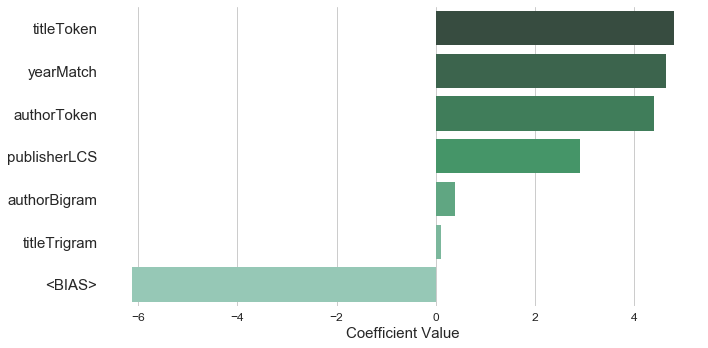

In [655]:
import seaborn as sns
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

sns.set(style="whitegrid")
sns.set_color_codes("muted")
plt.figure(figsize=(10,5))
# plt.tight_layout()
sns.barplot(y=df_feature.index, x=df_feature.weight, palette="BuGn_d",)
plt.grid(axis='y', b=False)
plt.xlabel('Coefficient Value', fontsize=15)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
sns.despine(bottom=True, left=True)
plt.savefig('coef.png');

**False Negative**

In [657]:
fn = np.where((lr.predict(X_test)==0) & (y_test==1))[0]
fp = np.where((lr.predict(X_test)==1) & (y_test==0))[0]

In [658]:
len(fn), len(fp)

(33, 1020)

What's the False Negative?

In [661]:
from IPython.display import display
for i in fn:
    seed = df_test.iloc[i].seed_ref_id
    ref = df_test.iloc[i].ref_id
    print('-'*5+str(i)+'-'*5)
    print_contents(Reference.objects(id=seed).first().contents)
    print()
    print_contents(Reference.objects(id=ref).first().contents)
    print()
    print(df_test.iloc[i].X)
    print()
    display(eli5.show_prediction(lr, X_test[i], feature_names=features))

-----45-----
author: M. Valerii
title: Probi in Virgilii Bucolica et Georgica Commentarius. Accedunt Scho- liorum Veronensium, et Aspri quaestionum Virgilianarum fragmen- ta,
publicationplace: Halis
year: , 1848,

title: Augustus indignatus veteranis ... agros Cremonensium dividi iussit et si non suffecissent, Mantuanos adiungi ...” (Probo, In Vergilii Bucolica et Georgica Commentarius,
author: ed. H. Keil,
publicationplace: Halle
year: 1848,
pagination: p. 5). E.

[0.0, 0.0, 0.08333333333333333, 0.21428571428571427, 0, 1.0]



-----46-----
author: M. Valerii
title: Probi in Virgilii Bucolica et Georgica Commentarius. Accedunt Scho- liorum Veronensium, et Aspri quaestionum Virgilianarum fragmen- ta,
publicationplace: Halis
year: , 1848,

author: E. Keil, M. Valerti
title: Probi in Vergilii Bucolica et Georgica commentarius,
pagination: p. 1-68).

[0.0, 0.0, 0.14285714285714285, 0.4444444444444444, 0, 0]



-----81-----
title: Chronicon Marchia e Tarvisinae et Lombardiae,
author: a cura di L. A. Botteghi
conjunction: in
title: RR. IL SS.,
publicationplace: Città di Castello,
year: 1916,
tomo: T. Vili,
pagination: P. Ili, p. 51.

title: Chronicon marchiae Tarvisinae et Lombardiae,
author: ed. L. A. Botteghi, in R.I.S.2, VIII, iii, 3, for another relevant passage and to Antonio Godi,
title: Cronaca,
publisher: ed. Giovanni Soranzo,
year: in R.I.S.2,
numbered_ref: VIII, ii, 3.

[0.0, 0.2, 0.0, 0.75, 0, 0]



-----88-----
title: Chronicon Marchia e Tarvisinae et Lombardiae,
author: a cura di L. A. Botteghi
conjunction: in
title: RR. IL SS.,
publicationplace: Città di Castello,
year: 1916,
tomo: T. Vili,
pagination: P. Ili, p. 51.

title: Chronicon Marchiae Tarvisinae et Lombardiae, R.I.S.,
tomo: t. VIII, 3,
pagination: p. 5, 16-21.

[0, 0, 0.0, 0.75, 0, 0]



-----89-----
title: Chronicon Marchia e Tarvisinae et Lombardiae,
author: a cura di L. A. Botteghi
conjunction: in
title: RR. IL SS.,
publicationplace: Città di Castello,
year: 1916,
tomo: T. Vili,
pagination: P. Ili, p. 51.

title: Tiratilo, e parigino, de Tiratilo, del chronicon Marchiae Tarvisinae et Lombardiae (Rerum it. script.,
publicationspecifications: IIa ed., VIII/3)

[0, 0, 0.0, 0.46153846153846156, 0, 0]



-----218-----
author: Yitt. Lazzarini,
title: Antiche leggi venete intorno a proprietari nella, terraferma in N. A. Yen.,
numbered_ref: n. s.
year: 1920
volume: vol. XXXVIII,
pagination: pp. 5-31

author: Lazzarini, Vittorio:
title: Antiche leggi venete intorno a proprietari nella terraferma, N. Arch. Ven. ser. II,
publicationspecifications: anno XXI,
publicationnumber-year: vol. XXXVIII,
pagination: 1920, 5-31

[0.0, 0.5, 0.6666666666666666, 0.75, 0, 0]



-----1396-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: DELLA PIETÀ,
title: N. 3651 Una lapide posta sulla facciata di un edificio in fondo alla calle, ricorda il luogo di residenza dello scultore Alessandro Vittoria che vi morì nel 1608. Alcune testimonianze letterarie ed iconografiche documentano la presenza del suo giardino, ora scomparso e occupato da un edificio in parte già presente nel Catasto Napoleonico, attualmente adibito ad albergo. -F. SANSOVINO, 1581, p. 137 -G.
author: TASSINI,
year: 1863,
pagination: pp. 124-125 -G.
author: DAMERINI,
year: 193I,
pagination: pp. 65-66 -G.

[0.0, 0.0, 0.0, 0.0, 0, 0.0]



-----1535-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: CAPITOLO PRIMO
title: La chiesa venne distrutta nel 1831, dopo la cessione dell’ospedale alle autorità militari, ma è possibile ricostruirne l’aspetto grazie ai rilievi eseguiti prima dell’abbattimento dall’architetto Francesco Wcowich-Lazzari (figg. 1.12, 1.13).4 L’edificio, che si collocava all’interno di un cortile rettangolare delimitato dalle quattro ali dell’ospedale, era caratterizzato da una pianta mistilinea rettangolare con i lati brevi semicircolari. Il presbiterio, posto di fronte all’ingresso e sopraelevato su una breve rampa, era collegato al corpo posteriore del complesso, mentre il resto della chiesa era completamente separato dal colonnato del cortile. Presentava otto alte finestre a tutto sesto e quattro altari laterali, e lungo l’intero perimetro correva una cornice continua, al di sopra della quale si aprivano delle piccole finestre ova

-----1706-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: di Siena, Ferrara e Urbino. LA CAPPELLA DELLA SANTA CASA DI LORETO
title: La devozione di Venezia alla Vergine ha radici molto lontane. È nota la tradizione che vuole Venezia fondata nel giorno dell’Annunciazione (25 marzo) del 421, riportata da tutte le antiche cronache e con ricchezza di particolari (Francesco Sansovino, 1581). La città veniva associata a Maria anche per l’analogia tra l’inviolabilità della Vergine e la storica invincibilità di Venezia. Ancora nella prima metà del Settecento «per quanto le guerre avessero svuotato le casse della Repubblica e le fossero costate tutti i pregiati possedimenti del Mediterraneo orientale, Venezia era riuscita a mantenere la sua millenaria indipendenza»
publicationplace: (Barcham,
year: 1993).

[0.0, 0.0, 0.0, 0.03571428571428571, 0, 0.0]



-----1774-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: F. Sansovino,
title: Venetia città nobilissima et singulare..., Venezia, Jacomo Sansovino, 1581. Id,, Venetia, città nobilissima (con le aggiunte di
author: G. Martinioni),
publicationplace: Venezia
year: 1663.

[0.0, 1.0, 0.15384615384615385, 0.35294117647058826, 0, 0.0]



-----1790-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: T. Bergamo Rossi
title: Venezia, chiesa di Santo Stefano, sacrestia Nella chiesa di Santo Stefano «si vede anco una figuretta di marmo sopra una pila, fatta l’anno 1503, dal Mosca scultore assai stimato»: tali parole di Sansovino (1581), riportate nelle antiche guide della città, diedero adito a equivoci. Infatti in chiesa vi erano due pile per l’acqua santa, entrambe sormontate da una statuetta marmorea (Moschini,
year: 1815): una

[0.0, 0.0, 0.0, 0.0425531914893617, 0, 0.0]



-----1840-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

: 120 PROCESSIONI ANNUALI IN RINGRAZIAMENTO subito dopo oggetto di culto popolare per fatti miracolosi (in vita e in morte) a lei attribuiti, mai proclamata beata da alcun pontefice22, anche se tale considerata dallo Stato e dal popolo veneziano. Il culto per Contessa Tagliapietra si intrecciò costantemente col
title: motivo della rievocazione storica della sventata congiura di Baia-monte Tiepolo. Annota il Sansovino (1581) nella sua sommaria descrizione del l’andata dogale: San Vito [...] nobilitata prima per lo corpo della beata Contessa Tagliapietra et poi per l’andata del Principe che la visita ogni anno23. Il corpo di Contessa, deposto in un’arca di cipresso, «con grata di ferro e cristalli», sotto l’altare di San Giovanni Evangelista, veniva esposto, sopra la mensa, nel dies natalis di questo santo e per la visita dogale. In quest’ultima occasione «i genitor

-----2349-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Chastel, André. “Art et humanisme au Quattrocento.”
conjunction: In
title: UEUV,
pagination: pp. 395-405.

[0, 0, 0.5, 0.75, 0, 0]



-----2784-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

abbreviation: Id.,
title: Expansion, crises et déclin des salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Mostra Storica della laguna veneta,
publicationplace: Venezia
year: 1979,
pagination: pp. 87-99.

[0, 0, 0.9090909090909091, 0.9333333333333333, 0, 0.0]



-----2786-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

abbreviation: Id.,
title: « Expansion, crises et déclin des salines dans la lagune de Venise au Moyen Age », in Catalogo della mostra storica della laguna veneta, Venise, 1970, repris dans Chioggia, capitale del sale nel Medioevo,
publicationplace: Chioggia,
year: 1991.

[0, 0, 0.45454545454545453, 0.5384615384615384, 0, 0.0]



-----2789-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Jean-Claude Hocquet,
title: Expansion, crises et déclin des salines dans la lagune de Venise au Moyen Age, nel catalogo Mostra storica della laguna veneta, Venezia 1970,
pagination: pp. 90-91 (pp. 87-99)

[0.0, 0.4, 0.5555555555555556, 0.6363636363636364, 0, 0]



-----2805-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro Paoletti,
title: Raccolta di documenti inediti per servire alla storia della pittura veneziana
publicationplace: (Padua,
year: 1895),
folder: fase. 11,
numbered_ref: n. 20).

[0.0, 0.6666666666666666, 0.0, 0.0, 0, 0.0]



-----3023-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: Raccolta di documenti inediti per servire alla storia della pittura veneziana nei secoli XV-XVI,
publicationplace: II, Padova
year: 1895,
pagination: p. 14,
numbered_ref: nota 1, pubblica il contratto del
title: 13 giugno 1422 con i maestri modenesi Alberto e Arduino da Baisio e il ferrarese Giovanni de Trigoli.

[0.0, 1.0, 0.0, 0.0, 0, 0.0]



-----3243-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: Lorenzetti,
title: Venezia e il suo estuario. Guida storico-artistica, Roma 1926
publicationspecifications: [nuova ed.
publicationplace: Roma
year: 1956;

[0.0, 0.0, 0.0, 0.4444444444444444, 0, 0.0]



-----3385-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: G. Dominici,
title: Regola del governo di cura familiare, Florence, 1860, the editor reproduces the first page of this manuscript, opposite p. clx. 30G. Lorenzetti, who was very well informed about Venice, reports in Venezia e il suo estuario,
publicationplace: Rome,
year: 1926,
pagination: p. 743,

[0.0, 0.0, 0.0, 0.17391304347826086, 0, 1.0]



-----3388-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: d’Agnoldomeni-co Pica. Giulio Lorenzetti,
title: Venezia e il suo estuario. Guida storico-artistica corredata di una grande pianta della città, di 22 piantine di itinerari, di 60 illustrazioni nel testo e 96 tavole fuori testo, Bestetti & Tumminelli, Venezia 1926. André De
author: Hevesy,
title: Jacopo De Barbari le maître au caducée, Van Oest,
publicationplace: Paris
year: 1925.

[0.0, 0.0, 0.0, 0.15384615384615385, 0, 0.0]



-----3472-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: Giulio Lorenzetti,
title: Venezia e il suo estuario, Roma 1926,
publicationplace: Trieste
year: 1979,
pagination: pp. 388-92;

[0.0, 0.0, 0.0, 0.6666666666666666, 0, 0.0]



-----3629-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

: 1926 Venezia e il suo estuario,
publicationplace: Venezia.

[0, 0, 0, 0, 0, 0]



-----3630-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: 1926LORENZETTI G.,
title: Venezia e il suo estuario, Venezia -
publicationplace: Milano.

[0.0, 0.0, 0.0, 0.8, 0, 0]



-----3631-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: Lorenzetti
title: ( Venezia e il suo estuario, Venezia, 1926,
pagination: p. 634),

[0.0, 0.0, 0.0, 0.6666666666666666, 0, 0]



-----3632-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

: 1926
author: G. Lorenzetti,
title: Venezia e il suo estuario,
publicationplace: Milano-Venezia.

[0.0, 0.0, 0.0, 1.0, 0, 0]



-----3634-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: Lorenzetti,
title: Venezia e il suo estuario, Roma 192G, |). 228 VI.

[0.0, 0.0, 0.0, 0.5714285714285714, 0, 0]



-----3635-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: G. Lorenzetti,
title: Venezia e il suo estuario, Roma 1926.

[0.0, 0.0, 0.0, 0.6666666666666666, 0, 0]



-----3636-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: G. LORENZETTI
title: Venezia e il suo estuario Roma [1926].

[0.0, 0.0, 0.0, 0.6666666666666666, 0, 0]



-----3637-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: Giulio Lorenzetti,
title: Venezia e il suo estuario, 1st
author: ed.,
title: Venice et al.,
publicationnumber-year: 1926,
pagination: p. 561;

[0.0, 0.0, 0.0, 0.8, 0, 0]



-----3639-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: G. LORENZETTI,
title: Venezia e il suo estuario, Venezia 1926,
pagination: pag. 824.

[0.0, 0.0, 0.0, 0.6666666666666666, 0, 0]



-----3640-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: LORENZETTI G.
year: 1926, Venezia e il suo estuario,
: Venezia-Firenze-Roma.

[0.0, 0.0, 0, 0, 0, 1.0]



-----3641-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: LORENZETTI,
title: Venezia e il suo estuario. Guida storico-artistica, Bestetti & Tumminelli, Venezia 1926,
pagination: p. 764.

[0.0, 0.0, 0.0, 0.36363636363636365, 0, 0]



In [663]:
Reference.objects(id="58e4ce01fe7683152b58fc5d").first().reference_string

'G. Lo- RENZETTi, Venezia e il suo estuario, Venezia, Bestetti e Tumminelli, 1926, p. 381;'

In [665]:
Reference.objects(id="59e23a53883161621340e1a8").first().reference_string

'G. LORENZETTI Venezia e il suo estuario\xa0Roma [1926].'

What's the False Positive?

In [561]:
for i in fp:
    seed = df_test.iloc[i].seed_ref_id
    ref = df_test.iloc[i].ref_id
    print('-'*5+str(i)+'-'*5)
    print_contents(Reference.objects(id=seed).first().contents)
    print()
    print_contents(Reference.objects(id=ref).first().contents)
    print()
    display(eli5.show_prediction(lr, X_test[i], feature_names=features))

-----8-----
author: J. Rousseau,
title: L’Emile ou de l’éducation, II,
publicationplace: Amsterdam
year: 1762,
pagination: pp. 167-168.

author: Jean-Jacques Rousseau,
title: Émile, ou de l’éducation
publicationplace: (Paris:
publisher: Garnier frères,
year: 1964),
pagination: 271;



-----25-----
author: A. Catalano,
title: Linee del sistema sovrannazìonale romano,
volume: I,
publicationplace: Torino
year: 1965,
pagination: pp. 270-288;

author: F. Catalano,
title: Luigi Luzzatti, La figura e l’opera,
publicationplace: Milano,
publisher: Banca Popolare di
publicationplace: Milano,
year: 1965.



-----27-----
author: A. Catalano,
title: Linee del sistema sovrannazìonale romano,
volume: I,
publicationplace: Torino
year: 1965,
pagination: pp. 270-288;

author: F.  Catalano,
title: Luigi Luzzatti, la vita e l’opera,
publicationplace: Milano,
publisher: Banca Popolare di
publicationplace: Milano,
year: 1965;



-----29-----
author: A. Catalano,
title: Linee del sistema sovrannazìonale romano,
volume: I,
publicationplace: Torino
year: 1965,
pagination: pp. 270-288;

author: F. Catalano,
title: Luigi Luzzatti. La vita e l’opera,
publicationplace: Milano
year: 1965,
pagination: pp. 25 sgg.



-----30-----
author: A. Catalano,
title: Linee del sistema sovrannazìonale romano,
volume: I,
publicationplace: Torino
year: 1965,
pagination: pp. 270-288;

author: Franco Catalano,
title: Luigi Luzzatti: la figura e l'opera,
publicationplace: Roma
year: 1965;



-----65-----
author: DAVIES J.D.,
title: Gentlemen and Tarpaulins. The Officers and Men of the Restoration Navy,
publicationplace: Oxford
year: 1991.

author: Martin Davies,
title: Aldus Manutius: Printer and Publisher of Renaissance Venice (London, 1995), 25—6. A good overview of this topic may be found in Martin Lowry, Book Prices in Renaissance Venice: The Stockbook of Bernardo Giunti, Occasional Papers, 5
publicationplace: (Los Angeles, Calif.,
year: 1991),
pagination: esp. 8-12.



-----67-----
author: DAVIES J.D.,
title: Gentlemen and Tarpaulins. The Officers and Men of the Restoration Navy,
publicationplace: Oxford
year: 1991.

author: S. R. Hornstein,
title: The Restoration Navy and English Foreign Trade 1674-1688
conjunction: : a Study in the
title: Peacetime Use of Sea Power,
publisher: Aldershot, Scolar Press,
year: 1991.



-----75-----
title: Chronicon Marchia e Tarvisinae et Lombardiae,
author: a cura di L. A. Botteghi
conjunction: in
title: RR. IL SS.,
publicationplace: Città di Castello,
year: 1916,
tomo: T. Vili,
pagination: P. Ili, p. 51.

author: VICENZA CIVILE E RELIGIOSA
title: li, per i quali, al suo avvento, cessavit predicatio, obmutuit confessio peccatorum et devotio fidei est extinda .262 In effetti, per quasi un decennio a partire dal 1240, il vescovo Manfredo seguitò a esplicare le sue prerogative di dominus e di pastore senza evidenti limitazioni: riuscì a imbrigliare una comunità mista di penitenti che verso il 1238, entro la pieve di Longare, si era identificata nel culto alla Madonna (un culto allora, significativamente,
conjunction: in auge nella Marca) e alla
title: Madonna aveva edificato una chiesa con il titolo di S. Maria Mater Domini, convincendo le donne, que minores appellantur, ad assumere la regola di S. Damiano e ad accettare il controllo dei Francescani;263 promosse forze 

-----79-----
title: Chronicon Marchia e Tarvisinae et Lombardiae,
author: a cura di L. A. Botteghi
conjunction: in
title: RR. IL SS.,
publicationplace: Città di Castello,
year: 1916,
tomo: T. Vili,
pagination: P. Ili, p. 51.

year: 1916
author: Monacus Paduanus,
title: Chronicon Marchiae Tarvisanae etLombardiae (1207-1270),
author: a c. di L.A. Botteghi,
publisher: RR.II.SS.,
publicationplace: Città di Castello.



-----85-----
title: Chronicon Marchia e Tarvisinae et Lombardiae,
author: a cura di L. A. Botteghi
conjunction: in
title: RR. IL SS.,
publicationplace: Città di Castello,
year: 1916,
tomo: T. Vili,
pagination: P. Ili, p. 51.

author: BIBLIOGRAPHY
title: Chronicon Marchiae Tarvisinae et Lombardiae,
author: ed. L. A. Botteghi in Muratori,
title: R.I.S., Vili/ii
publicationplace: (Città di Castello,
year: 1916).



-----91-----
author: R.G. Villoslada, 
title: Radici storiche del luteranesimo, Brescia
year: 1979;

author: De Azcona T.,
title: *Reforma del episcopado* y del clero de España en tiempo de los reyes católicos y de Carlos V (1475-1558),
conjunction: in
title: Historia de la Iglesia en España,
author: a c. di R. Garcia Villoslada, III/l, Madrid,
publisher: La Editorial Católica,
year: 1979,
pagination: pp. 115-210.



-----93-----
author: R.G. Villoslada, 
title: Radici storiche del luteranesimo, Brescia
year: 1979;

author: R. G. VILLOSLADA,
title: Radici storiche del luteranesimo,
publicationspecifications: trad. it.,
publicationplace: Brescia
year: 1979,
pagination: ρρ. 172 e le



-----108-----
author: F. Di Maniago,
title: Guida d’Udine in ciò che risguarda le tre belle Arti sorelle,
publicationplace: San Vito (Pn)
year: 1839,
archivalunit: doc. III.

author: Maniago nella
title: Guida di Udine, S.
publicationplace: Vito,
publisher: tip. Pascatti,
year: 183c),



-----109-----
author: F. Di Maniago,
title: Guida d’Udine in ciò che risguarda le tre belle Arti sorelle,
publicationplace: San Vito (Pn)
year: 1839,
archivalunit: doc. III.

year: 1839
author: F.Di Maniago,
title: Guida di Udine e di Cividale, S.
publicationplace: Vito.



-----115-----
author: F. Di Maniago,
title: Guida d’Udine in ciò che risguarda le tre belle Arti sorelle,
publicationplace: San Vito (Pn)
year: 1839,
archivalunit: doc. III.

author: DI MANIAGO, F.,
title: Storia delle belle arti friulane. Udine,
year: 1823.



-----123-----
author: F. Di Maniago,
title: Guida d’Udine in ciò che risguarda le tre belle Arti sorelle,
publicationplace: San Vito (Pn)
year: 1839,
archivalunit: doc. III.

author: Fabio di Maniago,
title: Guida di Udine e di Cividale...
year: (1839), Bologna, 1975,
pagination: pp. 37-8.



-----124-----
author: F. Di Maniago,
title: Guida d’Udine in ciò che risguarda le tre belle Arti sorelle,
publicationplace: San Vito (Pn)
year: 1839,
archivalunit: doc. III.

author: V. a. MANIAGO,
title: Guida di Udine,
publicationplace: Udine
year: 1839
volume: e l.
author: crico,
title: Lettere sulle Belle Arti trivi-giane,
publicationplace: Treviso
year: 1833;



-----125-----
author: F. Di Maniago,
title: Guida d’Udine in ciò che risguarda le tre belle Arti sorelle,
publicationplace: San Vito (Pn)
year: 1839,
archivalunit: doc. III.

author: DI MANIAGO, F.,
title: Guida di Udine.
author: S. Vito,
year: 1839.



-----138-----
author: Yitt. Lazzarini,
title: Antiche leggi venete intorno a proprietari nella, terraferma in N. A. Yen.,
numbered_ref: n. s.
year: 1920
volume: vol. XXXVIII,
pagination: pp. 5-31

author: Lazzarini,
title: Le origini del partito democratico a Padova, Ferrari,
publicationplace: Venezia
year: 1920,
pagination: p. 44-46.



-----139-----
author: Yitt. Lazzarini,
title: Antiche leggi venete intorno a proprietari nella, terraferma in N. A. Yen.,
numbered_ref: n. s.
year: 1920
volume: vol. XXXVIII,
pagination: pp. 5-31

author: V. Lazzarini,
title: Antiche leggi venete intorno ai proprietari nella terraferma,
conjunction: in
title: Proprietà e feudi, offizi, garzoni, carcerati in antiche leggi veneziane,
publicationplace: Roma
year: 1960,
pagination: pp. 9-29.



-----161-----
author: Yitt. Lazzarini,
title: Antiche leggi venete intorno a proprietari nella, terraferma in N. A. Yen.,
numbered_ref: n. s.
year: 1920
volume: vol. XXXVIII,
pagination: pp. 5-31

author: P. Molmenti,
title: Ondlnanze e leggi venete sul contnabbando ,
author: estr. da
title: Curiosità distonia veneziana,
publicationplace: Bologna
year: 1920;



-----162-----
author: Yitt. Lazzarini,
title: Antiche leggi venete intorno a proprietari nella, terraferma in N. A. Yen.,
numbered_ref: n. s.
year: 1920
volume: vol. XXXVIII,
pagination: pp. 5-31

author: Vittorio Lazzarini,
title: “Antiche leggi intorno ai proprietari nella terraferma,"
conjunction: in his
title: Proprietà e feudi, offizi, garzoni, carcerati in antiche leggi veneziane
publicationplace: (Rome:
publisher: Edizioni di Storia
publicationplace: e Letteratura,
year: 1960),
pagination: esp. p. 9.



-----163-----
author: Yitt. Lazzarini,
title: Antiche leggi venete intorno a proprietari nella, terraferma in N. A. Yen.,
numbered_ref: n. s.
year: 1920
volume: vol. XXXVIII,
pagination: pp. 5-31

author: Lazzarini,
title: Antiche leggi venele intorno ai proprietari nella Terraferma, in
abbreviation: Id.,
title: Proprietà e feudi, offizi, garzoni, carcerati in antiche leggi veneziane. Saggi seguili da una notizia biografica e dalla bibliografia dell’autore,
publicationplace: Roma
year: ig6o,
pagination: p. 9 [pp. 9-29;



-----171-----
author: Yitt. Lazzarini,
title: Antiche leggi venete intorno a proprietari nella, terraferma in N. A. Yen.,
numbered_ref: n. s.
year: 1920
volume: vol. XXXVIII,
pagination: pp. 5-31

author: R. Lazzarini,
title: Le origini del partito democratico a Padova fino alla Municipalità del 1797,
conjunction: in
title: «Nuovo Archivio Veneto »,
series: nuova serie,
publicationspecifications: anno ΧΧΙΠ, tomo XL,
year: 1920,
pagination: p. 45.



-----173-----
author: Yitt. Lazzarini,
title: Antiche leggi venete intorno a proprietari nella, terraferma in N. A. Yen.,
numbered_ref: n. s.
year: 1920
volume: vol. XXXVIII,
pagination: pp. 5-31

author: V. Lazzarini,
title: Antiche leggi venete intorno ai proprietari nella terraferma,
conjunction: in
title: Proprietà e feudi, offizi, garzoni, carcerati in antiche leggi veneziane, Roma,
year: 1960,
pagination: p. 19
numbered_ref: n. 45.



-----211-----
author: Yitt. Lazzarini,
title: Antiche leggi venete intorno a proprietari nella, terraferma in N. A. Yen.,
numbered_ref: n. s.
year: 1920
volume: vol. XXXVIII,
pagination: pp. 5-31

author: V. LAZZARINI,
title: Antiche leggi venete intorno ai proprietari nella terraferma,
conjunction: in
title: «Nuovo Archivio Veneto»,
series: n.s.,
publicationnumber-year: XXXVIII (1919),
pagination: pp. 5-31, ristampato
conjunction: in
title: Proprietà e feudi, offizi, garzoni, carcerati in antiche leggi veneziane. Saggi seguiti da una notizia biografica e dalla bibliografia dell’autore,
publicationplace: Roma
year: 1960,
pagination: pp. 9-29.



-----214-----
author: Yitt. Lazzarini,
title: Antiche leggi venete intorno a proprietari nella, terraferma in N. A. Yen.,
numbered_ref: n. s.
year: 1920
volume: vol. XXXVIII,
pagination: pp. 5-31

author: V. LAZZARINI,
title: “Beni Carraresi e proprietari veneziani”, in Studi in onore di Gino Luzzato, I
publicationplace: (Milan,
year: 1960
abbreviation: );ibid.,
title: “Antiche leggi venete intorno ai proprietari nella terraferma”, Nuovo archivio veneto,
series: N.S.,
publicationnumber-year: voi. 38 (1920),



-----215-----
author: Yitt. Lazzarini,
title: Antiche leggi venete intorno a proprietari nella, terraferma in N. A. Yen.,
numbered_ref: n. s.
year: 1920
volume: vol. XXXVIII,
pagination: pp. 5-31

author: Lazzarini,
title: ‘Antiche Leggi Venete intorno ai Proprietari nella Terraferma’,
conjunction: reprinted in
title: Proprietà e Feudi, Offizi, Garzoni, Carcerati in Antiche Leggi Veneziane
publicationplace: (Rome,
year: 1960),
pagination: 9-29.



-----217-----
author: Yitt. Lazzarini,
title: Antiche leggi venete intorno a proprietari nella, terraferma in N. A. Yen.,
numbered_ref: n. s.
year: 1920
volume: vol. XXXVIII,
pagination: pp. 5-31

author: Lazzarini,
title: Le origini del partito democratico a Padova fino alla municipalità del 1797, Venezia
year: 1920,
pagination: pp. 15-17;



-----235-----
author: Gianvittorio Signorotto,
title: Inquisitori e mistici nel Seicento italiano. L’eresia di Santa Pelagia (Bologna: Il Mulino,
year: 1989);

author: Cistellini,
title: La vita religiosa nei secoli xvu e xvnr.
author: G. Signorotto,
title: Inquisitori e mistici nel Seicento italiano. L'eresia di Santa Pelagia,
publicationplace: Bologna,
publisher: il Mulino,
year: 1989;



-----306-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: Lane, F.:
title: Venise, une république maritime.
publicationplace: Paris
year: 1985.
pagination: p. 69.



-----308-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: C. Lane,
title: Venise, une république maritime,
publicationplace: Paris,
publisher: Flammarion,
year: 1985,
pagination: p. 321-323.



-----312-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: LANE, Frédéric C.,
title: Venise : une République maritime, Flammarion,
publicationspecifications: coll. Champs,
year: 1985.



-----314-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: Frederic Chapin Lane,
title: Venise, une république maritime,
publicationplace: Paris,
year: 1985



-----316-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: Lane Frederic C,
title: Venise, une république maritime,
publicationplace: Paris
year: 1985



-----326-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: Lane (Frédéric C.),
title: Venise, une république maritime Flammarion,
year: 1985.



-----339-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: F. C. Lane,
title: Venise, une république maritime,
publicationplace: Paris
year: 1985



-----341-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: F.C. Lane,
title: Venise, une république maritime,
publicationplace: Paris,
year: 1985,
pagination: p. 62-79.



-----347-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: Küpper, J.-R.
year: 1957
title: Les nomades en Mésopotamie ancienne, Paris
author: Lane, F. C.
year: 1996
title: I mercanti di Venezia, Torino Lapidus, I. M.
year: 1988
title: A History of Islamic Societies, Cambridge Layard,A. H. 1849 Nineveh and its Remains,
publicationplace: London
publicationspecifications: (2 voll.)



-----348-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: C. Lane,
title: Venise, une république maritime,
publicationplace: Paris,
year: Flammarion, 1985,
pagination: p. 110-7



-----349-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: F. C. Lane,
title: Venise, une République mantime,
publicationplace: Paris,
year: 1985,
pagination: p. 468.



-----353-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: Lane,
title: Venise une république maritime,
publicationplace: Paris,
publisher: Flammarion,
year: 1985
publicationspecifications: (lère éd. Baltimore, 1973),
pagination: p. 140.



-----354-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: Lane, F.:
title: Venise, une république maritime.
publicationplace: Paris
year: 1985.



-----355-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: Lane (Frederic C.),
title: Venise, une République maritime,
publicationplace: Paris,
publisher: Flammarion,
year: 1985



-----359-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: C. Lane,
title: Venise, une république maritime, Paris,
publisher: Flammarion,
year: 1985



-----363-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: F. C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
publisher: Flammarion,
year: 1985
publicationspecifications: (éd. orig. 1973),
pagination: p. 147.



-----366-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
publisher: Flammarion,
year: 1985,
pagination: p. 558, 564-65.



-----371-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: E C. Lane,
title: Venise: une république maritime, Paris,
publisher: Flammarion,
year: 1985,
pagination: p. 354.



-----375-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: Lane Frederic Chapin,
title: Venise, une république maritime,
publicationplace: Paris, Flammarion,
year: 1985.



-----377-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: F.C. Lane,
title: Storia dì Venezia,
publicationplace: Torino
year: 1988



-----379-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: F.C. LANE-R. MÜLLER
year: 1985,
title: Money and Banking in Medieval and Renaissance Venice, 1,
publicationplace: Baltimora. L.LAZZARINI
year: 1988,
title: Le monete, in San Giacomo in Paludo. Un'isola da recuperare,  Venezia,
pagination: pp. 75-77.



-----386-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: Lane,
title: Venise. Une république maritime,
publicationplace: Paris,
year: 1985,
pagination: p. 110-132.



-----388-----
author: C. Lane,
title: Venise, une République maritime,
publicationplace: Paris,
year: 1988,
pagination: p. 344;

author: M. Lane,
title: Venise une republique maritime,
publicationplace: Paris
year: 1985,
pagination: pp. 55-57.



-----389-----
author: Angelo Tamborra,
title: Gli Stati italiani, l’Europa e il problema turco dopo Lepanto, Firenze,
year: 1961,
pagination: p. 22.

author: Angelo M. Caccin,
title: La basìlica dei SS. Giovanni e Paolo in Venezia,
volume: \Je .nezia
year: 1961.



-----393-----
author: Angelo Tamborra,
title: Gli Stati italiani, l’Europa e il problema turco dopo Lepanto, Firenze,
year: 1961,
pagination: p. 22.

author: A. Tamborra,
title: Garibaldi e l’Europa,
conjunction: in
title: "Atti del XXXIX congresso di storia del risorgimento",
publicationplace: Roma
year: 1961,
pagination: p. 445



-----407-----
author: Angelo Tamborra,
title: Gli Stati italiani, l’Europa e il problema turco dopo Lepanto, Firenze,
year: 1961,
pagination: p. 22.

author: De Benvenuti Angelo,
title: Dalmazia veneziana,
publicationplace: Venezia
year: 1961



-----410-----
author: Angelo Tamborra,
title: Gli Stati italiani, l’Europa e il problema turco dopo Lepanto, Firenze,
year: 1961,
pagination: p. 22.

author: Cantoni, Angelo.
title: “Cenno Storico.” In La Villa Lante di Bagnaia.
publicationplace: Milan,
year: 1961,
pagination: 9-35.



-----417-----
author: Angelo Tamborra,
title: Gli Stati italiani, l’Europa e il problema turco dopo Lepanto, Firenze,
year: 1961,
pagination: p. 22.

author: Angelo Lodi,
title: Il periodo pionieristico dell’Aeronautica Militare Italiana 1884-1915, Rivista Aeronautica,
publicationplace: Roma,
year: 1961.



-----421-----
author: Angelo Tamborra,
title: Gli Stati italiani, l’Europa e il problema turco dopo Lepanto, Firenze,
year: 1961,
pagination: p. 22.

author: Caccin, Angelo,
title: The Church of St. John and Paul in Venice, 2*
publicationspecifications: ed. riv. trad. M.L.
publicationplace: Beffagna, Venezia,
publisher: Edizioni Zanipolo,
year: 1961



-----422-----
author: Angelo Tamborra,
title: Gli Stati italiani, l’Europa e il problema turco dopo Lepanto, Firenze,
year: 1961,
pagination: p. 22.

author: Ventura, Angelo.
title: Nobiltà e popolo nella società veneta del '400 e '500 (Bari, 1964). Villavicencio, Lorenzo de. De oeconomia sacra circa pauperum
author: curam (Antwerp, 1564), Vives, Ludovico.
title: Il modo del sovvenire a poveri (Venice, 1545). Volpe, Gioacchino. Movimenti religiosi e sette ereticali nella società medievale italiana (secoli XI-X1V)
publicationplace: (Florence,
year: 1961:



-----446-----
author: Angelo Tamborra,
title: Gli Stati italiani, l’Europa e il problema turco dopo Lepanto, Firenze,
year: 1961,
pagination: p. 22.

author: Angelo Maria Barbaro,
title: Poesie Veneziane dell’abate A.M. B., quoted in
author: Bianca Tamassia Mazzarotto,
title: Le feste veneziane
publicationplace: (Florence:
publisher: Sansoni,
year: 1961),
pagination: 132.



-----457-----
author: Angelo Tamborra,
title: Gli Stati italiani, l’Europa e il problema turco dopo Lepanto, Firenze,
year: 1961,
pagination: p. 22.

title: Elma) incisa, secondo la tradizione, sulla tomba di Costantino e ben nota ai cristiani negli anni dopo Lepanto: preannuncia la venuta di un imperatore «nostro» che si impadronirà del regno del principe gentile (il Turco) e del «pomo rosso», Roma (per i turchi), o Costantinopoli (per i cristiani).
author: TAMBORRA,
year: 1961,
publicationnumber-year: 3-4; preto, 1975,
pagination: 83-84. p.p. 46



-----462-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

author: Ventura,
title: La politica veneziana avanti la 'fusione',
conjunction: in
title: Verbali del consiglio dei ministri della Repubblica veneta: 27 marzo-jo giugno 1848,
author: a cura di
abbreviation: Id.,
publicationplace: Venezia
year: 1957,
pagination: p. 22 (pp. 5-73)·



-----468-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

title: di nascita dei ministri — Modena per Paolucci, Brescia per Solera, Bergamo per Camerata, Sebenico per lo stesso Tommaseo ecc. — il carattere «tutto [...] veneziano» del governo, e l’analisi di Ventura in Verbali del consiglio dei ministri della Repubblica veneta: 27  marzo-go giugno 1848,
author: a cura di Angelo Ventura,
publicationplace: Venezia
year: 1957,
pagination: pp. 34-40,



-----469-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

author: Ventura, A. (ed.),
title: Verbali del consiglio dei ministri della Repubblica Veneta, 27 marzo - 30 giugno 1848,
publicationplace: Venezia
year: 1957.



-----471-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

title: Verbali del Consiglio dei Ministri della Repubblica Veneta: 27 marzo - 30 giugno 1848,
author: a cura di Angelo Ventura,
publicationplace: Venezia
year: 1957,
pagination: pp. 79-80



-----474-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

author: A. Ventura,
title: Daniele Manin e la municipalità nel marzo 1848, «Rassegna storica del Risorgimento»,
year: 1957,
pagination: pp. 821-831.



-----477-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

title: Verbali del Consiglio dei ministri della Repubblicaveneta, 27 marzo-30 giugno 1848,
author: a cura di Ventura Angelo,
publicationplace: Venezia
year: 1957



-----478-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

title: Verbali del Consiglio dei ministri della Repubblica Veneta 27 marzo-30 giugno 1848,
author: a cura di A. Ventura,
publicationplace: Venezia,
publisher: Deputazione di storia patria per le Venezie,
year: 1957.



-----480-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

title: Verbali del cormgUo dei ministri della Repubblica veneta: 2 7 marzo-$0 giugno 1848,
author: a cura di Angelo Ventura, Venezia
year: 1957,
pagination: p. 85
date: (28 marzo 1848).



-----481-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

title: Verbali del Consiglio dei ministri della Repubblica Veneta, 27 marzo-30 giugno 1848,
author: a cura di A. Ventura,
publicationplace: Venezia,
publisher: Deputazione di storia patria per le Venezie,
year: 1957 e Assemblee del Risorgimento:
archivalreference: atti raccolti e pubblicati per deliberazione della Camera dei Deputati,
volume: voi. 2: Venezia,
publicationplace: Roma,
publisher: Tip. della Camera dei Deputati,
year: 1911



-----483-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

author: A. Ventura,
title: La politica veneziana avanti la fusione,
conjunction: in
title: Verbali del consiglio dei ministri della repubblica veneta: 27 marzo - 30 giugno 1848,
publicationplace: Venezia
year: 1957,
pagination: pp- 50-73.



-----486-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

title: Verbali del Consiglio dei Ministri della Repubblica Veneta 27 marzo -30 giugno 1848 ,
author: a cura di A. Ventura,
publicationplace: Venezia
year: 1957,
pagination: pp. 8 sgg.;



-----488-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

title: Verbali del Consìglio dei Ministri della Repubblica Veneta,  27 marzo - 30 giugno 1848,
author: a cura di A. VENTURA,
title: Venezia
year: 1957
publicationspecifications: (Deputazione di storia patria per le Venezie, Monumenti storici, N.S., 10),
pagination: pp. 34-73·



-----489-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

title: Verbali del Consiglio dei Ministri della Repubblica veneta,
author: a cura di A. Ventura,
publicationplace: Venezia
year: 1957;



-----490-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

author: A.,
title: Lineamenti costituzionali del Governo Provvisorio di Venezia nel 1848-1849, Padova 1955  Verbali del Consiglio dei ministri della Repubblica veneta. 27 marzo - 30 giugno 1848,
author: a cura di A. Ventura,
publicationplace: Venezia
year: 1957



-----494-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

author: A. Ventura,
title: Verbali del Consiglio dei Ministri della Repubblica Veneta 27 marzo - 30 giugno 1848,
publicationplace: Venezia
year: 1957.



-----498-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

author: A. Ventura,
title: Verbali del consiglio dei ministri della repubblica veneta (zj marzo-18 giugno 1848),
publicationplace: Venezia
year: 1957,



-----499-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

author: Ventura
year: 1957:
author: Angelo Ventura,
title: Daniele Manin e la municipalità nel marzo 1848, «Rassegna storica del Risorgimento italiano»,
publicationnumber-year: 4 (1957),
pagination: pp. 819-829.



-----501-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

title: Verbali del consiglio dei ministri della Repubblica veneta: 27 marzo-$0 giugno 1848,
author: a cura di Angelo Ventura,
publicationplace: Venezia
year: 1957,
pagination: p. 84· 255.



-----503-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

author: A. Ventura,
title: Verbali del consiglio dei ministri della repubblica vene- ta: 27 marzo-li) giugno,
publicationplace: Venezia
year: 1957,
pagination: pp. 96-97,



-----504-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

title: La Repubblica Veneta nel 1848-1849, I, Documenti diplomatici, a cura del Comitato regionale veneto - Università di Padova per la celebrazione centenaria del 1848-49, Padova 1949; Verbali del Consiglio dei ministri della Repubblica Veneta, 27 marzo-30 giugno 1848,
author: a cura di A. Ventura,
publicationplace: Venezia
year: 1957.



-----506-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

title: Consiglio dei ministri della Repubblica Veneta, 27 marzo-30 giugno 1848,
author: a cura di Angelo Ventura,
publicationplace: Venezia,
publisher: Deputazione di Storia patria per le Venezie,
year: 1957
numbered_ref: (n. 7,
date: 1° aprile 1848,
pagination: p. 93).



-----508-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

author: Ventura,
title: La politica veneziana avanti la fusione,
conjunction: in
title: Verbali del Consiglio dei ministri della Repubblica veneta: 27 marzo - 30 giugno 1848,
editor: a cura di A. Ventura,
publicationplace: Venezia
year: 1957,
pagination: pp. 15-16).



-----511-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

title: Verbali del Consiglio dei Ministri della Repubblica veneta (27 marzo-io giugno 1848),
author: a cura di A. Ventura,
publicationplace: Venezia,
year: 1957,
pagination: pp. 146, 148, 154-155.



-----519-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

title: Verbali del Consiglio dei ministri della Repubblica Veneta, 27 marzo - 30 giugno 1848,
author: a cura di A. Ventura,
publicationplace: Venezia,
year: 1957,
pagination: p. 82.



-----520-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

title: Verbali del Consiglio dei ministri della Repubblica di Venezia
author: a cura di A. Ventura,
publicationplace: Venezia
year: 1957;



-----521-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

author: Ventura, A. (ed.),
title: Verbali del consiglio dei ministri della Repubblica veneta, 27 marzo - go giugno 1848,
publicationplace: Venezia
year: 1957



-----523-----
author: A.ventura,
title: La formazione intellettuale di Daniele Manin,
conjunction: in
title: «Il Risorgimento»,
year: IX (1957).

author: 111-139 Ventura A.,
title: La formazione intellettuale di Daniele Manin, “Il Risorgimento”, IX
publicationnumber-year: (1957),
pagination: pp.
author: 1-21 Ventura A.,
title: La politica veneziana avanti la “fusione”, in Verbali del Consiglio dei Ministri della Repubblica Veneta, 27 marzo - 30 giugno 1848,
author: a cura di A. Ventura,
publicationplace: Venezia
year: 1957,
pagination: pp. 5-73 Ventura



-----536-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

title: S. Croce e la chiesa di S. Maria Mater Domini apparteneva, secondo la tradizione, ad un monastero benedettino femminile.82 Con la chiesa di S. Silvestro, che ospita l’ultima delle sei congregazioni del sec. XII, ritorniamo nel cuore della città; per di più questa chiesa presenta, rispetto alle precedenti, una situazione del tutto particolare: appartiene al patriarca di Grado che ha nella zona ampia giurisdizione. Le ultime tre congregazioni si trovano in chiese comprese proprio in questo ambito; S. Paolo e S. Canciano si sono formate entro la prima metà del XIII secolo, S. Salvatore alla fine di esso e per di più la chiesa di S. Salvatore presenta una situazione di grande interesse: fin dal ii41 è centro di vita canonicale per l’appoggio del patriarca di Grado, contro la volontà del vescovo di Castello e del doge, ed è sotto la protezione del papa.

-----539-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

title: S. Ilario entrato nell'orbita della riforma di S. Benedetto di Aniane nel secolo XII:
author: G. Penco,
title: Storia del monacheSimo in Italia, 
publicationplace: Roma
year: 1961,
pagination: p. 171.



-----540-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia della Chiesa in Italia, I (Dalle origini al Condilo di Trento), 
publicationplace: Milano
year: 1978,
pagination: p. 356.



-----554-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia,
publicationplace: Roma
year: 1961,



-----558-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo,
publicationplace: Milano
year: 19953,



-----559-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia de! monacheSimo in Italia,
publicationplace: Milano
year: 1995,
pagination: pp. 331 ss.



-----562-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. PENCO,
title: Storia del monacheSimo in Italia, dalle origini alla fine del medioevo,
publicationplace: Roma,
year: 1961.



-----564-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia dalle origini allafine del Medio Evo, 
publicationplace: Roma
year: 1961,
pagination: p. 218.



-----566-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. PENCO,
title: Storia del monacheSimo in Italia, I,
publicationplace: Roma
year: 1961;



-----572-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini alla fine del Medioevo,
publicationplace: Milano,
year: 1982;



-----579-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: Penco G.,
title: Storia del monacheSimo in Italia nell’epoca moderna,
volume: II,
publicationplace: Roma
year: 1968



-----580-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: PENCO,
title: Storia del monacheSimo in Italia, dalle origini alla fine del medioevo,
publicationplace: Roma 
year: 1961
publicationspecifications: (nuova ediz.
publicationplace: Milano
year: 1983),
pagination: p. 238.



-----582-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia,
volume: 11,
publicationplace: Roma
year: 1968,
pagination: pp. 34-35



-----585-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del MonacheSimo in Italia,
publicationplace: Roma
year: 1961,
pagination: p. 212.



-----595-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia de! monacheSimo in Italia,
publicationplace: Milano
year: 1995,
pagination: pp. 331 ss.



-----598-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia,
volume: voi. I
publicationspecifications: (Dalle origini alla fine del Medio Evo)
publicationplace: Roma
year: 1961,
volume: voi. II
conjunction: (Nell’epoca moderna)
author: Roma 1968 (Tempi
title: e figure,
numbered_ref: 31, 52).



-----612-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia nelFepoca moderna,
publicationplace: Roma
year: 1968,
pagination: pp. 105-07,



-----619-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del MonacheSimo in Italia,
publicationplace: Rome,
year: 1961,



-----621-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. PENCO,
title: Storia de! monacheSimo in Italia, I,
publicationplace: Roma
year: 1961;



-----629-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia, nell’epoca moderna,
publicationplace: Roma,
year: 1968,
pagination: pp. 71-72;



-----630-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco, O.S.B., 
title: Storia del monacheSimo in Italia,
publicationplace: Roma
year: 1961.



-----640-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: Gregorio Penco,
title: Storia del monacheSimo in Italia. Dalle origini alla fine del Medioevo, in Complementi alla Storia della Chiesa
author: diretta da Hubert Jedin, a cura di E. Guerriero, Milano,
publisher: Jaca Book,
year: 1983,
pagination: p. 199.



-----641-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco, O.S.B., 
title: Storia del monacheSimo in Italia,
publicationplace: Roma
year: 1961.



-----643-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. PENCO,
title: Storia del monacheSimo in Italia,
volume: I,
publicationplace: Roma
year: 1961,
pagination: pp. 312-323.



-----644-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Zarri,
title: Aspetti dello sviluppo degli Ordini religiosi in Italia tra Quattro e Cinquecento. Studi e problemi,
conjunction: in
title: Strutture ecclesiastiche in Italia cit.,
pagination: pp. 207-257, in particolare le pp. 24l sgg. Attribuisce alla commenda una funzione tanto di sintomo quanto di causa della crisi del cenobitismo
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini alla fine del Medioevo,
volume: I,
publicationplace: Milano
year: 1983,
pagination: pp. 297-308.



-----651-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia dalle origini alla fine del Medio Evo,-
publicationplace: Roma
year: 1961
publicationspecifications: (Tempi e figure, 31),
pagination: pp. 117-ng. 6.



-----654-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: Penco,
title: Storia del monacheSimo ___, II, cit.
publicationplace: Roma
year: 1968,
pagination: p. ì5l,
archivalunit: Abbazia diMontecas- sino. I regesti dell’archivio, voli. 11,
editor: a c. di T. Leccisotti (dal vol. IX anche di F. Avagliano)
publicationplace: Roma
year: 1964-1977.



-----666-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Stona del monacheSimo in Italia dalle origini alla fine del medioevo,
publicationplace: Roma
year: 1961,
pagination: p. 400.



-----670-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia nell'età moderna,
publicationplace: Roma
year: 1968,
pagination: p. 284.



-----674-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia nell’epoca moderna,
publicationplace: Roma
year: 1968,
pagination: pp. 322-23;



-----680-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

title: il ricordo nella toponomastica e un portale, inserito nella cinta muraria dell’Arsenale. 137.G.
author: Penco,
title: Storia della Chiesa in Italia,
volume: 1,
publicationplace: Milano
year: 1982,
pagination: p. 300.



-----687-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

title: S. Croce e la chiesa di S. Maria Mater Domini apparteneva, secondo la tradizione, ad un monastero benedettino femminile.82 Con la chiesa di S. Silvestro, che ospita l’ultima delle sei congregazioni del sec. XII, ritorniamo nel cuore della città; per di più questa chiesa presenta, rispetto alle precedenti, una situazione del tutto particolare: appartiene al patriarca di Grado che ha nella zona ampia giurisdizione. Le ultime tre congregazioni si trovano in chiese comprese proprio in questo ambito; S. Paolo e S. Canciano si sono formate entro la prima metà del XIII secolo, S. Salvatore alla fine di esso e per di più la chiesa di S. Salvatore presenta una situazione di grande interesse: fin dal ii41 è centro di vita canonicale per l’appoggio del patriarca di Grado, contro la volontà del vescovo di Castello e del doge, ed è sotto la protezione del papa.

-----690-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

title: S. Ilario entrato nell'orbita della riforma di S. Benedetto di Aniane nel secolo XII:
author: G. Penco,
title: Storia del monacheSimo in Italia, 
publicationplace: Roma
year: 1961,
pagination: p. 171.



-----691-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia della Chiesa in Italia, I (Dalle origini al Condilo di Trento), 
publicationplace: Milano
year: 1978,
pagination: p. 356.



-----699-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini alla fine del Medioevo,
publicationplace: Milano
year: 1983,
pagination: pp. 308-328.



-----705-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia,
publicationplace: Roma
year: 1961,



-----708-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del MonacheSimo in Italia. Dalle origini allafine del medioevo.
publicationplace: Milano
year: 1983.
pagination: pp· 297-328.



-----709-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo,
publicationplace: Milano
year: 19953,



-----710-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia de! monacheSimo in Italia,
publicationplace: Milano
year: 1995,
pagination: pp. 331 ss.



-----713-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. PENCO,
title: Storia del monacheSimo in Italia, dalle origini alla fine del medioevo,
publicationplace: Roma,
year: 1961.



-----715-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia dalle origini allafine del Medio Evo, 
publicationplace: Roma
year: 1961,
pagination: p. 218.



-----717-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. PENCO,
title: Storia del monacheSimo in Italia, I,
publicationplace: Roma
year: 1961;



-----720-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: Penco, G.,
title: Storia del monacheSimo in Italia. Dalle origini alla fine del Medioevo,
publicationplace: Milano,
year: 19832.



-----723-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini alla fine del Medioevo,
publicationplace: Milano,
year: 1982;



-----730-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: Penco G.,
title: Storia del monacheSimo in Italia nell’epoca moderna,
volume: II,
publicationplace: Roma
year: 1968



-----731-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: PENCO,
title: Storia del monacheSimo in Italia, dalle origini alla fine del medioevo,
publicationplace: Roma 
year: 1961
publicationspecifications: (nuova ediz.
publicationplace: Milano
year: 1983),
pagination: p. 238.



-----733-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia,
volume: 11,
publicationplace: Roma
year: 1968,
pagination: pp. 34-35



-----736-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del MonacheSimo in Italia,
publicationplace: Roma
year: 1961,
pagination: p. 212.



-----737-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: Penco G.,
title: Storia del monacheSimo in Italia. Dalle origini alla fine del Medioevo,
volume: I, ' Milano
year: 1983



-----741-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini alla fine del Medioevo,
publicationspecifications: (Complementi di Storia della Chiesa),
publicationplace: Milano
year: 1983,
pagination: pp. 25-27.



-----746-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia de! monacheSimo in Italia,
publicationplace: Milano
year: 1995,
pagination: pp. 331 ss.



-----749-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia,
volume: voi. I
publicationspecifications: (Dalle origini alla fine del Medio Evo)
publicationplace: Roma
year: 1961,
volume: voi. II
conjunction: (Nell’epoca moderna)
author: Roma 1968 (Tempi
title: e figure,
numbered_ref: 31, 52).



-----763-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia nelFepoca moderna,
publicationplace: Roma
year: 1968,
pagination: pp. 105-07,



-----765-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del MonacheSimo in Italia,
volume: 1,
publicationplace: Milano
year: 19832,
pagination: pp. 297-308; G.



-----770-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del MonacheSimo in Italia,
publicationplace: Rome,
year: 1961,



-----772-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. PENCO,
title: Storia de! monacheSimo in Italia, I,
publicationplace: Roma
year: 1961;



-----778-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini alla fine del Medioevo, Milano
year: 19832,
pagination: pp. 131-60.



-----780-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia, nell’epoca moderna,
publicationplace: Roma,
year: 1968,
pagination: pp. 71-72;



-----781-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco, O.S.B., 
title: Storia del monacheSimo in Italia,
publicationplace: Roma
year: 1961.



-----791-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: Gregorio Penco,
title: Storia del monacheSimo in Italia. Dalle origini alla fine del Medioevo, in Complementi alla Storia della Chiesa
author: diretta da Hubert Jedin, a cura di E. Guerriero, Milano,
publisher: Jaca Book,
year: 1983,
pagination: p. 199.



-----792-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco, O.S.B., 
title: Storia del monacheSimo in Italia,
publicationplace: Roma
year: 1961.



-----794-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. PENCO,
title: Storia del monacheSimo in Italia,
volume: I,
publicationplace: Roma
year: 1961,
pagination: pp. 312-323.



-----795-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Zarri,
title: Aspetti dello sviluppo degli Ordini religiosi in Italia tra Quattro e Cinquecento. Studi e problemi,
conjunction: in
title: Strutture ecclesiastiche in Italia cit.,
pagination: pp. 207-257, in particolare le pp. 24l sgg. Attribuisce alla commenda una funzione tanto di sintomo quanto di causa della crisi del cenobitismo
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini alla fine del Medioevo,
volume: I,
publicationplace: Milano
year: 1983,
pagination: pp. 297-308.



-----802-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia dalle origini alla fine del Medio Evo,-
publicationplace: Roma
year: 1961
publicationspecifications: (Tempi e figure, 31),
pagination: pp. 117-ng. 6.



-----805-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: Penco,
title: Storia del monacheSimo ___, II, cit.
publicationplace: Roma
year: 1968,
pagination: p. ì5l,
archivalunit: Abbazia diMontecas- sino. I regesti dell’archivio, voli. 11,
editor: a c. di T. Leccisotti (dal vol. IX anche di F. Avagliano)
publicationplace: Roma
year: 1964-1977.



-----817-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Stona del monacheSimo in Italia dalle origini alla fine del medioevo,
publicationplace: Roma
year: 1961,
pagination: p. 400.



-----821-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia nell'età moderna,
publicationplace: Roma
year: 1968,
pagination: p. 284.



-----825-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

author: G. Penco,
title: Storia del monacheSimo in Italia nell’epoca moderna,
publicationplace: Roma
year: 1968,
pagination: pp. 322-23;



-----831-----
author: G. Penco,
title: Storia del monacheSimo in Italia. Dalle origini allafine del Medio Evo,  Milano
year: 1983.2

title: il ricordo nella toponomastica e un portale, inserito nella cinta muraria dell’Arsenale. 137.G.
author: Penco,
title: Storia della Chiesa in Italia,
volume: 1,
publicationplace: Milano
year: 1982,
pagination: p. 300.



-----836-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Andrea Gottdang,
publicationplace: Venedigs antike
publisher: Helden, München/Berlin
year: 1999,
title: haben dies, beide anhand des Banketts von Antonius und Kleopatra im Palazzo Labia, aber mit unterschiedlichen Ergebnissen, wissenschaftlich untersucht, jenseits der bloß assoziativen, auf der Empfindungsebene gründenden Sprachsymbolik, auf die die Rede von der Theatralität Tiepolos gesunken war. liefert. Sie versteht die beiden Gemälde der Seitenwände als allegorische Umsetzung der Tugenden Mildtätigkeit und Großherzigkeit, und die Gesamtheit der Fresken als Illustration eines sich neu formierenden, auf Tugendhaftigkeit gegründeten, aufgeklärten Adelsbegriffes, der nicht zuletzt die relativ neuen Adelsfamilien angesprochen haben muß.22



-----841-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Andrea Zannini,
title: Vecchi poveri e nuovi borghesi. La società veneziana nell'Ottocento asburgico,
conjunction: in
title: Venezia e l’Austria, 
author: a cura di Gino Benzoni-Gaetano Cozzi,
publicationplace: Venezia
year: 1999, pp.
pagination: 189-191 (pp. 169-194).



-----843-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

title: Un nuovo approfondito contributo in lingua inglese allo studio di Giovanni Morelli quale collezionista e critico d’arte,
conjunction: e quindi del collezionismo italiano alla metà del secolo scorso, è qui dato dalla pubblicazione (nell’originale stesura in
title: lingua italiana) di una sessantina di lettere inviate da Giovanni Morelli al cugino Giovanni Melli e a Pietro Zavaritt tra il 1866e il
year: 1872. Nelle lettere, che sono conservate nell’archìvio della famiglia Zavaritt, sono contenuti dettagli su
title: luoghi, date e sulle modalità di acquisto, che permettono la ricostruzione del corpus dei dipinti procurati dal Morelli al cugino e si intrecciano con giudizi e riflessioni di argomento politico e artistico. L. 38.000
author: VOLUME LXXXIII Andrea Cafarelli,
t

-----848-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Andrea Zannini,
title: Vecchi poveri e nuovi borghesi. La società veneziana nell’Ottocento asburgico,
conjunction: in
title: Venezia e l’Austria,
author: a cura di Gino Benzoni-Gaetano Cozzi,
year: Venezia 1999.
pagination: P- 176 (PP· 169-194).



-----867-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Zannuti, Andrea,
title: “L’economia veneta nel Seicento. Oltre il paradigma della ‘crisi generale,’
conjunction: in
title: La popolazione italiana nel Seicento
publicationplace: (Bologna,
year: 1999),
pagination: pp. 473-502.



-----877-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Alberti, Andrea,
title: “Il Palazzo della Ragione: Storia e restauri,” in
author: Pomposa, ed. Antonio Samaristana and Carla di Francesco, Ferrara,
year: 1999,
pagination: 265—90.



-----903-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Andrea Lercari, De Marini,
title: Giovanni Battista,
conjunction: in
title: DBL,
volume: V,
publicationplace: Genova
year: 1999,
pagination: pp. 363-366.



-----904-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Gottdang, Andrea,
title: Venedigs antike Helden: die Darstellung der antiken Geschichte in der venezianischen Malerei von 1680 bis 1760
publicationplace: (Munich,
year: 1999).



-----908-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Andrea Zannini,
title: L’ economia veneta nel Seicento. Oltre il paradigma della ’crisi generale’,
conjunction: in:
title: Società italiana di demografia storica (Hg.), La populazione italiana nel Seicento,
publicationplace: Bologna
year: 1999.



-----910-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Andrea Zannini,
title: Vecchi poveri e nuovi borghesi. La società veneziana nell’Ottocento asburgico,
conjunction: in
title: Veneria e l’Austria,
author: a cura di Gino Benzoni-Gaetano Cozzi,
publicationplace: Venezia
year: 1999,
pagination: pp. 169-194.



-----914-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Andrea Zannini,
title: Vecchi poveri e nuovi borghesi. La società veneziana nell’Ottocento asburgico,
conjunction: in
title: Venezia e l’Austria,
author: a cura di Gino Benzoni-Gaetano Cozzi,
publicationplace: Venezia
year: 1999,
pagination: p. 192 (pp. 169-194);



-----916-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: M.A. Sabellico che porta la data di edizione 1497:
title: Historiae romanae decades Marco Antonio Sabellico curante,
publicationplace: Venetiis,
publisher: per Philippum Pinetum Mantuanum,
year: Anno ab Incarnatione
title: domini .M.CCCCXCVI. IILnonas novembris perché successivo all’ anno di inizio della composizione del De origine (1493). Sulle origini di Venezia,
author: vd. Giovanni Diacono,
title: Historia Veneticorum,
author: a cura di L. Andrea Berto,
publicationplace: Bologna,
publisher: Zanichelli ed.
year: 1999.



-----919-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
pagination: pp. ;372,
volume: voi. LXXXIII,



-----938-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Andrea Zannini,
title: “L’economia veneta nel Seicento. Oltre il paradigma della “crisi generale,”
conjunction: in
title: La popolazione italiana nel Seicento 
publicationplace: (Bologna,
year: 1999),
pagination: pp. 473-502.



-----939-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Andrea, S. Leydi,
title: Sut umbra imperialis aquilae, immagini del potere e consenso politico nella Milano di Carlo V,
publicationplace: Firenze,
year: 1999,
pagination: p. 40,
note: nota 17;



-----943-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Andrea Zannini,
title: “Economie and Social Aspects of the Crisis of Venetian Diplomacy in the Seventeenth and Eighteenth
author: Centuries,” in Daniel Frigo, ed.,
title: Politics and Diplomacy in Early Modem Italy: The Structure of Diplomatic Practice, 1450-1800
publicationplace: (Cambridge,
year: 1999),
pagination: pp. 109-46.



-----953-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: A.J. Andrea-J.C. Moore,
title: The Date of Reg. 6,102. Pope Innocent Ill’s Letter of Advice to the Crusaders,  in Medieval and Renaissance Venice,
author: a cura di E.E. KiTTEL-Th.F. Madden,
title: Urbana
year: 1999,
pagination: pp. 109-123;



-----954-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Andrea Palladio,
title: "I Quattro Libri dell'Architettura", in Palladio nel Nord Europa. Libri, viaggiatori, architetti, catalogo della mostra (Vicenza, palazzo Barbaran da Porto, 27 marzo-13 giugno 1999),
author: a cura di G. Beltramini et alti,  Skira,
publicationplace: Ginevra-Milano
year: 1999a,
pagination: pp. 139-140.



-----983-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Andrea PENSO,
title: I giochi di quando eravamo ragazzi a Venezia, a Trieste, in Friuli,
publicationplace: Venezia
year: 1999.



-----988-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Andrea Zanni-Nl,
title: Vecchi poveri e nuovi borghesi. La società veneziana nell’Ottocento asburgico,
conjunction: in
title: Venezia e l’Austria,
author: a cura di Gino Benzoni-Gaetano Cozzi,
publicationplace: Venezia
year: 1999,
pagination: pp. 189-191 (pp. 169-194).



-----996-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: ALDO Andrea CASSI,
title: Il bravo funzionario asbur- gico fra Absolutismus e Aufklärung. Il pensiero e l’opera di Karl Anton von Martini (1726-1800),
publicationplace: Milano
year: 1999,



-----1001-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Carlino, Andrea,
title: Books of the Body: Anatomical Ritual and Renaissance Learning,
author: trans. John Tedeschi and Anne C. Tedeschi
publicationplace: (Chicago,
year: 1999).



-----1013-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Luigi Andrea Berto,
title: Introduzione,
conjunction: in
author: Giovarmi Diacono,
title: Istoria Veneticorum,
author: edizione e traduzione di Luigi Andrea Berto,
year: 1999
publicationspecifications: (Fonti per la storia dell’Italia medievale. Storici italiani dal Cinquecento al Millecinquecento ad uso delle scuole, 2),
pagination: pp. 7-43



-----1014-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Andrea Frova,
title: Fisica nella musica,
publicationplace: Bologna,
publisher: Zanichelli,
year: 1999.



-----1016-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Andrea ZANZOTTO,
title: Per il Casanova di Fellini,
conjunction: in
author: Filò,
title: Le poesie e le prose scelte,
publisher: Mondadori,
publicationplace: Milano
year: 1999,
pagination: p. 465.



-----1017-----
author: Andrea Cafarelli,
title: La terra avara. Assetti fondiari e forme di conduzione agraria nella bassa friulana (1866-1914),
publicationplace: Venezia
year: 1999,
volume: pp. 372, voi. LXXXIII,

author: Andrea Enzo,
title: Le iscrizioni gotiche del Seminario Patriarcale di Venezia. Catalogo e osservazioni paleografiche,
publicationspecifications: Tesi di laurea,
publisher: Università Cà Foscari di
publicationplace: Venezia
year: 1998/1999,
pagination: pp. 205-209, 210-212.



-----1022-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: Burckhardt,
title: La cultura deI Rinascimento in Italia, trad. it..
publicationplace: Firenze
year: 1955,
pagination: p. 87;



-----1025-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: formula,
title: che già ritma i periodizzamenti del Cicerone. Guida al godimento delle opere d’arte in Italia del Burckhardt
publicationplace: (Basd,
year: 1855;



-----1042-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: Jacob Burckhardt.
title: Der Cicerone eine Anleitung zum Genuss der Kunstwerke Italiens. Basel
year: 1855.
publicationplace: Burke
year: 1999



-----1052-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: J. Burckhardt,
title: Der Cicerone. Eine Anleitung zum Genuss der Kunstwerke Italiens, Basel
year: 1855;



-----1062-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: Jacob Burckhardt,
title: Der Cicerone,
publicationplace: Basel,
year: 1855.



-----1064-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: Jacob Burckhardt,
title: Der Cicerone,
publicationplace: Basel
year: 1855.



-----1065-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: Jacob Burckhardt,
title: Der Cicerone. Fine Anleitung zum Genuß der Kunstwerke Italiens,  Basel
year: 1855,
pagination: p. 921.



-----1068-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: Burckhardt,
title: Der Cicerone, Basel
year: 1855,
pagination: pp. 213, 621;



-----1069-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: J. Burckhardt,
title: Die Kultur der Renaissance in Italien ,
publicationspecifications: ed. it.
author: a cura di G. Manacorda, con introduzione di E. Garin,
title: La civiltà del Rinascimento in Italia ,
publisher: Sansoni,
publicationplace: Firenze,
year: 19531, 19682; 1984.



-----1072-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: Burckhardt, /acob,
title: Il Cicerone - Guida al godimento delle opere d’arte in Italia,
author: a cura di F. Pfister, tr. P. Mingazzini,
title: Firenze 19522.
abbreviation: Id.,
title: La civiltà del Rinascimento in Italia,
author: a cura di E. Garin, tr. D. Vaibusa,
publicationplace: Firenze
year: 19682.



-----1074-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: Burckhardt,
title: La civiltà del Rinascimento in Italia,
publicationplace: Firenze
year: 1955,
pagination: p. 61.



-----1090-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: Burckhardt, Jacob.
title: Der Cicerone.
publicationplace: Basel,
year: 1855



-----1098-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: Burckhardt,
title: Der Cicerone. Eine Anleitung zum Genuß der Kunstwerke Italiens, Basel
year: 1855.



-----1118-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: Burckhardt,
title: The Letters of Jacob Burckhardt, trans. Alexander Dru (New York,
year: 1955),
pagination: 205.



-----1121-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: Burckhardt, Jacob,
title: La civiltà del Rinascimento in Italia,
publicationplace: Firenze
year: 1955



-----1145-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: Burckhardt J.,
title: La civiltà del Rinascimento in Italia,
publicationplace: Firenze
year: 1955.



-----1146-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: Dans: Jacob Bernays,
title: Joseph Justus Scaliger. Berlin, Hertz,
year: 1855,
pagination: pp. 134-135,



-----1147-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

year: 1855
author: J. Burckhardt,
title: Der Cicerone...,
publicationplace: Basel.



-----1161-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: Burckhardt,
title: The Civilisation of the Renaissance in Italy: An Essay (1868), Phaidon,
publicationplace: London,
year: 1955,
pagination: pp. 100-03.



-----1164-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: J. Burckhardt,
title: Der Cicerone,
publicationplace: Basel
year: 1855.



-----1167-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: Burckhardt, Jacob:
title: Die Kultur der Renaissance in Italien: Ein Versuch (Jacob Burckhardt — Gesammelte Werke 3),
publicationplace: Darmstadt
year: 1955.



-----1168-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: Jacob Burckhardt,
title: Der Cicerone. Eine Anleitung zum Genuss der Kunstwerke Italiens, Basel
year: 1855.



-----1174-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: Burckhardt, Jacob,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze
year: 1952



-----1177-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

year: 1855
author: J. Burckhardt,
title: Le Cicerone,
publicationplace: Paris,
year: 1892,
volume: II,
pagination: p. 267.



-----1183-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: Burckhardt,
title: Der Cicerone. Eine Anleitung zum Genuß der Kunstwerke Italiens, Basel
year: 1855,
pagination: pp. 914-923.



-----1184-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: Burckhardt:
title: Die Kultur der Renaissance in Italien: Ein Versuch (Jacob Burckhardt — Gesammelte Werke 3),
publicationplace: Darmstadt
year: 1955,
pagination: S. 45.



-----1191-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: Jacob Burckhardt
title: (1846), autore di una guida al godimento dell’arte in Italia (Der Cicerone ,
year: 1855)



-----1193-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

year: 1855-
author: Ï. Burckhardt,
title: Der Cicerone,
publicationplace: Berlin, Leipzig.



-----1196-----
author: JACOB Burckhardt,
title: Il Cicerone. Guida al godimento delle opere d’arte in Italia,
publicationplace: Firenze,
publisher: Sansoni,
year: 1955 (I ed. tedesca, 1855),
pagination: p. 4.

author: BURCKHARDT, Der Cicerone, Basilea,
title: Schweighauser sche Verlagsbuchhandlung,
year: 1855,
pagination: p. 373.



-----1252-----
author: J. Tedeschi,
title: fl giudice e l'eretico. Studi sull'Inquisizione romana,
publicationplace: Milano,
publisher: Vita e Pensie- ro,
year: 1997,
pagination: p. 138.97

author: Tedeschi,
title: L'Inquisizione romana,
conjunction: in
title: /mmflgini dell’uomo e trasformazioni della storia nel Rinfljcimenio,
editor: a cura di A. Olivieri,
publicationplace: Milano,
publisher: Unicopli,
year: 2000,
pagination: pp. 159-175;



-----1391-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: SANSOVINO,
title: Venetia città nobilissima et singolare,
publicationplace: Venezia
year: 1581,
publisher: ed. Marti-nioni
year: 1663,
pagination: pp. 6 sg.



-----1403-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: Francesco Sansovino,
title: Venetia città nobilissima et singolare,
publicationplace: Venice
year: 1580,
editor: ed. Lino Moretti,
title: 2 vols, reprint of Giustiniano Martinioni edition of 1663,
publicationplace: Venice
year: 1968,I,
pagination: p. 311,



-----1447-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: Sansovino,
title: Delle cose notabili della città di Venetia
year: (Venice 1583),
pagination: p. 60;



-----1511-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: F. Sansovino - G. Martinioni,
publicationplace: Venetia,
year: 1663 (1581),
title: Cat., p.
pagination: 5.



-----1517-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: J. Martin and D. Romano (eds),
title: Venice Reconsidered: The History and Civilisation of an Italian State 7297-1797,
publicationplace: Baltimore:
publisher: Johns Hopkins University Press,
year: 2000 Guidebooks The first true guidebook to Venice was:
author: F.Sansovino,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581.



-----1522-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: Sansovino,
title: Delle cose notabili della Città di Venetia
publicationplace: (Venice
year: 1583
title: edn.),
pagination: p. 60:



-----1528-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: Sansovino,
title: Venetia città nobilissima et singolare, descritta in xml libri.
publicationplace: Venetia
year: 1580,
pagination: p. 233.



-----1545-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: Francesco Sansovino nella sua
title: Cronica Universale
publicationplace: (Venezia
year: 1581
cartulation: c. 133, b.)



-----1569-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

: Il
author: Sansovino nella sua
title: Venetia descritta
publicationplace: (Ed.
year: 1581
cartulation: c. 58 t.)



-----1598-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: Santa Maria
title: Gloriosa dei Frari: The Ca’ Grande of Venice late fourteenth century.79 Saint Andrew had also been crucified, and this repetition of the theme of crucifixion may be understood in relation to the Passion-stigmatization iconography of the adjacent chapel of St. Michael and the Blood of Christ, and to the theme of Franciscus Alter Christus as the benevolent intermediary, whose prayers for mercy cannot be denied precisely because he carries those wounds. Perhaps the most familiar expression of this faith is the famous prayer that Thomas of Celano, the first biographer of Saint Francis, attributes to the friars.80 Similarly, it is the theme of a Franciscan laud in a fifteenth-century Venetian manuscript: Lauda[m]o Ih[es]u et la sua dolce ma[d]re e l’umile Franc[esc]o nostro padre. . . . Sa[n] Franc[esc]o beato el mofnjdo ai ilumi[n]ato p[er] 

-----1628-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: Sansovino,
title: Venetia città nobilissima et singolare...,
publicationplace: Venetia
year: 1581,
publicationspecifications: ediz. cons, con aggiunte di G. 
publicationplace: Stringa, Venezia
year: 1604,
foliation: f. 150v.



-----1640-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: Sansovino,
title: Venetia città nobilissima et singolare , descritta in XIIII libri,
publicationplace: Venezia
year: 1580.



-----1660-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

title: Hotel, the visitor is immediately greeted by a simple yet particularly graceful narrow staircase with red marble steps that leads up to the upper floors. It is protected by a wrought iron banister in an open-work pattern. This project also bears the hand of architect Meo, which he developed at the time of construction of the original complex of the property. Surrounded by the historic gardens and vineyards, the Hotel Cipriani, for its location and the outward appearance of the building, can still be described with the same words used more than four centuries ago by Sansovino when he illustrated Dandolo's residential property : situated “on the tip, facing S. Giorgio Maggiore ...a great site, with plenty of room to stay, courtyards and loggias".
author: Bibliography: Sansovino F,
title: Venezia città nobilissima et singolare,
year: 1581 with the addition of 

-----1661-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: Sansovino,
title: Delle cose notabili della città di Venetia,
volume: libri II (1556), Venezia
year: 1583,
pagination: pp. 54-55.



-----1667-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

title: Derelitti come “luogo famoso e celebre fra gli altri della città”,
conjunction: in
author: F. Sansovino - G. Martinioni,
publicationplace: Venetia,
year: 1663 (1581),
pagination: p. 72,



-----1686-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: F. Sansovino,
title: Delle cose notabili della città di Venetia
year: (Venice 1583).



-----1716-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

year: 1663
author: Sansovino F.,
title: Venezia città nobilissima et singolare,
publicationspecifications: I ed.
year: 1580, citato nel
: Giustinian-Martinoni.



-----1738-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: Sansovino:
title: Delle cose notabili della città di Venetia,
publicationplace: Venedig
year: 1583,
pagination: S. 1. 167



-----1740-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: Marin Sanuto,
title: Diarij , passim.
author: F. Sansovino
year: (1581),
pagination: p. 152 2



-----1750-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: SANSOVINO F.,
title: Veni ta città nobilissima et singolare,
publicationplace: Venezia,
year: 1580.



-----1754-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: F.Sansovino,
title: Venetia città nobilissima et singolare, descritta in XIIII libri,
publicationplace: In Venetia,
publisher: appresso Jacomo Sansovino,
year: 1581



-----1755-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

title: “Piaceri, che prendono i Nobeli di Venetia nel tempo dell’invernata nell’uccellare nelle lagune intorno alla città nelle loro fisolere, et altre sorte di barchette con archi da balle, et schioppi, talvolta accompagnati alcuni di essi dalle loro signore.” Tale caccia agli uccelli è
author: descritta da F. Sansovino - G. Martinioni,
publicationplace: Venetia,
year: 1663 (1581),
pagination: ρ. 454.



-----1770-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: Sansovino,
title: Delle cose notabili della città di Venetia,
publicationplace: Venezia
year: 1583,
pagination: p. 1.



-----1776-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

: 157 I LAZZARETTI della gente, percioché dalla lunga pareva la forma di una nuova città et per altro di grato et giocondo aspetto quando gli animi troppo atterriti da tanto male non fossero stati oppressi et occupati da estrema compassione et dolore. (F.
author: Sansovino,
title: Venetia città nobilissima et singoiar, descritta in XIIII libri,
publicationplace: Venetia,
year: 1580,
volume: libro V). 2. Rocco Benedetti. Ma lasciando la città e volgendosi ai lazaretti, dico in verità che dal-l’una parte il lazaretto vecchio rassembrava Pinferno, ove da ogni lato veniva puzzore et insopportabil fettore, udivasi del continuo gemere et sospirare et si vedevano da tutte le bore nuvoli di fumo stendersi in aere largamente per l’abrusciar de corpi. Raccontano alcuni che per miracolo sono di là
: tornati



-----1800-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: Francesco Sansovino
title: ( Venetia città nobilissima et singolare,
publicationplace: Venice
year: 1580,
pagination: p. 115)



-----1821-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: F. Sansovino-G. Martinioni,
title: Venetia città nobilissima et singolare, con aggiunta di tutte le cose notabili fatte et occorse dall'anno 1580 al presente 1663,
publicationplace: Venezia
year: 1663 (edizione aggiornata della guida del Sansovino, pubblicata a Venezia nel 1581),
pagination: p. 386.



-----1822-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: SANSOVINO F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venezia,
year: 1580.



-----1827-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: Martinioni,
title: Venetia città nobilissima et singolare, Descritta in XIIII libri da
author: M. Francesco Sansovino [...] Con
title: Aggiunta di tutte le Cose Notabili della stessa Città, fatte,
publisher: & occorse dall’Anno
year: 1580. sino al presente 1663 da Don Giustiniano Martinioni primo Prete titolato in SS. Apostoli. Dove vi sono poste quelle del Stringa; servato però l’ordine del medesimo
author: Sansovino,
publicationplace: Venezia
year: 1663,
pagination: pp. 374-375.



-----1846-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: Sansovino,
title: Venezia descritta ,
year: 1581,
volume: l.ib. X
cartulation: pag. 151 t.° e 152:



-----1857-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: Sansovino-G. Martinioni,
title: Venetia città nobilissima e singolare,
publicationplace: Venezia
year: 1663 (1581
attachment: con aggiornamenti),
pagination: p. 6;



-----1868-----
author: SANSOVINO, F.,
title: Venetia città nobilissima et singolare,
publicationplace: Venice,
year: 1581,

author: Francesco Sansovino
title: nella sua Venetia città nobilissima et singolare
publicationplace: (Venezia
year: 1580)



-----1884-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e Umanesimo veneziano,
author: a cura di V. Branca, (Firenze), Sansoni,
year: (1963);
title: Rinascimento europeo e Rinascimento veneziano,
author: a cura di V. Branca, ( Firenze



-----1887-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: B. Nardi,
title: La scuola di Rialto e l’umanesimo veneziano, in AA.W., Umanesimo europeo e umanesimo veneziano,
publicationplace: Firenze
year: 1963,
pagination: pp. 93-139:



-----1890-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: WEISS, ROBERT:
title: “La medaglia veneziana del Rinascimento e l’Umanesimo”,
conjunction: in:
title: Umanesimo europeo e Umanesimo veneziano (Civiltà europea e civiltà veneziana, aspetti e problemi 2),
publicationplace: Firenze
year: 1963,
pagination: pp. 337-48.



-----1891-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: M. Salmi,
title: Arte Toscana e Arte Veneta: contrasti e concordanze,
conjunction: in
title: Umanesimo Europeo e Umanesimo Veneziano,
publicationplace: Firenze
year: 1963,
pagination: p. 373



-----1892-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Dionisotti, C.,
title: “Aldo Manuzio umanista”,
conjunction: in
author: V. Branca, ed.,
title: Umanesimo europeo e umanesimo veneziano (Florence,
year: 1963),
pagination: pp. 213-43.



-----1893-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.



-----1894-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Nardi,
title: Divagazioni intorno alla scuola di Rialto, in aa.w., Umanesimo Europeo e Umanesimo Veneziano, a
author: cura di V. Branca,
publicationplace: Firenze,
publisher: Sansoni
year: 1963,
pagination: pp. 93-140.



-----1896-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.



-----1898-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: R. Wittkower,
title: L’Arcadia e il Giorgionismo,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano, Venice
editor: (ed. V. Branca)
year: 1963,
pagination: p. 481.



-----1900-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Cattolica del Sacro Cuore, XXXVIII,
title: Vita e Pensiero, Milano 1951.
author: C.G. Mor,
title: Problemi organizzativi e politica veneziana nei riguardi dei nuovi acquisti di terraferma,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
author: a cura di V. Branca, Sansoni,
publicationplace: Firenze
year: 1963,
pagination: pp. 1-10.



-----1901-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.



-----1902-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Considerazioni d’insieme in
author: C.G. Mor,
title: Problemi organizzativi e politica veneziana nei riguardi dei nuovi acquisti di Terraferma,
conjunction: in
abbreviation: AA.VV.,
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Firenze
year: 1963,
pagination: pp. 1-10.



-----1903-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: B. Nardi,
title: La scuola di Rialto e l’umanesimo veneziano, Umanesimo europeo e umanesimo veneziano, Civiltà europea e la civiltà veneziana, 2,
publicationplace: Firenze,
year: 1963,
pagination: pp. 93-140;



-----1904-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: A. Chastel,
title: Les arts de l’Italie,
tomo: t. II,
publicationspecifications: «Les Neuf Muses», Histoire générale des arts,
publicationplace: Parigi
year: 1963



-----1905-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: B. NARDI,
title: La scuola di Rialto e l'umanesimo veneziano,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano ,
author: a cura di V. BRANCA,
publicationplace: Firenze
year: 1963
publicationspecifications: (Civiltà europea e civiltà veneziana. Aspetti e problemi, 2), 98, Anche
author: G. CASTELLANI,
title: Giorgio da Trebisonda maestro di eloquenza a Vicenza e a Venezia. "Nuovo Archivio Veneto",
publicationnumber-year: A. VI (1896),
tomo: T.XI, P.I
pagination: 123-142,



-----1908-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: G. Fiocco,
title: Palla Strozzi e l’umanesimo veneto,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a c. di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: p. 350.



-----1910-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: G. Fiocco,
title: “Palla Strozzi e l’umanesimo veneto”, in Umanesimo europeo e umanesimo veneziano,
author: ed. V. Branca
year: (1963),
pagination: pp. 349-58.



-----1911-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: La scuola di Rialto e l’umanesimo veneziano, in AA.VV., Umanesimo europeo e umanesimo veneziano, 
author: a cura di Vittore Branca,
publicationplace: Vcnczia-Firenze
year: 1963, p.
pagination: 99 (pp. 93-139);



-----1912-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: De Angelis D’Ossat, Guglielmo,
year: 1963
title: Venezia e l’architettura del primo Rinascimento in Umanesimo europeo e umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze,
publisher: Sansoni,
pagination: pp. 435-450



-----1913-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: E. Garin,
title: Cultura filosofica toscana e veneta nel ‘400,
conjunction: in:
title: Umanesimo europeo e Umanesimo veneziano,
publicationplace: Firenze
year: 1963,
pagination: p. 11 e segg.



-----1914-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Lazzarini, Lino,
title: Francesco Petrarca e il primo Umanesimo a Venezia , in Umanesimo europeo e Umanesimo veneziano ,
author: a cura di Vittore Branca,
publicationplace: Firenze, Olschki,
year: 1963,
pagination: pp. 63-92.



-----1915-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.



-----1916-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

abbreviation: ID., 
title: L’affaire de l’immortalité de l’âme à Venise au début du XVI' siècle,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Venezia
year: 1963,
pagination: pp- 31-61.



-----1917-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: C.R. Mor,
title: “Problemi organizzativi e politica veneziana nei riguardi dei nuovi acquisti di terraferma”,
conjunction: in:
title: Umanesimo europeo e umanesimo veneziano.
publicationplace: Firenze,
year: 1963,
pagination: pp. 1-10. C.R.



-----1918-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: F. Folena,
title: La cultura volgare e V« Umanesimo cavalleresco » nel Veneto, in Umanesimo Europeo e Umanesimo Veneziano,
publicationplace: Firenze
year: 1963,
pagination: p. 143.



-----1919-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: V. BRANCA,
title: Ermolao Barbaro e l'Umanesimo veneziano ,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano . Firenze
year: 1963
publicationspecifications: (Civiltà europea e civiltà veneziana. Aspetti e problemi, 2),
pagination: 194 n.l; per



-----1920-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: V. Branca,
title: Ermolao Barbaro e l’umanesimo veneziano, in
archive_lib: AA .W., 
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Firenze-Venezia
year: 1963,
pagination: pp. 193-212.



-----1921-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: E. Garin,
title: Cultura filosofica toscana e veneta nel Quattrocento,
conjunction: in
editor: V Bran- ca (a cura di),
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Firenze,
publisher: Sansoni,
year: 1963,
pagination: pp. 11-30.



-----1923-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Branca V.,
title: « Ermolao Barbara e l’umanesimo veneziano »,
conjunction: in
title: Umanesimo europeo ed umanesimo veneziano,
publicationspecifications: V. Branca éd., Civiltà europea e civiltà veneziana, Aspetti e problemi, 2,
publicationplace: Florence,
year: 1963,
pagination: p· 193-212.



-----1924-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: bon fare/ diro dclli Dolfini/ Marsoli c Foscarini/
title: vano su qual con-seglio/ molto mi maravcglio/ de tanti Contarmi/ Ticpoli e Quirini/. Despite its title, the volume also includes several chronicles, passages of poetry and other items. 27.A similar listing that enumerated a long list of individuals instead of families appeared in a small book entitled Triumpho e gloria di Veiiitiani de luti quelli sono stati homini valorosi e reputati in la república veneta, Venice, 1502. A third Venetian example of the genre is Pietro Contarmi, De voluptate Argoa, Venice,
year: 1542,
author: discussed by B. Nardi,
title: ‘La Scuola di Rialto e l’umanesimo veneziano’,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
author: ed. V. Branca,
publicat

-----1925-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Weiss, Roberto,
title: Le medaglie veneziane del Rinascimento, in Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
publicationplace: Firenze,
publisher: Sansoni,
year: 1963, pp.
pagination: 337-348.



-----1927-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.



-----1928-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: C. G. Mob,
title: Problemi organizzativi e politica veneziana nei riguardi dei nuovi acquisti di Terraferma, in Umanesimo europeo e umanesimo veneziano ,
conjunction: a cura di
author: V. Bbanca,
publicationplace: Firenze,
year: 1963,
pagination: pp. 1 —10.



-----1933-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: B. Nardi,
title: “La scuola j di Rialto e l’umanesimo veneziano",
conjunction: in
title: Umanesimo europeo e umanesimo j veneziano,
author: ed. V. Branca,
publicationplace: Florence
year: 1963,
pagination: pp. 116-136.    ¡



-----1936-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: De Angelis d'Ossat,
title: Venezia e l’architettura del primo rinascimento,
conjunction: in
abbreviation: AA.W.,
title: Umanesimo europeo e umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze
year: 1963, p.
pagination: 441;



-----1937-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Vittore Branca,
title: Ermolao Barbaro e l’umanesimo veneziano in Umanesimo europeo e umanesimo veneziano,
publicationplace: Firenze,
publisher: Sansoni,
year: 1963.



-----1940-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963



-----1941-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: B. Nardi,
title: La Scuola di Rialto e l’Umanesimo veneziano,
conjunction: in
title: Umanesimo europeo e Umanesimo veneziano,
publicationplace: Vene-zia-Firenze
year: 1963;



-----1942-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Guido Mor,
title: “Problemi organizzativi e politica veneziana nei riguardi dei nuovi acquisti di terraferma,”
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
author: ed. Vittore Branca
publicationplace: (Florence:
publisher: Sansoni,
year: 1963),
pagination: pp. 1-4;



-----1944-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: La Scuola di Rialto e l’umanesimo veneziano,
conjunction: in
author: AA.W.,
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Firenze
year: 1963,
pagination: pp. 93-139, ora



-----1947-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Vittore Branca, 
title: Ermolao Barbaro e l'umanesimo veneziano,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Firenze
year: 1963,
pagination: pp. 193-212:



-----1950-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

abbreviation: Id.,
title: La scuola di Rialto e l’umanesimo veneziano,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca, Firenze
year: 1963,
pagination: pp. 93-139;



-----1954-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: A. Chastel,
title: Art. et Humanisme à Florence,
publicationplace: Paris,
year: 1959,
pagination: ρ. 257.



-----1955-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

abbreviation: Id.,
title: Francesco Petrarca e il primo Umanesimo a Venezia, in Umanesimo Europeo e Umanesimo Veneziano, a
author: cura di V.  Branca,
publicationplace: Firenze,
publisher: Sansoni,
year: 1963,



-----1957-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

year: 1963
author: POZZI G. - CIAPPONI L. A.,
title: La cultura figurativa di Francesco Colonna, in Umanesimo europeo e umanesimo veneziano,
publisher: Fondazione Giorgio Cini,
publicationplace: Venezia.



-----1958-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Robert Weiss,
title: «La medaglia veneziana del Rinascimento e l’umanesimo,»
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
author: ed. Vittore Branca,
publicationplace: Florence,
year: 1963,
pagination: p. 339.



-----1959-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.



-----1967-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: II — Umanesimo europeo e umanesimo veneziano,
author: a c. di V. Branca,
publicationplace: Firenze
year: 1963;



-----1968-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Weiss,
title: La medaglia veneziana del Rinascimento e l’umanesimo, in  Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
publicationplace: Firenze
year: 1963, p.
pagination: 339.



-----1969-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Minio'Paluello,
title: “Attività filosofica^editoriale dell’umanesimo”,
conjunction: in
title: Umanesimo europeo et umanesimo veneziano,
publisher: ed. V. Branca, Fondazione Cini,
year: 1963,
pagination: pp. 245-63.



-----1971-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: G. F. Folena,
title: La cultura volgare e /’« umanesimo cavalleresco » nel veneto,
conjunction: in
title: Umanesimo Europeo e umanesimo veneziano, a
author: cura di V. Branca,
publicationplace: Venezia,
year: 1963
publicationspecifications: (Civiltà Europea e Civiltà Veneziana, 2), p.
pagination: 158.



-----1973-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Dazzi, Manlio.
title: “Leonardo Giustinian.” In Umanesimo europeo e umanesimo veneziano,
author: edited by Vittore Branca,
pagination: pp. 173—92.
publicationplace: Venice,
year: 1963.



-----1974-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: G. Mob,
title: Problemi organizzativi e politica veneziana nei riguardi dei nuovi acquisti di terraferma,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
author: a c. di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: p. 2.



-----1976-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Carlo Dionisotti, 
title: Aldo Manuzio umanista,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
publicationplace: Venezia
year: 1963,
pagination: pp. 213-243.



-----1978-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.



-----1980-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Fiocco, G.,
title: “Palla Strozzi e l’umanesimo veneto”,
conjunction: in
author: V. Branca, ed.,
title: Umanesimo europeo e umanesimo veneziano (Florence,
year: 1963),
pagination: pp. 349-58.



-----1982-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: NARDI, BRUNO:
title: “La scuola di Rialto e l’umanesimo veneziano”,
conjunction: in:
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Venezia
year: 1963, pp.
author: 93-139. NAZARI, GIOVANNI BATTISTA:
title: Discorso della futura et sperata vittoria contra il turco. Estratto da i sacri Profeti, et da altre Profelie, Prodigi], et Pronastici: et di nuovo dato in luce,
publicationplace: Venezia
year: 1570.



-----1983-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e Umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze
year: 1963;



-----1985-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: E. Gilson,
title: L'affaire de l’immortalité de l'âme à Venise au XVIe siècle,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano, Firenze
year: 1963,
pagination: pp. 31-61



-----1988-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: edited by Vittore Branca,
pagination: pp. 193-212.
publicationplace: Venice,
year: 1963.



-----1994-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: essays and specialized studies in the two collections: Umanesimo europeo e umanesimo veneziano,
author: ed. Vittore Branca,
title: and Venezia e l’Oriente,
author: ed. Agostino Pertusi.
title: They are vols. 2 and 4 in the series Civiltà europea e civiltà veneziana: aspetti e problemi, published for the Centro
author: di Cultura e Civiltà della Fondazione Giorgio Cini,
title: San Giorgio Maggiore
publicationplace: (Venice:
publisher: Sansoni,
year: 1963



-----1995-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: E.GlLSON,
title: L’affaire de l’immortalité de l’âme à Venise au début du XVIe siècle,
conjunction: in
title: «Umanesimo europeo e umanesimo veneziano», Firenze
year: 1963,
pagination: pp. 31-61;



-----1996-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: P.G. Ricci,
title: Umanesimo filologico in Toscana e nel Veneto, Umanesimo europeo e Umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Venezia
year: 1963,
pagination: pp. 159-72.



-----1997-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Scritti sopra Aldo Manuzio, Firenze
year: 1955, in special modo l’articolo di
author: Μ. Dazzi; C. Dionisotti,
title: « Aldo Manuzio umanista »,
conjunction: in
title: Umanesimo europeo e Umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: 135



-----2006-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: letteratura Perocco,
title: Guido, 1960 recensione a Umanesimo europeo e umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze
year: 1963, in
title: «La Fiera Letteraria»,
publicationnumber-year: n. 43,
pagination: p. 6 Perocco,



-----2009-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

abbreviation: Id.,
title: La Scuola di Rialto e l’Umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 101-126,



-----2010-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Bruno Nardi,
title: “La scuola di Rialto e l’umanesimo veneziano,”
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
author: ed. Vittore Branca,
title: Civiltà europea e civiltà veneziana, Aspetti e problemi 2
publicationplace: (Florence:
publisher: Sansoni,
year: 1963),
pagination: 93-139;



-----2011-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Bruno Nardi,
title: La scuola di Rialto e l’umanesimo veneziano
year: [1963], poi in
title: Saggi sulla cultura veneta del Quattro e Cinquecento,
publicationplace: Padova
year: 1971,
pagination: pp. 46-47;



-----2015-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.



-----2018-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: V. Branca (a cura di),
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Firenze,
publisher: Sansoni,
year: 1963.



-----2021-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca, 
year: 1963.



-----2023-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Ermolao, V. Branca,
title: Ermolao Barbaro e l’umanesimo veneziano, Umanesimo europeo e umanesimo veneziano, Venice
year: 1963,
pagination: pp. 193f:



-----2025-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: umanesimo veneziano,
author: a cura di V. Branca, Venezia-Firenze,
year: 1963,
pagination: pp. 26, 85,175,193-



-----2026-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: RAIMONDI E.,
title: Umanesimo bolognese e umanesimo veneziano ,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
author: a cura di V. BRANCA,
publicationplace: Firenze
year: 1963
publicationspecifications: (Civiltà europea e civiltà veneziana. Aspetti e problemi, 2),
pagination: 277-78.



-----2027-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Gilson E.,
title: L’affaire de l’immortalité de l’ame à Venise au début du XVI siècle,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Venezia,
year: 1963,
pagination: pp. 31-61.



-----2029-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Gilson, Etienne.
title: “L’affaire de l’immortalité de l’âme à Venise au début du XVIe siècle,”
conjunction: in
title: Umanesimo europeo e umanesimo veneziano
publicationplace: (Venice,
year: 1963), pp.
pagination: 31-61.



-----2033-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: L. Lazzarini,
title: Francesco Petrarca e il primo umanesimo a Venezia, in Umanesimo europeo e umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: p. 71.



-----2036-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: B. Nardi,
title: La scuola di Rialto e l'umanesimo veneziano,
conjunction: in
abbreviation: AA.W.,
title: Umanesimo europeo e umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze,
publisher: Sansoni,
year: 1963,
pagination: pp. 93-139;



-----2038-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: C. Dionisotti,
title: Aldo Manuzio umanista, in AA.VV., Umanesimo europeo e umanesimo veneziano,
publicationplace: Firenze
year: 1963,
pagination: partie, pp. 238-43;



-----2039-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Branca V.,
title: « Ermolao Barbaro e l’umanesimo veneziano »,
conjunction: in
title: Umanesimo europeo ed umanesimo veneziano,
publicationspecifications: V. Branca éd., Civiltà europea e civiltà veneziana, Aspetti e problemi, 2,
publicationplace: Florence,
year: 1963,
pagination: p. 193-212.



-----2040-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: 62.Robert Weiss,
title: La medaglia veneziana del Rinascimento e l’Umanesimo, in Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
publicationplace: Firenze
year: 1963, PP·
pagination: 34 >- 342 · 63.



-----2041-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.
volume: 3. Rinascimento europeo e rinascimento veneziano
author: a cura di Vittore Branca,
year: 1967.



-----2046-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Nardi Bruno,
title: La scuola di Rialto e l’Umanesimo veneziano,
conjunction: in
title: Umanesimo europeo e Umanesimo veneziano,
publicationplace: Firenze
year: 1963,
pagination: 93-139;



-----2047-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: B. Nardi,
title: La scuola di Rialto e l’umanesimo veneziano,
conjunction: in
title: Umanesimo euro- peo e umanesimo veneziano,
editor: V. Branca ed.,
publicationplace: Florence
year: 1963,
pagination: pp. 101, 112-115,



-----2048-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: É. Gilson, 
title: L’affaire de l'immortalité de l’âme à Venise au XVIe siècle,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Firenze,
publisher: Sansoni
year: 1963,
pagination: pp. 31-61



-----2050-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.



-----2051-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Nardi, Bruno,
title: ‘La scuola di Rialto e l’umanesimo veneziano,’
conjunction: in
title: Umanesimo Europeo e Umanesimo Veneziano,
publisher: ed. Vittore Branca
publicationplace: (Florence,
year: 1963),
pagination: pp. 93-139.



-----2052-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Nardi, B.,
title: “La scuola di Rialto e l’umanesimo veneziano”,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
publisher: V. Branca, ed.
publicationplace: (Florence,
year: 1963),
pagination: pp. 93-139·



-----2054-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Dionisotti,
title: Aldo Manuzio umanista,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
publicationplace: Firenze
year: 1963, pp.
pagination: 213-243:
numbered_ref: 234-8. 124.AME, nr. XXII. 125.AME, nr. XXIII. 126.AME, nr. LUI. 127.AME, nr. LXXII. 128.AME, nr. XXII. 129.Aldo che aveva affermato di non voler stampare poeti pagani, pubblicò per altro i maggiori autori della classicità, Ovidio, Orazio, CatuUo ecc. 130.AME, nr. XXII. 131.AME, nr. XXIII. 132.AME, nr. XXII-XXIII.



-----2056-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: B. Nardi,
title: Divagazioni intorno alla scuola di Rialto , conferenza tenuta nel I960 alla Fond. G. Cini e pubblicata in Umanesimo europeo e umanesimo veneziano ,
author: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 93-140.



-----2059-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Branca, Vittore, ed.,
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Venice
year: 1963



-----2061-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Guglielmo De Angelis d’Ossat,
title: Venezia e l’architettura del primo rinascimento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca, Firenze
year: 1963,
pagination: pp. 435-450;



-----2062-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Chastel A.,
title: Dürer in Venise en 1406,
conjunction: in
title: Giorgione e l'umanesimo veneziano,
author: a cura di R. Pal-lucchini,
volume: voi. 11,
publicationplace: Firenze
year: 1982,
pagination: pp.
author: 459-63 Chastel



-----2063-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
publicationplace: Firenze
year: 1963;



-----2065-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Convegno Intemazionale di Studi sulTUmanesimo indetto dall’Università Cattolica del S. Cuore di Milano a La Mendola (Trento) nel settembre 1957 e alla lezione svolta al Secondo Corso Intemazionale di Alta Cultura presso la Fondazione Giorgio Cini di Venezia nel settembre i960 sul tema « Umanesimo europeo e Umanesimo veneziano»,
conjunction: non apparsa nel voi.
title: Umanesimo europeo e Umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze,
publisher: Sansoni,
year: 1963. 461Vedi qui, pp. 60-61 e fig. 47, e gli studi di mio fratello Giuseppe e mia nipote Maria Pia citati a
pagination: p. 61
numbered_ref: n. 239.



-----2067-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: a.,
title: Francesco Petrarca e il primo umanesimo a Venezia, in Umanesimo europeo e umanesimo veneziano, a
author: c. di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 63-92.



-----2068-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Dionisotti,
title: Aldo Manuzio umanista,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Venezia
year: 1963,
pagination: pp. 213-43.



-----2069-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: C.G. Mor,
title: Problemi organizzativi e politica veneziana nei riguardi dei nuovi acquisti in terraferma, in AA.VV., Umanesimo europeo e umanesimo veneziano,
author: a cura di V. BRANCA,
publicationplace: Firenze
year: 1963,
pagination: pp. 1-10 ss.;



-----2070-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

abbreviation: idem,
title: “L’arte di Giovanni Bellini,” in Umanesimo europeo e Umanesimo veneziano, 
author: ed. V. Branca,
publicationplace: Florence
year: (1963),
pagination: 458ff.;



-----2073-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: F. Simone,
title: 17 manis ti veneziani e Umanesimo francese, in Umanesimo europeo e Umanesimo veneziano,
publicationplace: Firenze,
year: 1963,
pagination: p. 306).



-----2074-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: V. Branca, 
title: Ermolao Barbaro e l’umanesimo veneziano,
conjunction: in
abbreviation: AA.W., 
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Venezia-Fi-renze
year: 1963,
pagination: pp. 193-212.



-----2075-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: G. Fiocco,
title: Palla Strosci e l'umanesimo veneto, in AA.VV., Umanesimo europeo e umanesimo veneziano,
publicationplace: Venezia
year: 1963,
pagination: pp. 349-58;



-----2076-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Rome. Chastel, Andre.
year: 1963.
title: Italian art.
publicationplace: New York:
publisher: T. Yoselo^



-----2078-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di V. Branca,
year: 1963.



-----2079-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.



-----2081-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: La scuola di
title: Rialto e l’umanesimo veneziano,
conjunction: in
abbreviation: aa.w.,
title: Umanesimo europeo e umanesimo veneziano,  Firenze
year: 1963,
pagination: pp. 93-139;



-----2083-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Nardi,
title: La scuola di Rialto e l’Umanesimo Veneziano,
conjunction: in
author: AA.W.,
title: Umanesimo europeo e Umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp· 116-117 nota 43



-----2086-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.



-----2088-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Foscarini, B.Nardi,
title: “La scuola de Rialto e l’umanesimo veneziano,”
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: (Venice,
year: 1963),
pagination: pp. 93-139, esp. 116-7.



-----2089-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Folena G.F.,
title: La cultura volgare e l’Umanesimo cavalleresco nel Veneto ,
conjunction: in
title: « Umanesimo Europeo e Umanesimo Veneziano »,
publicationplace: Firenze,
year: 1963.



-----2090-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: R. Weiss,
title: La medaglia veneziana del Rinascimento e l’Umanesimo, in Umanesimo europeo e umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 341-342;



-----2092-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Guido Mor,
title: Problemi organizzativi e politica veneziana nei riguardi dei nuovi acquisti di terraferma,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,  Venezia,
year: 1963,
pagination: pp. 5-6.



-----2093-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Nardi,
title: La scuola di Rialto e l’umanesimo veneziano,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 93-140



-----2094-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: letteratura nesimo europeo e Umanesimo veneziano,
author: a cura di Branca Vittore,
publicationplace: Firenze
year: 1963,
pagination: 63-92



-----2095-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: LAZZARINI,
title: Francesco Petrarca e il primo Umanesimo a Venezia,  in Umanesimo europeo e Umanesimo veneziano,
publicationplace: Firenze
year: 1963,
pagination: pp. 63-92; GARGAN,



-----2098-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Guido Mor,
title: “Problemi organizzativi e politica veneziana nei riguardi dei nuovi acquisti di terraferma,”
conjunction: in
title: Umanesimo europeo e umanesimo veneziano
publicationplace: (Venice,
year: 1963), pp.
pagination: 5-6.



-----2099-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.
volume: 3. Rinascimento europeo e rinascimento veneziano
author: a cura di Vittore Branca,
year: 1967.



-----2100-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

abbreviation: Id.,
title: Francesco Petrarca e il primo umanesimo a Venezia, in Umanesimo europeo e umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 74-85;



-----2102-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: De Angelis D’Ossat, G.,
title: « Venezia e l’architettura del primo rinascimento »,
conjunction: in
title: Umanesimo Europeo e Umanesimo Veneziano,
publicationplace: Firenze,
year: 1963,
pagination: pp. 435-450.



-----2103-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: B. Nardi, 
title: « La Scuola di Rialto e l’Umanesimo veneziano »,
conjunction: in
title: Umanesimo europeo e Umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 93-140;



-----2104-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: De Angelis D’Ossat, Guglielmo,
year: 1963
title: Venezia e l’architettura del primo Rinascimento in Umanesimo europeo e umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze,
publisher: Sansoni,
pagination: pp. 435-450



-----2108-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: C. Dionisotti,
title: Aldo Manunzio umanista ,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pag. 242.



-----2109-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.
volume: 3. Rinascimento europeo e rinascimento veneziano
author: a cura di Vittore Branca,
year: 1967.



-----2112-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Garin,
title: Cultura filosofica toscana e veneta nel Quattrocento-, B. Nardi, La scuola di Rialto e l’Umanesimo veneziano, entrambi in Umanesimo veneziano,
publicationplace: Firenze,
year: 1963,
pagination: rispettivamente, p. 11 e p. 93.



-----2114-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: G. Folena,
title: La cultura volgare e l’«umanesimo cavalleresco» nel Veneto,
conjunction: in
title: Umanesimo europeo e umanesimo veneciano,
editor: a cura di V Branca,
publicationplace: Firenze,
publisher: Sansoni,
year: 1963,
pagination: pp. 11-30;



-----2120-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Ventura,
title: Nobiltà e popolo, e Cervelli, Machiavelli·, un rapido sguardo d’insieme, utile soprattutto per gli aspetti giuridici, in
author: C. Guido Mor,
title: Problemi organizzativi e politica veneziana nei riguardi dei nuovi acquisti di Terraferma, in Umanesimo europeo e Umanesimo veneziano,
author: ed. V. Branca,
publicationplace: Firenze,
year: 1963,
pagination: pp. 1-10;



-----2121-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: G. FOLENA,
title: La cultura volgare e ¡“'umanesimo cavalleresco” ne! Veneto,
conjunction: in
author: AA.VV., 
title: Umanesimo europeo e Umanesimo veneziano,
publicationplace: Firenze
year: 1963,
pagination: pp. 141-158, cfr. p. 152;



-----2123-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo ed umanesimo veneziano [UEUV],
author: Edited by Vittore Branca.
title: Civiltà europea e civiltà veneziana, Aspetti e problemi,
volume: 2.
publicationplace: Florence:
publisher: G. C. Sansoni,
year: 1963.



-----2125-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Arte Toscana e Arte Veneta: contrasti e concordanze, in Umanesimo Europeo e Umanesimo Veneziano,
publicationplace: Firenze
year: 1963,
pagination: p. 373 e m. boskovits,
title: Una ricerca su Francesco Squarciane, «Paragone»,
publicationnumber-year: xxvm (1977),
pagination: p. 67.
author: r. longhi, 
title: Lettere Pittoriche, «Vita Artistica»,
publicationnumber-year: i (1926),
pagination: p. 129;



-----2126-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: C. Dionisotti,
title: Aldo Manuzio umanista e P.G. Ricci, Umanesimo filologico in Toscana e nel Veneto , entrambi in Umanesimo veneziano,
publicationplace: Firenze
year: 1963,
pagination: pp. 221 e 169.



-----2127-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Twain, Mark,
title: Innocents Abroad, or The New Pilgrim’s Progress,
publicationplace: New York,
publisher: G. Wells,
year: 1922,
volume: 2 voi. Umanesimo
title: europeo e Umanesimo veneziano,
author: a cura di Vittore Branca,
publicationplace: Firenze,
publisher: Sansoni,
year: 1963.



-----2128-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.



-----2131-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: A. Chastel,
title: Art et Humanisme à Florence au temps de Laurent le Magnifique,
publicationplace: Paris
year: 1959, trad. it. Torino 1961,
pagination: pp. 402-409;



-----2132-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Branca, V. (ed.),
title: Umanesimo europeo e umanesimo veneziano (Civiltà Europeo
publicationspecifications: e Civiltà Veneziana, 2;
publicationplace: Florence:
publisher: Sansoni,
year: 1963).



-----2133-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: V.,
title: Umanesimo europeo ed Umanesimo veneziano,
publicationplace: Firenze
year: 1963 Brandi



-----2134-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

: Ili. Miglio. Massimo. Introduzione a
author: Giovanni Andrea Bussi.
title: Prefazioni alle edizioni di Sweynheim e Pan-nariz prototipografi romani.
publicationplace: Milano.
publisher: Il
author: Polifilo. 1978. Minio-Paluello. Lorenzo.
title: Attività fìlosofìco-edUoria-le aristotelica dell'Umanesimo, in Umanesimo europeo e Umanesimo veneziano ,
author: a cura di Vittore Branca,
publicationplace: Firenze,
publisher: Sansoni,
year: 1963.



-----2136-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Francesco Petrarca e il primo Umanesimo a Venezia, in Umanesimo europeo e Umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 63-92.



-----2139-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: AA.W.,
title: Umanesimo europeo e Umanesimo veneziano,
publicationplace: Firenze
year: 1963.



-----2142-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di V. Branca, Venezia-Firenze
year: 1963,
pagination: pp. 26, 85, 175, 193;



-----2144-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Roberto Weiss,
title: “La medaglia veneziana del Rinascimento e l’umanesimo,”
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
author: ed. Vittore Branca
publicationplace: (Florence,
year: 1963),
pagination: 339 · 122



-----2147-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Lazzarini L.,
title: « Francesco Petrarca e il primo umanesimo a Venezia », in Umanesimo europeo ed umanesimo veneziano,
publicationspecifications: V. Branca éd., Civiltà europea e civiltà veneziana, Aspetti e problemi, 2,
publicationplace: Florence,
year: 1963,
pagination: p. 63-92.



-----2152-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Lazzarini, Lino.
title: “Francesco Petrarca e il primo umanesimo a Venezia,” in Umanesimo europeo e umanesimo veneziano
publicationplace: (Venice,
year: 1963),
pagination: pp. 63-92.



-----2153-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Lazzarini L.,
title: « Francesco Petrarca e il primo umanesimo a Venezia », in Umanesimo europeo ed umanesimo veneziano,
publicationspecifications: V. Branca éd., Civiltà europea e civiltà veneziana, Aspetti e problemi, 2,
publicationplace: Florence,
year: 1963,
pagination: p. 63-92.



-----2155-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: G. FOLENA,
title: La cultura volgare e /’« Umanesimo cavalleresco» nel Veneto,
conjunction: in
title: « Umanesimo europeo e Umanesimo Veneziano»,
publicationplace: Firenze
year: 1963;
pagination: p. 134;



-----2156-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: G. Folena,
title: La cultura volgare e V« umanesimo cavalleresco » nel Veneto, in Umanesimo europeo e umanesimo veneziano,
publicationplace: Firenze
year: 1963,
pagination: p. 142,



-----2157-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Ricci, Pier Giorgio,
title: Ornane simo filologico in Toscana e nel Veneto, in Umanesimo europeo e umanesimo veneziano ,
publicationplace: Venezia,
year: 1963,
pagination: pp. 159-172.



-----2158-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: A. Chastel,
title: Art et Humanisme à Florence au temps de Laurent le Magnifique,
publicationplace: Paris
year: 1959, trad.



-----2161-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Dionisotti C.,
title: Aldo Manuzio umanista,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Venezia
year: 1963,
pagination: pp. 213-43.



-----2162-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: B. Nardi,
title: La scuola di Rialto e l'umanesimo veneziano, Umanesimo europeo e umanesimo veneziano, Civiltà europea e civiltà veneziana 2,
publicationplace: Florence,
year: 1963,
pagination: p. 93-140;



-----2165-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: G. FOLENA,
title: La cultura volgare e ¡’"umanesimo cavalleresco” nel Veneto,
conjunction: in
author: AA.VV., 
title: Umanesimo europeo e Umanesimo veneziano,
publicationplace: Firenze
year: 1963,
pagination: pp. 141-158, cfr. p. 152;



-----2168-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Lino Lazzarjnj,
title: Francesco Petrarca c il primo Umanesimo a Venezia,
conjunction: in
title: Umanesimo europeo e Umanesimo veneziano ,
editor: a cura di Vittore Branca,
publicationplace: Firenze,
publisher: Sansoni,
year: 1963,
pagination: pp. 63-92: pp. 65-66



-----2170-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: G.F. Folena,
title: La cultura volgare e l’Umanesimo cavalleresco nel Veneto,
conjunction: in
title: « Umanesimo europeo e Umanesimo veneziano»,
author: a c. di V. Branca, Firenze, Sansoni,
year: 1963.



-----2174-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: relazione al valore commerciale. Ed è distinzione di destinazione. La tipografia Giolito tra il ’42 e il ’60 si specializza in edizioni del Furioso 7. Queste stampe, che vennero di continuo rinnovate e toccano il numero di trenta, furono di due qualità differenti, che di per sé dicono le categorie di compratori. :·:ι In concreto, presso Giolito, quasi ogni anno in questo ventennio scarso compare Y Orlando furioso due volte, in sincronia quindi ed identico quanto al testo offerto. Diverse invece le caratteristiche esteriori dei due tipi, che mostrano come si volessero coprire due mercati: un tipo è in quarto in caratteri corsivi, maggiore di bellezza e di prezzo, allestito evidentemente per gli avventori ricchi e signorili; l’altro è in ottavo, per lo pi

-----2175-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Et. Gilson,
title: « L’affaire de l’immortalité de l’âme à Venise au début de XVIe siècle», Umanesimo europeo e umanesimo veneziano,
publicationplace: Florence
year: 1963,
pagination: pp. 31-61.



-----2176-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Ermolao Barbaro e l’Umanesimo veneziano,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
author: a cura di V. Branca, Sansoni,
publicationplace: Florence,
year: 1963,
pagination: pp. 193-212.



-----2177-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: L. Lazzarini,
title: Francesco Petrarca e il primo umanesimo a Venezia,  in Umanesimo europeo e umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze,
publisher: Sansoni,
year: 1963,
pagination: pp. 87-91).



-----2180-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.



-----2182-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: L. Lazzarini,
title: Francesco Petrarca e il primo umanesimo a Venezia, In Umanesimo europeo e umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Frienze
year: 1963,
pagination: p. 83.



-----2183-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: C. Dionisotti,
title: Aldo Manuzio umanista,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Firenze
year: 1963;



-----2185-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.
volume: 3. Rinascimento europeo e rinascimento veneziano
author: a cura di Vittore Branca



-----2186-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

abbreviation: Id.,
title: La medaglia veneziana del Rinascimento e l'Umanesimo,
conjunction: in
title: Umanesimo europeo e Umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze,
year: 1963,
pagination: pp. 337-348;



-----2189-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: C.G. Mor,
title: Problemi organizzativi e politica veneziana nei riguardi dei nuovi acquisti di Terraferma,
conjunction: in
abbreviation: AA.W.,
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Firenze
year: 1963,



-----2196-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Branca, Vittore,
title: “Ennolao Barbaro e l’umanesimo veneziano,”
conjunction: in
title: Umanesimo europeo ed umanesimo veneziano,
author: ed. Vittore Branca, Florence
year: 1963



-----2199-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.
volume: 3. Rinascimento europeo e rinascimento veneziano
author: a cura di Vittore Branca,
year: 1967.



-----2201-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: E. GARIN,
title: Cultura filosofica toscana e veneta nel 400 . in Umanesimo europeo e umanesimo veneziano,
author: a cura di V. BRANCA,
publicationplace: Firenze
year: 1963
publicationspecifications: (Civiltà europea e civiltà veneziana. Aspetti e problemi,
numbered_ref: 2)



-----2203-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Branca, Vittore,
title: Ermolao Barbaro e l’umanesimo veneziano,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Venezia,
year: 1963,
pagination: pp. 193-212.



-----2205-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Wazbinski, Zygmunt,
title: “Le ‘cartellino’ origine et avatars d’une etiquette,” Pantheon
publicationnumber-year: xxi, 1963,
author: 278—83 Wazbinski, Zygmunt,
title: “Portrait d’un amateur d’art de la Renaissance,” Arte Veneta xxxn,
year: 1968,
author: 21—9 Weiss, Roberto,
title: “La medaglia veneziana del Rinascimento e l’umanesimo,”
conjunction: in
title: Umanesimo Europeo e Umanesimo Veneziano, 
author: ed. Vittore Branca,
publicationplace: Venice
year: 1963,
author: 337—48 Weiss, Roberto,
title: “The Medieval Medallions of Constantine and Heraclius,” Numismatic Chronicle,
series: ser. 7, in, 1963, 129—44 Weiss,
author: Roberto,
title: “Petrarch the Antiquarian,”
conjunction: in
title: Classimi, Mediaeval and Renaissance Studies in Honour of Bertho

-----2206-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Dionisotti, C.,
title: “Aldo Manuzio umanista”,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Venice,
year: 1963,
pagination: pp. 213-43.



-----2207-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.



-----2208-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: G. Pozzi e L.A. Giapponi,
title: La cultura figurativa di Francesco Colonna e l’arte veneta,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 317-336.



-----2209-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Ricci, Pier Giorgio.
title: “Umanesimo filologico in Toscana e nel Veneto,” in Umanesimo europeo e umanesimo veneziano
publicationplace: (Venice,
year: 1963),
pagination: pp. 159-172.



-----2210-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: B. nardi,
title: La scuola di Rialto e l’Umanesimo veneziano,
conjunction: in
abbreviation: aa. vv.,
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Firenze
year: 1963,
pagination: pp. 93-139.



-----2213-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: AA.W.,
title: Umanesimo veneziano e umanesimo europeo,
author: a cura di V. Branca,
publicationplace: Firenze,
publisher: Sansoni
year: 1963;



-----2214-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.



-----2215-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Mor C. G.,
title: Problemi organizzativi e politica veneziana nei riguardi dei nuovi acquisti di Terraferma, in Umanesimo europeo e umanesimo veneziano,
author: a c. di V. Branca,
publicationplace: Firenze
year: 1963.



-----2216-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.



-----2217-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: LAZZARINI,
title: Francesco Petrarca e il primo Umanesimo a Venezia,  in Umanesimo europeo e Umanesimo veneziano,
publicationplace: Firenze
year: 1963,
pagination: pp. 63-92; GARGAN,



-----2219-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: G. FOLENA,
title: La cultura volgare e/’« Umanesimo cavalleresco» ne! Veneto,
conjunction: in
title: « Umanesimo europeo e Umanesimo Veneziano»,
publicationplace: Firenze
year: 1963;
pagination: p. 134;



-----2220-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: R. Weiss,
title: La medaglia veneziana del Rinascimento e ¡’Umanesimo,
conjunction: in
abbreviation: AA.W.,
title: Umanesimo europeo e Umanesimo veneziano,
publicationplace: Firenze
year: 1963,
pagination: pp. 337 sgg.



-----2221-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: L. LAZZARINI,
title: F. Petrarca e il primo Umanesimo a Venezia-, nel voi. « Umane- simo europeo e Umanesimo veneziano»,
editor: cur. V. BRANCA
publicationplace: (Firenze,
year: 1963),
pagination: pp. 63-92.



-----2222-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.
volume: 3. Rinascimento europeo e rinascimento veneziano
author: a cura di Vittore Branca,
year: 1967.



-----2223-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.
volume: 3. Rinascimento europeo e rinascimento veneziano
author: a cura di Vittore Branca,
year: 1967.



-----2225-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: C.G. Mor,
title: Problemi organizzativi e politica veneziana nei riguardi dei nuovi acquisti in Terraferma, in Umanesimo europeo e umanesimo veneziano,
publicationplace: Firenze
year: 1963,1-23;



-----2226-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Bruno Nardi,
title: La scuola di Rialto e l’umanesimo veneziano,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano, a cura
author: di Vittore Branca,
publicationplace: Firenze
year: 1963,
pagination: pp, 93-140 e,



-----2227-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: La Scuola di Rialto e l’umanesimo veneziano in Umanesimo europeo e Umanesimo veneziano, 
author: a cura di Vittore Branca,
publicationplace: Firenze,
year: 1963,
pagination: pp. 93-139.



-----2229-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.



-----2230-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: AA.W.,
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Firenze,
year: 1963;



-----2231-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Robert Weiss,
title: La medaglia veneziana del Rinascimento e l’Umanesimo, in Umanesimo europeo e U-manesimo veneziano,
author: a cura di Vittore Branca,
publicationplace: Venezia-Firenze
year: 1963,
pagination: p. 339.



-----2233-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: C.G.Mor,
title: Problemi organizzativi e politica veneziana nei riguardi dei nuovi acquisti di Terraferma,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a c. di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: p. 8;



-----2235-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Dionisotti,
title: “Aldo Manuzio umanista”,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,  Venice,
year: 1963,
pagination: pp. 213-43.



-----2236-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: C. Dionisottt,
title: “Aldo Manuzio Umanista”, Umanesimo Europeo e Umanesimo Veneziano,
publicationplace: Florence,
year: 1963,
pagination: pp. 213-243, here p. 214.



-----2239-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Weiss, Roberto.
title: “La medaglia veneziana del Rinascimento e l’umanesimo.”
conjunction: In
title: Umanesimo europeo e umanesimo veneziano,
author: edited by Vittore Branca.
publicationplace: Florence,
year: 1963.



-----2243-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: GARIN E.,
title: Cultura filosofica toscana e veneta nel Quattrocento , in Umanesimo europeo e umanesimo veneziano,
author: a cura di V. BRANCA,
publicationplace: Firenze
year: 1963
publicationspecifications: (Civiltà europea e civiltà veneziana. Aspetti e problemi, 2),
pagination: 12; 27; 30.



-----2246-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Aldo Manuzio umanista,
conjunction: in
title: Umanesimo Europeo e Umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze,
year: 1963,
pagination: pp. 213-243.



-----2247-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Vittore Branca,
title: Ermolao Barbaro e l’umanesimo veneziano in Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
publicationplace: Firenze,
publisher: Sansoni,
year: 1963,
pagination: pp. 193-212;



-----2251-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Chastel, André
year: (1956),
title: L’Art Italien,
publicationplace: Paris,
publisher: trans, as Italian Art,
publicationplace: London:
publisher: Faber & Faber,
year: 1963.



-----2252-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: E. Gilson, “L’affaire
title: de l’immortalité de l’âme à Venise au début du XVIe siècle”,
conjunction: in 
title: Umanesimo europeo e umanesimo veneziano, Vertice,
year: 1963,
pagination: pp. 31-61.



-----2256-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: BIBLIOGRAPHY · Mor,
title: Carlo Guido. “Problemi organizzativi e politica veneziana nei riguardi dei nuovi acquisti di terraferma,”
conjunction: in
title: Umanesimo europeo e umanesimo veneziano
publicationplace: (Venice,
year: 1963),
pagination: pp. 1-10.



-----2258-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Carlo Guido Mor,
title: Problemi organizzativi e di politica veneziana nei riguardi dei nuovi acquisti di Terraferma', nel voi. « Umanesimo europeo ed Uma- nesimo veneziano »
publicationplace: (Firenze,
year: 1963)



-----2259-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: C. DIONISOTTI,
title: Aldo Manuzio umanista,
conjunction: in
title: Umanesimo europeo e Umanesimo veneziano,
author: a cura di V.  Branca,
publicationplace: Firenze
year: 1963,
pagination: p. 217.



-----2262-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Garin, E.,
title: “Cultura filosofica toscana e veneta nel Quattrocento,”
conjunction: in
author: V. Branca (ed.),
title: Umanesimo europeo e Umanesimo veneziano,
publicationplace: Florence:
publisher: Sansoni,
year: 1963,
pagination: pp. 11-33.



-----2263-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: C. Dionisotti,
title: Aldo Manuzio umanista e
author: P. Ricci,
title: Umanesimo filologico in Toscana e nel Veneto, entrambi in  Umanesimo veneziano, Firenze
year: 1963.



-----2265-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.



-----2266-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.



-----2267-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Palluchini R.,
title: « L’arte di Giovanni Bellini »,
conjunction: in
title: Umanesimo europeo ed umanesimo veneziano,
publicationspecifications: V. Branca éd.,
publicationplace: Florence,
year: 1963,
pagination: p. 451-472.



-----2268-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Bruno Nardi,
conjunction: “La scuola di
title: Rialto e l’umanesimo veneziani,”
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
publisher: ed. Vittore Branca
publicationplace: (Florence,
year: 1963),
pagination: 101, 112-ij, and
abbreviation: idem,
title: “Letteratura e cultura veneziana del Quattrocento,”
conjunction: in
title: La civiltà veneziana del Quattrocento (Florence,
year: 1957),
pagination: 118.



-----2269-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Garin,
title: Cultura filosofica toscana e veneta nel Quattrocento,
conjunction: in
title: Umanesimo euro- peo e umanesimo veneziano, Firenze
year: 1963,
pagination: p. 13.



-----2270-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Nardi,
title: La scuola di Rialto e l’Umanesimo veneziano, 
conjunction: in
title: « Umanesimo Europeo e Umanesimo Veneziano »,
volume: II,
publicationplace: Firenze
year: 1963,
pagination: p. 100.



-----2271-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Palluchini R.,
title: « L’arte di Giovanni Bellini »,
conjunction: in
title: Umanesimo europeo ed umanesimo veneziano,
publicationspecifications: V. Branca éd.,
publicationplace: Florence,
year: 1963,
pagination: p. 451-472.



-----2275-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Gilson,
title: L’ajfaire de l’immortalité de l’âme a Venise au débout du XVIe siècle,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Firenze
year: 1963,
pagination: pp. 31-61.



-----2276-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: R. Palluchini,
title: « L’arte di Giovanni Bellini », in Umanesimo europeo ed umanesimo veneziano,
publicationspecifications: V. Branca éd.,
publicationplace: Florence,
year: 1963,
pagination: p. 451-472;



-----2279-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: BIBLIOGRAFIA B. Nardi,
title: La scuole di Rialto e l’umanesimo veneziano,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Firenze
year: 1963
publicationspecifications: (Civiltà europea e civiltà veneziana. Aspetti e problemi, 2),
pagination: pp. 93-139.



-----2280-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Branca, Vittore.
title: “Ermolao Barbaro e l’umanesimo veneziano,”
conjunction: in
title: Umanesimo europeo e umanesimo veneziano
publicationplace: (Venice,
year: 1963),
pagination: pp. 193-212.



-----2281-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: NOTE 118 Vittore Branca,
title: Ermolao Barbaro e l'Umanesimo veneziano,
conjunction: in
title: Umanesimo europeo e Umanesimo veneziano, Fondazione Giorgio Cini - π Corso Intemazionale di Alta Cultura [Venezia 1960],
author: a cura di Vittore Branca,
publicationplace: Firenze
year: 1963,
pagination: p. 211.



-----2283-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: DE ANGELIS D’OSSAT G.,
title: Venezia e l’architettura del primo Rinascimento,
conjunction: in
title: Omanesìmo europeo e umanesimo veneziano,
conjunction: sous la direction de
author: V Branca,
publicationplace: Florence
year: 1963·



-----2287-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

year: 1963
author: AA. W.,
title: Umanesimo europeo e Umanesimo veneziano,
author: a cura di V. Branca, Firenze V. Branca,
title: Ermolao Barbaro e l’Umanesimo veneziano,
conjunction: in
abbreviation: AA.W.,
title: Umanesimo europeo e Umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze,
pagination: pp. 193-212



-----2289-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: De Angelis D’Ossat, Guglielmo,
title: Venezia e l’architettura del primo Rinascimento in Umanesimo europeo e umanesimo veneziano, a
author: cura di Vittore Branca,
publicationplace: Firenze,
publisher: Sansoni,
year: 1963,
pagination: pp. 435-450



-----2291-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Garin,
title: Cultura filosofica toscana e veneta nel Quattrocento, in  Umanesimo europeo e umanesimo veneziano,
publicationplace: Firenze,
publisher: Sansoni
year: 1963,
pagination: p. 13.



-----2292-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Vittore Branca,
title: «Ermolao Barbaro e l’umanesimo veneziano»,
conjunction: dans
author: V. Branca (éd.),
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Florence,
year: 1963.



-----2293-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Folena,
title: La cultura volgare e V«Umanesimo cavalleresco» nel Veneto,
conjunction: in
title: «Umanesimo Europeo e Umanesimo Veneziano»,
publicationplace: Firenze,
year: 1963,
pagination: p. 143.



-----2296-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: B. Nardi,
title: La scuola di Rialto e l’umanesimo veneziano,
conjunction: in:
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 93-139;



-----2298-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: P.J. Laven,
title: Daniele Barbaro, Patriarch Elect ofAquileia, with Special Reference to his Circle of Scholars and to his Literary Achievements,  unpubl, PhD Diss., University of London,
conjunction: 1954 Lino
author: Lazzarini, Francesco
title: Petrarca e il primo Umanesimo a Venezia,  in Umanesimo Europeo e Umanesimo Veneziano, a
author: c. di V: Branca, Firenze
year: 1963,
pagination: pp. 63-92



-----2299-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: A. Chastel,
title: Art et humanisme à Florence au temps de Laurent le Magnifique, Paris
year: (1961).



-----2301-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

: di Platone, sia per il prevalente indirizzo aristotelico della cultura veneta (entro i limiti e nel senso lucidamente precisati da
author: E. Garin,
title: Cultura filosofica toscana e veneta nel Quattrocento,
conjunction: in
author: AA.VV.,
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Firenze
year: 1963,
pagination: pp. n-30), sia
title: perché il modello utopistico della Repubblica, troppo lontano dalla mentalità e dalla realtà politica veneziana, si sovrapponeva alla diversa problematica delle Leggi.  Nondimeno gli scritti platonici fornirono molti argomenti e suggestioni all’idea della civitas come società politica sovrana e commisurata all’uomo, e alla teoria dello stato misto.
volume: 53
author: Quirini,
title: De república,
pagina

-----2306-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: MOR C.G.,
title: Problemi organizzativi e politica veneziana nei riguardi dei nuovi acquisti di Terraferma,
conjunction: in
author: V. BRANCA éd.,
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Florence
year: 1963.



-----2307-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

abbreviation: Idem,
title: Ermolao Barbaro e l’umanesimo veneziano,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
author: a c. di V. Branca,
publicationplace: Venezia
year: 1963,
pagination: pp. 193-212.



-----2308-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Lino Lazzarini,
title: “Francesco Petrarca e il primo umanesimo a Venezia”, Umanesimo Europeo e umanesimo Veneziano,
publisher: Fondazione Giorgio Cini, Florence
year: 1963,
pagination: pp. 79-81.*



-----2309-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Lazzarini, Lino,
title: Francesco Petrarca e il primo umanesimo a Venezia, in Umanesimo europeo e umanesimo veneziano,
publicationplace: Venezia,
year: 1963,
pagination: pp. 63-92.



-----2312-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: edited by Vittore Branca.
publicationplace: Florence,
year: 1963.



-----2321-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: B. Nardi,
title: La Scuola di Rialto e l'Umanesimo Veneziano, Umanesimo Europeo e Umanesimo Veneziano,
editor: V. Branca (ed.),
publicationplace: Florence-Ven- ice,
year: 1963,
pagination: pp. 93-119.



-----2322-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano
author: ed. V. Branca (Florence,
year: 1963)



-----2324-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Nardi,
title: « La Scuola di Rialto e L’Umanesimo veneziano » in  Umanesimo europeo e Umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze,
year: 1963,
pagination: pp. 93-139,



-----2326-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.



-----2327-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: G. Folena,
title: La cultura volgare e /’« umanesimo cavalleresco » nel Veneto,
conjunction: in
author: AA.W.,
title: Umanesimo Europeo e Umanesimo Veneziano,
publicationplace: Firenze
year: 1963,
pagination: pp. 141-58.



-----2328-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: A. Chastel,
title: The Renaissance and Antiquity. Introduction,
conjunction: in
title: The Renaissance and Mannerims. Studies in Western Art, II
publicationplace: Princeton, N.J.
year: 1963, pp.
pagination: 3-5



-----2330-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.



-----2331-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Wittkower,
title: « L’Arcadia e il Giorgionismo »,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze
year: 1963; cfr.



-----2333-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Garin,
title: “Cultura filosofica toscana e veneta nel Quattrocento,”
conjunction: in
author: V. Branca (ed.),
title: Umanesimo europeo e Umanesimo veneziano ,
publicationplace: Florence :
publisher: Sansoni,
year: 1963,
pagination: pp. 11-33.



-----2334-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: L. A. Ciapponi,
title: La cultura figurativa di Francesco Colonna,
conjunction: in
title: Umanesimo Europeo e Umanesimo Veneziano. Centro di Cultura e Civiltà. Fondazione Giorgio Cini,
publicationplace: Venezia,
year: 1963,
pagination: p. 317 e ss.),



-----2336-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: B. Nardi,
title: La scuola di Rialto e l’umanesimo veneziano,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
author: a c. di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 93-139.



-----2337-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e Umanesimo veneziano,
author: a cura di V. Branca,
publicationplace: Firenze
year: 1963.



-----2338-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: C. G. Mor,
title: Problemi organiz- zativi e politica veneziana nei riguardi dei nuovi acquisti di terraferma,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Venezia
year: 1963.



-----2341-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: Lino Lazzarini,
title: Francesco Petrarca e il primo Umanesimo a Venezia, in Umanesimo europeo e Umanesimo veneziano,
author: a cura di Vittore Branca,
publicationplace: Firenze,
publisher: Olschki,
year: 1963,
pagination: pp. 63-92.



-----2343-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: R. Mor,
title: “Problemi organizzativi e politica veneziana nei riguardi dei nuovi acquisti di terraferma”,
conjunction: in;
title: Umanesimo europeo e umanesimo veneziano,
publicationplace: Firenze,
year: 1963,
pagination: pp. 1-10;



-----2344-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

author: G. c. mor,
title: Problemi organizzativi e polìtica veneziana nei riguardi dei nuovi acquisti di Terraferma,
conjunction: in
abbreviation: aa.vv.,
title: Umanesimo europeo e umanesimo veneziano, ed.
author: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 1 sgg. 27



-----2345-----
author: Chastel,
title: Art et humanisme au Quattrocento,
conjunction: in
title: Umanesimo europeo e umanesimo veneziano,
editor: a cura di V. Branca,
publicationplace: Firenze
year: 1963,
pagination: pp. 395-405.

title: Umanesimo europeo e umanesimo veneziano,
author: a cura di Vittore Branca,
year: 1963.
volume: 3. Rinascimento europeo e rinascimento veneziano
author: a cura di Vittore Branca,
year: 1967.



-----2352-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: M. BONDES AN,
title: L’evoluzione geologica del territorio veneziano ,
conjunction: in
abbreviation: AA.VV
title: «Mostra storica della laguna veneta»,
publicationplace: Venezia
year: 1970,
pagination: pp. 31-32.



-----2355-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Stefanon A.,
title: Nuove possibilità di studio sull’evoluzione della costa del golfo di Venezia alla luce della recente scoperta di formazionirocciose (beachrock) nei fondali dell’Alto Adriatico,
conjunction: in
title: «Mostra storica della Laguna Veneta»,
publicationplace: Venezia,
year: 1970,
pagination: pp. 41-45. Stefanon



-----2357-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: AA.VV.,
title: Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970



-----2358-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: G. Abrami,
title: L'ambiente naturale e le piante nel Veneziano,
conjunction: in
title: Mostra storica della laguna veneta, Venezia,
year: 1970,
pagination: p. 51.



-----2360-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Catalogo
title: della mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970.



-----2363-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: B. M.Scarfì,
title: Documentazione archeologica preromana e romana,
conjunction: in
title: Mo- stra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: pp. 59 sgg.



-----2364-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Ravalli Modoni,
title: Gian Albino: Scrittori tecnici di problemi lagunari, in:
author: Franco Mario Colasanti (Hg.):
title: Mostra storica della laguna Veneta, Venedig
year: 1970,
pagination: S. 169-173.



-----2365-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

title: Griesbach 2005 Groppo 2011 Gros 2001 Guida di Padova
year: 2003 Guitto 1961 Heinzelmann 2000 Heinzelmann 2001 Herbich, Modrzewska 2000 Hocquet 1970
author: Hocquet
publicationspecifications: 1990 Introduzione alla Storia Porcellana 2008  La galea ritrovata 2002 Lachin 2003 Laguna s.d. Lanci ani 1872 Lane 1983



-----2366-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Mariacher, Giovanni:
title: La laguna vista dagli artisti veneziani (dal X al XVIII secolo), in:
author: Franco Mario Colasanti (Hg.):
title: Mostra storica della laguna Veneta,
publicationplace: Venedig
year: 1970, S.
pagination: 211-218.



-----2367-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Lanfranchi B.-L.,
title: «La laguna dal secolo VI al XIV»,
conjunction: in
title: Mostra storica della laguna veneta, Venise,
publisher: Palazzo Grassi,
year: 1970,
pagination: p. 77-84.



-----2368-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: M. Zunica,
title: Le carte della laguna di Venezia dall’inizio del XIX secolo ai giorni nostri, in Mostra storica della Laguna Veneta, Venezia
year: 1970,
pagination: p. 228.



-----2372-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: RAVALLI MODONI,
title: Scrittori tecnici di problemi lagunari,
conjunction: in
title: Atti della Mostra Storica della Laguna veneta,
publicationplace: Venezia
year: 1970.



-----2377-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: S. Stocchetti,
title: Il porto commerciale di Venezia: interventi tecnici in laguna nei secoli tax e XX, in Mostra storica della Laguna di Venezia,
publicationplace: Venezia,
publisher: Stamperia di Venezia,
year: 1970).



-----2379-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: P. Selmi,
title: Politica lagunare della veneta Repubblica dal sec. XIVal XVIII,
conjunction: in
title: Catalogo della mostra storica della laguna veneta, 11 Luglio - 27 Settembre 1970,
publicationplace: Venezia
year: 1970,
pagination: p. 105.



-----2383-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: P. Selmi,
title: Politica lagunare della Veneta repubblica dal secolo XIV al secolo XVIII,
conjunction: in
title: Catalogo della mostra storica della laguna veneta (li luglio-27 settembre 1970),
publicationplace: Venezia,
year: 1970,
pagination: pp. 105-115;



-----2385-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: P. SELMI,
title: Politica lagunare della Veneta Repubblica dal Sec. XIV al XVIII,
conjunction: in
title: “Mostra Storica della Laguna  veneta”,
publicationplace: Venezia,
year: 1970.



-----2386-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: L. e B. LANFRANCHI,
title: La laguna dal secolo VI al secolo XIV,
conjunction: in
title: Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: p. 79;



-----2387-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: G. LIGABUE - P. BASAGLIA - G. ROSSI-OSMIDA,
title: Pesca e caccia nell'antica ecologia lagunare , in Mostra storica della laguna di Venezia ,
publicationplace: Venezia
year: 1970,
pagination: p. 157;



-----2390-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: LANFRANCHI B. e L.,
title: La laguna dal secolo VI al XIV,
conjunction: in
title: Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: pp. 77-84.



-----2392-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Tiepolo M.F.,
title: Difese a mare , in Mostra storica della laguna veneta , Venezia, Palazzo Grassi, 11 luglio-27 settembre 1970,
publicationplace: Venezia
year: 1970,
pagination: pp. 133-138.



-----2396-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: B. e L,
title: La Laguna dal secolo VI al secolo XIV,
conjunction: in
title: «Mostra storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970,
pagination: pp. 77-84.



-----2399-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Bondesan M.,
title: L'evoluzione geologica del territorio veneziano, «Cata- logo della Mostra Storica della Laguna Veneta»,
publicationplace: Venezia,
publisher: Stamp, di Venezia
year: (1970).
pagination: pp. 31-39;



-----2400-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: AA.VV., 
title: Mostra storica della laguna veneta, catalogo della mostra,
publicationplace: Venezia
year: 1970.



-----2401-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: LANFRANCHI B. e L.,
title: La laguna dal secolo VI al secolo XIV,
conjunction: in
abbreviation: AA.W.,
title: “Mostra storica della laguna veneta”, pp. 77-84,
publicationplace: Venezia,
year: 1970.



-----2404-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: BEVILACQUA E.,
title: La cartografia storica della laguna di Venezia,
conjunction: in
title: La laguna di Venezia. Mostra storica, Venezia
year: 1970,
pagination: pp. 141-146.



-----2405-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: P. Selmi,
title: Polìtica lagunare della Veneta Repubblica dal secolo XIV al XVIII,
conjunction: in
title: Mostra storica della laguna veneta, Catalogo della mostra (Venezia, Palazzo Grassi, 11 luglio - 27 settembre 1970),
publicationplace: Venezia
year: 1970,
pagination: p. 107.



-----2406-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Cessi, Roberto, A. Comoro/ C. Sabbadino,
title: Scritture sopra la laguna. Antichi scritti di idraulica veneta,
volume: II,
tomo: Venedig 1941 herausgegeben. Zusammenfassend jetzt
author: Carnato, Giovanni/Turri, Euge-nio/Zanetti, Michele (Hrsg.),
title: La laguna di Venezia,
publicationplace: Verona
year: 1995.
title: Aus der inzwischen nur noch für den Spezialisten überschaubaren Literatur ist großer Gewinn zu ziehen aus: Mostra storica della laguna Veneta, Venedig
year: 1970,
author: Tiepolo, Francesca Maria (Hrsg.),
title: Laguna, lidi, fiumi, Cinque secoli di gestione delle acque nelle Venezie, Mostra documentaria,
publicationplace: Venedig
year: 1983,
author: Ciriacono, Salvatore,
title: L’idraulica veneta: scienza, agricoltura e difesa 

-----2408-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Sitran Gasparrini L.,
title: Bibliografia sulla Laguna di Venezia (sec. XVII-XX), con indice
author: a cura di G.E. Ferrari, in
title: «Mostra storica della Laguna
publicationplace: Veneta», Venezia
year: 1970,
pagination: pp. 275-303.



-----2409-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Giorgio E. Ferrari:
title: La laguna nella letteratura, in:
author: Franco Mario
title: Colasanti (Hg.): Mostra storica della laguna Veneta, Venedig
year: 1970,
pagination: S. 175-207;



-----2410-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

year: 1970
author: AA. W.,
title: Mostra storica della Laguna Veneta, Archivio di Stato, Venezia..
author: AA.W,
title: Piazza S. Marco. L'architettura, la storia, lefunzioni,
publicationplace: Venezia.



-----2412-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Tamba, Giorgio:
title: Alcuni significativi interventi sul Piave,
conjunction: in:
author: Franco Mario Colasanti (Hg.):
title: Mostra storica della laguna Veneta, Venedig
year: 1970,
pagination: S. 125-127.



-----2413-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

title: delle dighe dei fondamenti danneggiate dalle burrasche dell’autunno. Poteva sembrare più remunerativo investire il capitale in attività di maggior profitto, quali le “colleganze”, il commercio marittimo, il possesso di rendite dello Stato ottenute comperando “imprestiti”; Venezia accaparrava dunque per le sue attività il capitale accumulato a Chioggia. C’era un’altra possibilità, acquistare dei terreni agricoli sulla vicina terraferma, fino a Rovigo e Ferrara, poi emigrare. A Chioggia la popolazione diminuiva, ridotta dalle epidemie, dalla guerra, dall’emigrazione; le braccia per raccogliere il sale mancavano, malgrado un arrivo crescente di schiavi alla fine del XIV secolo. Il salinaio alla fine del Medioevo non teneva più una coppia di saline

-----2414-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Bondesan M.,
title: L’evoluzione geologica del territorio veneziano,
conjunction: in
title: «Mostra storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970,
pagination: pp. 31-39.



-----2417-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

title: Jahrhundert verantwortlich zu machen.22 Wenngleich es durchaus nahe liege, ein Austrocknen der im Verlauf des 15. Jahrhunderts aufgegebenen Salinen im Gefolge eines sich zeitgleich vollziehenden Rückgangs des Meeresspiegels zu mutmaßen, würden die historischen Quellen indes einen anderen ökologischen Grund für die Krise der venezianischen Salzproduktion im Spätmittelalter nennen, die Überflutung der Salinen durch die Adria: „L’acqua non era assente“ — so Hocquets Resümee — „era sovrabbondante“.23 Zwar sind Hocquets Zweifel an der Erklärungskraft von Fairbridges Makromodell für die historische lagunare Geomorphologie nicht von der Hand zu weisen, dennoch aber scheint der Gegenentwurf des französischen Historikers nur von beschränkter, schwerlich

-----2419-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: P. Selmi,
title: Politica lagunare della veneta Repubblica dal secolo XIV al XVIII,
conjunction: in
title: Mostra storica della laguna veneta, Venezia
year: 1970,
pagination: pp. 105-15;



-----2421-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: RUBIN DE CERVIN ALBRIZZI G.,
title: Imbarcazioni lagunari
conjunction: in
title: ‘ 'Mostra Storica della laguna Veneta”, Catalogo,
publicationplace: Venezia
year: 1970.



-----2422-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: B. M. Scarfì,
title: Documen- tazione archeologica preromana e romana,
conjunction: in
title: Mostra storica della laguna ve- neta,
publicationplace: Venezia
year: 1970,
pagination: pp. 59-66;



-----2423-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: G. Licabue - P. Basaglia - G. Rossi Osmida,
title: Pesca e caccia nell'antica ecologia lagunare,
conjunction: in
title: Mostra storica della laguna veneta, Venezia,
year: 1970,
pagination: pp. 157-161;



-----2424-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Hocquet
year: (1970). Estremamente significativi, giusto circa i tempi del palatium, i dati sul commercio clodiense ricavabili da Predelli (1872): n. 227 del 1224: Beltrame Scaraoti commercia con Cervia; n. 236 del 1224 (?): diversi banditi da Chioggia commercianti con Padova; n. 242 del 1225: cita un veronese cui era stata sequestrata una balla di merci a Chioggia; n. 284 del 1225: Andrea Bufo di Chioggia, contro il divieto della Repubblica, era andato ad Alessandria d’Egitto; n. 297 del 1225: cita la nave Cavalera con vari clo-diensi, carica di legname che si diceva diretta ad Alessandria; n. 298 del 1225: cita tre  banzoni di Chioggia che si dicevano diretti ad Alessandria; n. 315 del 1225: denuncia contro vari di Chioggia per esportazione 

-----2426-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Ruggero G.,
title: Alcuni si- gnificativi interventi sul Brenta, «Cat. Mostra Storica della Lag. Veneta»,
publicationplace: Venezia,
publisher: Stamp, di Venezia
year: (1970),
pagination: pp. 121-123.



-----2427-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: M. Zunica,
title: Le carte della laguna di Venezia dall’inizio del XIX secolo ai giorni nostri, in Mostra storica della laguna veneta ,
publicationplace: Venezia
year: 1970,
pagination: p. 228.



-----2428-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Tamba,
title: Interventi tecnici del Collegio delle acque: sintesi secolo XIV-anno 1797 e Id..  Alcuni significativi interventi sul Piave in Catalogo della Mostra storica della laguna veneta.
publicationplace: Venezia
year: 1970,
pagination: pp. 119 e 125-127.



-----2429-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Ferrari G.E.,
title: La laguna nella letteratura,
conjunction: in
title: « Mostra storica della laguna veneta »,
publicationplace: Venezia,
year: 1970.



-----2430-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Tamba G.,
title: Interventi tecnici del Collegio delle Acque: sintesi secolo XIV anno 1797,
conjunction: in:
title: Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: 119-120.
publicationplace: Tirelli, Balista
year: 1988
author: Tirelli M., Balista C. et al.,
title: Aitino (Venezia): proposta di articolazione in fasi della necropoli “le Brustolade” attraverso 1’ analisi di un settore
publicationspecifications: (trincea I 1985-1987), QdAV
publicationnumber-year: 4, 1988,
pagination: 348-394.



-----2435-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: RIFERIMENTI BIBLIOGRAFICI M 1. AA.VV.,
title: Catalogo della mostra storica della laguna veneta, Venezia
year: (1970).



-----2438-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: 1929. Bevilacqua E.,
title: La cartografìa storica della Laguna di Venezia, in «Mostra storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970,
pagination: pp. 141-146.



-----2441-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Sitran Gasparrini, Laura:
title: Bibliografia sulla laguna di Venezia (secoli XVII—XX),
conjunction: in:
author: Franco Mario Colasanti (Hg.):
title: Mostra storica· della laguna veneta,
publicationplace: Venedig
year: 1970, S.
pagination: 275-296.



-----2446-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: g. e. Ferrari,
title: La laguna nella letteratura, in Mostra storica della laguna veneta, catalogo,
publicationplace: Venezia
year: 1970,
pagination: pp. 175-207



-----2449-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Lanfranchi,
title: La laguna dal secolo VI al secolo XIV, in «Mostra storica della laguna veneta»,
publicationplace: Venezia,
year: 1970.



-----2452-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: STOCCHETTI S.
year: 1970.
title: II Porto commerciale di Venezia: interventi tecnici in Laguna nei Secoli XIX e XX, Catalogo Mostra Storica della Laguna Veneta, Venezia,
year: 1970,
ref: Palazzo Grassi 11 Luglio-27 Settembre,
pagination: 261-270.



-----2453-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Ravalli Modoni G. A.,
title: « Scrittori tecnici di problemi lagunari », in Mostra storica della laguna veneta, Venise,
year: 1970,
pagination: pp. 169-173.



-----2456-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Morsoletto A.,
title: Il pedemonte “ezzeliniano”. Il pedemonte vicentino nel medioevo e la formazione del volto urbanistico di Bassano e Marostica, in Città murate del Veneto  [v.],pp. 107-139. Mostra storica della laguna veneta. Catalogo della mostra,
publicationplace: Venezia
year: 1970.



-----2457-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Francesco Marzolo,
title: Principali lavori eseguiti nella laguna di Venezia nel secolo XIX, in Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: p. 222 (pp.  211-223).



-----2458-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: SELMI P.,
title: Politica lagunare della Veneta Repubblica dal secolo XIV al XVIII,
conjunction: in
title: «Mostra storica della Laguna veneta»,
publicationplace: Venezia
year: 1970,
pagination: pp. 105-115.



-----2459-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Tiepolo M. F.,
title: « Difesa a mare », in Mostra storica della laguna veneta, Venise,
publisher: Palazzo Grassi,
year: 1970,
pagination: p. 133-138.



-----2460-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Rubin de Cervin G.B., «Imbarcazioni lagunari» in
title: Mostra storica della Laguna Veneta, Stamperia di Venezia,
year: 1970,
pagination: pp. 65-77-152.



-----2461-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: *AA.W,
title: Mostra storica della laguna veneta, catalogo della mostra,
publicationplace: Venezia
year: 1970.



-----2462-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Tamba, G.,
title: Il taglio del Po a Porto Viro (a. 1598-1604),
conjunction: in
title: Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: pp. 129-31.



-----2463-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: TIEPOLO M.F.
year: 1970.
title: Difese a mare, Catalogo Mostra Storica della Laguna Veneta, Venezia,
year: 1970,



-----2464-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: AA. W.
title: Mostra storica della Laguna Veneta,
publicationplace: Venezia
year: 1970.



-----2465-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Paolo Selmi,
title: Politica lagunare della Veneta Repubblica dal secolo XIV al secolo XVIII in Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: pp. 105-115.



-----2469-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Aa.Vv.,
title: Mostra storica della laguna di Venezia, Stamperia di Venezia,
publicationplace: Venezia
year: 1970,
pagination: p. 33.



-----2470-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Luciano Bosio,
title: Itinerari e insediamenti lungo la frangia lagunare veneta in epoca romana, in Mostra storica della laguna veneta, Venezia,
publisher: Palazzo Grassi,
year: 1970,
pagination: pp. 69-71.



-----2471-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Giovanni Mariacher:
title: La laguna vista dagli artisti veneziani (dal X al XVIII secolo), in:
author: Franco Mario Colasanti (Hg.):
title: Mostra storica della laguna Veneta,
publicationplace: Venedig
year: 1970,
pagination: S. 211-218.



-----2479-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

title: « Mostra storica della Laguna veneta »
author: ed. Pai. Grassi,
publicationplace: Venezia
year: 1970,
pagination: p. 62,



-----2480-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: B. -L. Lanfranchi,
title: «La laguna dal secolo VI al XIV»,
conjunction: dans
title: Mostra storica della laguna veneta, Venezia,
year: 1970,
pagination: p. 77-84.



-----2484-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: A. Stefanon,
title: Nuove possibilità di studio sull’evoluzione della costa del golfo di Venezia alla luce della recente scoperta di formazioni rocciose (beachroc\) nei fondali del- l’Alto Adriatico, in Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: pp. 41-43·



-----2486-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

title: There is a survey drawing of the Palazzo, executed just before its demolition,
conjunction: in
author: A.C. 80 Hocquet
year: (1970),
title: ‘Les Salines de Venise', and Gradenigo, Serie de'Podestà,
pagination: p. 36.



-----2490-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: A. Dorigato,
conjunction: in
title: Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: spec. p. 63,
note: n. 1;



-----2491-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Paolo Selmi:
title: Politica lagunare della veneta repubblica dal secolo XIV al secolo XVIII, in:
author: Franco Mario Colasanti (Hg.):
title: Mostra storica della laguna Veneta, Venedig
year: 1970,
pagination: S. 105-115; S. 105 f.



-----2493-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: SITRAN GASPARRINI, LAURA,
title: Bibliografia sulla laguna di Venezia (secoli XVII-XX), in Catalogo della Mostra stòrica della laguna veneta (Venezia, Palazzo Grassi, 11 luglio-27 settembre 1970),
publicationplace: Venezia
year: 1970,
pagination: pagg. 275-295; SITRAN



-----2495-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: e Luigi Lanfranchi,
title: La Laguna dal secolo VI al XIV
conjunction: in
title: «Mostra storica della laguna veneta»,
publicationplace: Venezia
year: 1970,
pagination: p. 77.



-----2496-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Rubin de Cervin Albrizzi,
title: Imbarcazioni lagunari, sta in « Mostra storica della laguna veneta »,
publicationplace: Venezia
year: (1970).



-----2500-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Vastissima -la bibliografia
title: sulle problematiche lagunari agitate da Sabbadino, Cor-naro e dagli altri scrittori d’idraulica veneziani; rassegne assai utili nei cataloghi: Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970;



-----2501-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Tamba,
title: Alcuni significativi interventi sul Piave,
conjunction: in
title: Mostra storica della laguna veneta, Venezia,
year: 1970,
pagination: pp. 125-127.



-----2502-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Ruggiero, Guido:
title: Alcuni significativi interventi sul Brenta,
conjunction: in:
author: Franco Mario Colasanti (Hg.):
title: Mostra storica della laguna Veneta, Venedig
year: 1970,
pagination: S. 121-123.



-----2503-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

publisher: ABETTI A.
year: 1888.
title: Sulle maree e sulla loro predizione. Accad. di Padova A.M.
publicationnumber-year: 4, 191 [B. 1930], ABRAMI
author: G.
year: 1970.
title: L’ambiente naturale e le piante nel veneziano, Catalogo Mostra Storica della Laguna Veneta, Venezia, Palazzo Grassi 11 Luglio-27 Settembre 1970,
pagination: 47-58.



-----2504-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Giorgio Tamba:
title: Interventi tecnici del collegio delle acque: Sintesi secolo XIV — anno 1797,
conjunction: in:
author: Franco Mario Colasanti (Hg.):
title: Mostra storica della laguna
publicationplace: Veneta, Venedig
year: 1970,
pagination: S. 119-120;



-----2507-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: TIEPOLO M.F. a)
title: Difese a mare, in
abbreviation: aa.vv.,
title: Mostra storica della laguna veneta, catalogo,
publicationplace: Venezia
year: 1970



-----2509-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Francesca Tiepolo,
title: Difese a mare, in Mostra storica delta laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: pp. 133-138, p. 133.



-----2510-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: B. e L. LANFRANCHI,
title: La laguna dal secolo VI al XIV,
conjunction: in
title: “Mostra Storica della Laguna Veneta”,
publicationplace: Venezia,
year: 1970,
pagination: pp. 80-81.



-----2511-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Lanfranchi-Strina, Bianca/Luigi Lanfranchi:
title: La laguna dal secolo VI al XIV,
conjunction: in:
author: Franco Mario Colasanti (Hg.):
title: Mostra storica della laguna Veneta, Venedig
year: 1970,
pagination: S. 77-84.



-----2512-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Selmi,
title: Politica lagunare delta veneta Repubblica dal secolo XIV al secolo XVIII, in Mostra storica della laguna veneta, ri luglio-27 settembre 1970,
publicationplace: Venezia
year: 1970,
pagination: pp. 109-14;



-----2514-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Gian Albino Ravalli Modoni:
title: Scrittori tecnici di problemi lagunari, in:
author: Franco Mario Colasanti (Hg.):
title: Mostra storica della laguna Veneta, Venedig
year: 1970,
pagination: S. 169-173.



-----2518-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Venezia, Ferrari,
year: 1917
publicationspecifications: a. salvadori,
title: La laguna come spazio urbano. In:
author: g. PEROcco, a. salvadori,
title: Civiltà di Venezia.
publicationplace: Venezia
year: 1976,
volume: voi. in
author: j. Schulz,
title: La cartografia tra scienza e arte: carte e cartografi nel Rinascimento italiano.  Modena,
publisher: Panini,
year: 1990
publicationspecifications: (Saggi / Istituto di studi rinascimentali, Ferrara) р.selmi, Politica lagunare della
title: Veneta Repubblica dal secolo xiv al xvm. In:  Mostra storica della laguna veneta. Catalogo della mostra.
publicationplace: Venezia
year: 1970



-----2519-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: TAMBA,
title: Il taglio del Po a Porto Viro, in Mostra storica della laguna veneta, catalogo della mostra tenuta a Venezia dall’ll luglio al 27 settembre 1970,
publicationplace: Venezia
year: 1970,
pagination: pp. 129-31;



-----2522-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: G. Sitran Gasparrini,
title: Bibliografia sulla Laguna di Venezia,
conjunction: in
title: Mostra storica della Laguna di Venezia, Venezia G.B.
author: Stefinlongo,
title: La Libreria di San Marco,
conjunction: in
title: Piazza San Marco, Padova S.Stecchetti, Il porto commerciale di Venezia: interventi tecnici in Laguna nei secoli XIX e XX, in Mostra storica della Laguna di Venezia, Venezia
author: T.Talamini,
title: Le Procuratie Nuove, in  Piazza San Marco, Padova
author: P. Torsello,
title: Il neoclassico nella Piazza. L’Ala Napoleonica e il Patriarcato, in  Piazza San Marco, Padova E.R. Trincanato, Rappresentatività e funzionalità di Piazza San Marco, in  Piazza San Marco,
publicationplace: Padova
author: E. R. Trincanato,
title: Il Palazzo

-----2523-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Lanfranchi B. e L.,
title: La laguna dal secolo VI al secolo XIV,
conjunction: in
title: «Mostra storica della laguna Veneta»,
publicationplace: Venezia
year: 1970, pp.
pagination: 77-86.



-----2525-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: L. Lanfranchi et al, Mostra
title: Storica della Laguna Veneta
publicationplace: (Venice
year: 1970)



-----2526-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: più recentemente LAURA SlTRAN GasparrinI,
title: Bibliografia sulla laguna di Venezia (secoli XVII-XX), nel catalogo Mostra storica della laguna veneta (Venezia, Palazzo Grassi, 11 luglio-27 settembre 1970), Venezia
year: 1970,
pagination: pagg. 275-295,



-----2527-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: MARZOLO F.
title: Principali lavori eseguili nella laguna di Venezia nel secolo XIX, in
abbreviation: aa.vv.,
title: Mostra storica della laguna veneta, catalogo della mostra,
publicationplace: Venezia
year: 1970



-----2529-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: J.-C. Hocquet,
title: ‘Histoire et Cartografie - les Salines de Venise et Chioggia au Moyen Age'
conjunction: in
title: Atti del 1st. Ven., cxxvii
publicationplace: (Venice
year: 1970)



-----2531-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: G. Tamba
conjunction: in
title: Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: p. 120.



-----2534-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: MOROZZO della ROCCA R. & TIEPOLO M.F.,
title: Cronologia veneziana,
conjunction: in :
title: “Storia della Civiltà veneziana” (L 819). Mostra storica della Laguna veneta,
publicationplace: Venise
year: 1970.



-----2537-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Gian Albino Ravalli Modoni,
title: Scrittori tecnici di problemi lagunari in Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: pp. 169-173. 10°



-----2538-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: G. Ligabue-P. Basaglia-G. Rossi Osmi-da,
title: Fesca e caccia nell’antica ecologia lagunare, in Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: pp. 157-65.



-----2539-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: BONDESAN M.,
title: L’evoluzione geologica del territorio veneziano, in
abbreviation: AA.W,
title: “Mostra storica della laguna veneta”,
publicationspecifications: catalogo della mostra,
pagination: pp. 31-39,
publicationplace: Venezia,
year: 1970.



-----2540-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Ders.:
title: Interventi tecnici del collegio delle acque: Sintesi secolo XIV - anno 1797,
conjunction: in:
author: Franco Mario Colasanti (Hg.):
title: Mostra storica della laguna Veneta,
publicationplace: Venedig
year: 1970, S.
pagination: 119-120.



-----2543-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: M. Bondesan,
title: L’evoluzione geologica del territorio veneziano,
conjunction: in
title: Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: pp. 34- 37.



-----2544-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Bianca e Luigi Lanfranchi,
title: La laguna dal secolo VI al XIV,
conjunction: in:
title: Mostra storica della laguna veneta. Venezia Palazzo Grassi 11 luglio - 27 settembre 1970,
publicationplace: Venezia
year: 1970, pp.
pagination: 77-78.



-----2545-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Tiepolo M. F.,
title: « Difesa a mare », in Mostra storica della laguna veneta, Venise,
year: 1970,
pagination: pp. 133-138.



-----2549-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

title: Sulla costruzione dell’argine di san Marco e più in generale sugli interventi cinquecenteschi del Magistrato alle Acque lungo il basso corso della Piave cfr.
author: G. TAMBA,
title: Alcuni significativi interventi sul Piave,
conjunction: in
abbreviation: AA. VV.,
title: «Mostra storica della laguna veneta»,
publicationplace: Venezia,
year: 1970,
pagination: pp. 125-127;



-----2551-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

title: Quelques titres plus récents témoignent d’une approche historiographique diverse, à l'exemple de Mostra storica della laguna veneta ,
publicationplace: Venise,
year: 1970, et en particulier dans cet ouvrage,
author: B. et L. Lanfranchi,
title: « La Laguna dal secolo vi al XJV»,
pagination: pp. 74-84



-----2552-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: naturali Abrami G.,
title: L’ambiente naturale e le piante del Veneziano,
conjunction: in
title: «Mostra storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970,
pagination: pp. 47-53.



-----2553-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: G. Ligabue - P. Basaglia - G. Rossi-Osmida,
title: Pesca e caccia nell’antica ecologia lagunare, in Mostra storica della laguna veneta, Venezia, Palazzo Grassi, 11 luglio-27 settembre 1970,
publicationplace: Venezia
year: 1970,
pagination: pp. 157-165;



-----2555-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

: « JMRS » « JRS » « JS » « MA » « MB » « MEFR » « MM » « MSLV » « NA » «NAV» « NRS » « PBSR » « P & P » « PI » « PIstr » « PZ » « QJE » « Rad » « RBA » « RBPH » « RD » « RDC » « RDI » « REA » « REL » « RESE » « RFFZg » « RFLL» «RH» « RHES » « RHMC »  RIS 2 « RM » « RN » « RP » « RS »
title: Il sde e la fortuna di Venezia Journal of medieval and Renaissance studies Journal of Roman studies. London Journal des savants Le Moyen Age. Paris-Bruxelles Mélanges en l’honneur de
author: F. Braudel,
publicationspecifications: 2 voll.,
publicationplace: Toulouse
year: 1973
title: Mélanges d’archéologie et d’histoire de l’Ecole Française de Rome Mariner’s (the) Mirror. The Journal of the society for nautical research. London Mostra storica della Laguna veneta,
p

-----2556-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: L. BOSIO,
title: Itinerari e insediamenti lungo la frangia lagunare veneta in epoca romana,
conjunction: in
title: Atti della Mostra Storica della Laguna Veneta,
publicationplace: Venezia
year: 1970.



-----2559-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: P. Selmi,
title: Politica lagunare della veneta repubblica dal secolo XIV al XVIII,
conjunction: in
title: Mostra storica della laguna veneta, Venezia,
year: 1970,
pagination: pp. 110-113;



-----2560-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Tiepolo Maria Francesca,
year: (1970),
title: Difese a mare, in
abbreviation: Aa. Vv.,
title: Mostra storica della laguna di Venezia, Venezia.
author: Torroja Eduardo,
year: (1960),
title: Rasôn y ser de los tipos estructurales, tr. it. La concezione strutturale,
author: a cura di Nicole e Franco Levi,
publisher: Utet,
publicationplace: Torino,
year: 1966.



-----2561-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: A. Stefanon
year: 1970,
title: Nuove possibilità di studio sull'evoluzione della costa del Golfo di Venezia, alla luce della recente scoperta di formazioni rocciose (Beachrock) nei fondali dell’alto Adriatico, in Mostra storica della Laguna Veneta, catalogo della mostra, Venezia,
pagination: pp. 41-46.



-----2562-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: L. BOSIO,
title: Itinerari e insediamenti lungo la frangia lagunare veneta in epoca romana,
conjunction: in
title: Mostra storica della laguna di Venezia,
publicationplace: Venezia
year: 1970,
pagination: pp. 70-71;



-----2568-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Ravalli Modoni G. A.,
title: « Scrittori tecnici di problemi lagunari », in Mostra storica della laguna veneta, Venise,
publisher: Palazzo Grassi,
year: 1970,
pagination: p. 169-173.



-----2570-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Lanfranchi B., Lanfranchi L.,
title: La laguna dal secolo VI al XIV, «Cat. Mostra storica della laguna veneta»,
publicationplace: Venezia,
publisher: Stamp, di Venezia
year: (1970),
pagination: pp. 77-84.



-----2576-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

: Scarfí B.M., Aitino (Venezia). Le iscrizioni funerarie romane provenienti dagli scavi 1965-1969 e da rinvenimenti sporadici, in
title: «AIVSLA»,
publicationnumber-year: CXXVIII, 1969-70,
pagination: pp. 207-208,
author: tt. I-LIX. Scarfí B.M.,
title: Documentazione archeologica preromana e romana,
conjunction: in
title: «Mostra storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970,
pagination: pp. 59-62.



-----2578-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: ZUNICA M.
title: Le carte della laguna di Venezia dal l’inizio del XIX secolo ai giorni nostri,
conjunction: in
title: aa.vv.,  Mostra storica della laguna veneta, catalogo della mostra,
publicationplace: Venezia
year: 1970



-----2579-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Tiepolo M. F.,
title: «Difese a mare», in Catalogo Mostra Storica della Laguna Veneta,
publicationplace: Venezia
year: 1970.



-----2580-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: G. Tamba,
title: Il taglio del Po a Porto Viro,
conjunction: in
title: Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: pp. 129-132.



-----2585-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Ferrari, Giorgio E.:
title: La laguna nella letteratura, in:
author: Franco Mario Colasanti (Hg.):
title: Mostra storica della laguna Veneta, Venedig
year: 1970,
pagination: S. 175-207.



-----2588-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Lanfranchi B.-L.,
title: « La laguna dal secolo VI al XIV »,
conjunction: in
title: Mostra storica della laguna veneta, Venise,
publisher: Palazzo Grassi,
year: 1970,
pagination: p. 77-84.



-----2589-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: -Archivio di
title: Stato di Venezia, Mostra storica della laguna veneta, [catalogo della mostra],
publicationplace: Venezia,
year: 1970.



-----2591-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Ders.,
title: Expansion, crises et déclin des salines dans la lagune de Venise au moyen âge,
conjunction: in:
title: Mostra Storica della Laguna Veneta
publicationplace: (Venezia
year: 1970),
pagination: S. 87-99, Abb. S. 40-43;



-----2592-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Scarti,
title: Documentazione archeologica preromana e romana, Mostra storica della laguna veneta ,
publicationplace: Venezia
year: 1970,
pagination: p. 59.



-----2593-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Mariacher G.,
title: La laguna vista dagli artisti veneziani (dalXV al XVIII secolo),
conjunction: in
title: Mostra storica della laguna di Venezia, Stamperia di Venezia,
publicationplace: Venezia,
year: 1970,
pagination: pp. 211-218.



-----2594-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

title: Mostra storica della Laguna veneta, organizzata dal
author: MINISTERO DELL’INTERNO DIREZIONE GENERALE DEGLI
title: Archivi DI Stato
conjunction: in collaborazione con l’U.N.E.S.C.O. e il CONSEIL international DES
title: ARCHIVES [...], Venezia Palazzo Grassi (11 lugIio-27 settembre 1970),
publicationplace: Venezia
year: 1970.



-----2595-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

title: L’allusion au passager n’est nullement fortuite : Venise fut probablement au Moyen Age le plus grand port européen de passagers, grâce à sa situation au fond du golfe qui échancre le plus profondément le continent européen sur la Méditerranée, à proximité de la route la plus commode des Alpes centrales, la voie du Brenner, qui faisait aussi de Venise la meilleure porte de sortie vers le Levant et les Lieux saints. Un port peu favorisé par les conditions naturelles La Lagune, élément premier du paysage vénitien Les lagunes sont, en climat tempéré, des étendues d’eau peu profondes demeurées en communication avec la mer, dont elles sont pourtant séparées par des barres sableuses. La lagune de Venise offre une mosaïque de paysages, submergés ou éme

-----2596-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

title: Fra il dolce e il salso: origini e sviluppi della civiltà lagunare
author: AA.W.,
title: Mostra storica della laguna veneta, catalogo della mostra,
publicationplace: Venezia,
year: 1970.



-----2600-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Selmi P.,
title: « Politica lagunare della veneta Repubblica dal secolo XIV al XVIII »,
conjunction: in
title: Mostra storica della laguna veneta, Venise,
publisher: Palazzo Grassi,
year: 1970,
pagination: p. 105-115.



-----2603-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

title: Carteggio Aspem di James), né si tratta, naturalmente, di una presenza casuale o occasionale: per tutti - o quasi - essa risulta carica di rimandi più remoti e reconditi, per molti è la chiave di percorsi interiori; per i più penetranti e puntuali essa incarna volti e immagini, allegorie e nostalgie, qualità e sensazioni altrimenti indecifrabili o celati, altrimenti avvolti in oscuri meandri o congelati in acerbe parusie solo maldestramente tentate2. 1 Sulla presenza di Venezia nella letteratura ottocentesca in pratica di ogni area culturale, esiste una guida insostituibile (che raccoglie, tra l’altro, i frutti di tutte le precedenti rendicontazioni bibliografiche d’ogni paese)
conjunction: costituita dal saggio di
author: G.E. Ferrari,
title: 

-----2605-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Lanfranchi B. - Lanfranchi L.,
title: La laguna dal secolo vi al xiv,
conjunction: in
title: Mostra storica della laguna veneta, Venezia, Palazzo Grassi, 11 luglio-27 settembre 1970,
publicationplace: Venezia
year: 1970, pp.
pagination: 77-84.



-----2607-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: RUBIN DE CERVIN G.B.,
title: Imbarcazioni lagunari, in
abbreviation: AA. W.,
title: «Mostra storica della laguna veneta»,
publicationplace: Venezia,
year: 1970.



-----2608-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: G.E. Ferrari,
title: La laguna nella letteratura, in Mostra storica della laguna veneta, Stamperia di Venezia,
abbreviation: ivi
year: 1970.



-----2611-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: L. Lanfranchi et al.,
title: Mostra Storica della Laguna Veneta
publicationplace: (Venice
year: 1970).



-----2612-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: TAMBA, GIORGIO,
title: Interventi tecnici del Collegio alle Acque: sintesi secolo XIV-anno 1797, in Catalogo della Mostra storica della laguna veneta (Venezia, Palazzo Grassi, 11 luglio-27 settembre 1970),
publicationplace: Venezia
year: 1970,
pagination: pagg. 119-120;



-----2613-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Selmi P.,
title: « Politica lagunare della Veneta Reppublica dal secolo xiv al secolo XVIII »,
conjunction: in
title: Mostra storica della laguna veneta, Venise,
year: 1970,
pagination: pp. 105-115.



-----2615-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Bondesan,
title: L’evoluzione geologica del territorio veneziano,
conjunction: in
title: «Mostra storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970,
pagination: pp. 31-39.



-----2616-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Colasanti, Franco Mario (Hg.):
title: Mostra storica della laguna veneta,
publicationplace: Venedig
year: 1970.



-----2617-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: B. e L. Lanfranchi,
title: La laguna dal secolo Vi al XIV,
conjunction: in
title: Mostra storica della laguna veneta, catalogo (Venezia, Palazzo Grassi, 11 luglio - 27 settembre 1970), Stamperia di Venezia,
publicationplace: Venezia
year: 1970,
pagination: pp. 77-86, p. 85.



-----2619-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Tamba G.,
title: Il taglio del Po a Porto Viro, «Cat. Mostra Storica della Laguna Veneta»,
publicationplace: Venezia,
publisher: Stamp, di Venezia
year: (1970),
pagination: pp. 129-131.



-----2621-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Selmi P.,
title: «Politica Lagunare della Veneta Repubblica dal Secolo XIV al XVII», in Catalogo Mostra Storica delta Laguna Veneta,
publicationplace: Venezia
year: 1970.



-----2622-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: catalogo
title: miscellaneo della Mostra storica della laguna di Venezia,
publicationplace: Venezia,
year: 1970.



-----2624-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Marzolo,
title: Iprinàpali lavori eseguiti nella laguna di Venezia nel secolo XIX, in Mostra storica della laguna veneta,
publicationplace: Venezia
year: s.a. [ma 1970],
pagination: pp. 221-223.



-----2626-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Bibliografía —ABRAMI G.,
title: L’ambiente naturale e le piante nel Veneziano,
conjunction: in
author: AA.VV.,
title: Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970.



-----2627-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: TIEPOLO M.F.,
title: Difese a mare, in Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: pp. 133-138.



-----2629-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: DE CERVIN ALBIZZI. -
title: “Imbarcazioni lagunari”, Mostra storica della laguna veneta. -
publicationplace: Venise,
year: 1970.



-----2631-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: LIGABUE G. - BASAGLIA P. - ROSSI-OSMIDA G.
year: 1970.
title: Pesca e caccia nell’antica ecologia lagunare, Catalogo Mostra Storica della Laguna Veneta, Venezia,
year: 1970,
ref: Palazzo Grassi 11 Luglio-27 Settembre,
pagination: 157-166.



-----2632-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: SELMI,
title: Politica lagunare della veneta Repubblica dal secolo XIVal XVII,
conjunction: in
title: Atti della Mostra Storica della Laguna Veneta,
publicationplace: Venezia
year: 1970.



-----2633-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Selmi P.,
title: « Politica lagunare della veneta Repubblica dal secolo XIV al XVIII »,
conjunction: in
title: Mostra storica della laguna veneta, Venise, Palazzo Grassi,
year: 1970,
pagination: p. 105-115.



-----2634-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Paolo Selmi,
title: Politica lagunare della veneta Repubblica dal secolo XIV al XVIII,
conjunction: in
abbreviation: AA.VV.,
title: Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: pp. 108-109).



-----2637-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: B.e L. Lanfranchi,
title: La Laguna dal secolo VI al XIV
conjunction: in
title: Mostra storica della Laguna Veneta, Venezia
year: 1970,
pagination: pp. 77-84.



-----2638-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: AA.W.,
title: Mostra storica della laguna veneta, catalogo della mostra,
publicationplace: Venezia,
year: 1970.



-----2639-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: G. Tamba,
title: Interventi tecnici del Collegio delle acque: sintesi secolo XIV - anno 1797,
conjunction: in
title: Mostra storica della laguna veneta, Venezia,
year: 1970,
pagination: pp. 119-120;



-----2640-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: AA.VV.,
title: Mostra storica della laguna veneta,  Venezia
year: 1970;



-----2643-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Zunica M.,
title: Le carte della Laguna di Venezia dall'inizio del XIX se- colo ai giorni nostri, «Catalogo della Mostra Storica della Laguna Veneta»,
publicationplace: Venezia,
publisher: Stamp, di Venezia
year: (1970),
pagination: pp. 227-230.



-----2644-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Bondesan:
title: L’evoluzione geologica del territorio veneziano, in «Mostra storica della Laguna veneta»,
publicationplace: Venezia,
year: 1970;
pagination: pp. 31-39.



-----2645-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Zímica M.,
title: Le carte della laguna dì Venezia dall'inizio del XIX secolo ai giorni nostri, in Mostra storica della laguna di Venezia,
publisher: Stamperia di Venezia, Venezia,
year: 1970,
pagination: pp. 227-230.



-----2647-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: BEVILACQUA E.,
title: La cartografia storica nella laguna di Venezia, in «Mostra storica della laguna veneta»,
publicationplace: Venezia
year: 1970,
pagination: pp. 141-148.



-----2650-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

title: La sproporzione fra le strutture annesse alla città vecchia e quelle insorgenti nelle aree di espansione raggiungeva pertanto livelli tanto macroscopici da indurci ad abbandonare ogni ulteriore confronto. Nel 1930, però, le due maggiori imprese cantieristiche della città vecchia, la CNOMV e la saveb si fondevano e nel 1932 la cnomv otteneva in concessione dalla marina militare tutta l’area dei bacini, per il raddobbo di navi, sia militari che mercantili l4\ Di fatto, perciò, fin da allora le parti aggiunte dell’Arsenale assumevano un ruolo distinto. La distinzione, che rimase invariata attraverso la seconda guerra mondiale,
conjunction: si radicalizzò negli anni cinquanta, quando il comando del Dipartimento militare marittimo dell’Alto Adriatic

-----2651-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Rubin de Cervin Albrizzi G.B.,
title: Imbarcazioni lagunari,
conjunction: in
title: Mostra storica della laguna veneta, Venezia, Palazzo Grassi, 11 luglio-27 settembre 1970,
publicationplace: Venezia
year: 1970,
pagination: pp. 149-153.



-----2654-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

title: per un approccio storiografico diverso, Mostra storica della laguna veneta, Venezia
year: 1970, in particolare, B. e
author: L. Lanfranchi,
title: La Laguna dal secolo VI al XIV,
pagination: pp. 74-84;



-----2656-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Paolo Selmi,
title: Politica lagunare della Veneta Repubblica dal secolo XIV al XVIII in Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: pp. 104-115.



-----2658-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: t-Bondesan M.,
title: L’evoluzione geologica del territorio veneziano,
conjunction: in
title: «Mostra storica della Laguna»,
publicationplace: Venezia
year: 1970,
pagination: pp. 31-39.



-----2659-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: RUBIN DE CERVIN ALBRIZZI G.B.
year: 1970.
title: Imbarcazioni Lagunari, Catalogo Mostra Storica della Laguna Veneta, Venezia,
year: 1970, Palazzo Grassi
title: 11 Lu-glio-27 Settembre,
pagination: 149-154.



-----2660-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Franco Mario Colasand (Hg.):
title: Mostra storica della laguna veneta,
publicationplace: Venedig
year: 1970.



-----2661-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Tiepolo, M. F. et al.,
title: Mostra Storica della Laguna Veneta
publicationplace: (Venice
year: 1970)



-----2662-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Ravalli Modoni G. A.,
title: « Scrittori tecnici di problemi lagunari », in Mostra storica della laguna veneta, Venise,
publisher: Palazzo Grassi,
year: 1970,
pagination: p. 169-173.



-----2664-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: [M.S.N. 8.F.1/5]. OLIVI M.
year: 1970.
title: Consorzio idrovia Venezia-Padova. Venezia, Catalogo Mostra Storica della Laguna Veneta, Venezia, Palazzo Grassi 11 Luglio-27 Settembre 1970, 271.



-----2665-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: G.E. Ferrari,
title: La laguna nella letteratura, in Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: pp. 175-207.



-----2666-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: G. A. Ravalli Modoni,
title: Scrittori tecnici di problemi lagunari, in Mostra storica della Laguna Veneta, Venezia
year: 1970,
pagination: pp. 169-174.



-----2668-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: MOROSINI Z., Murano.
title: Le sue officine e i suoi orti, Venise, 1882. Mostra storica della laguna veneta,
publicationplace: Venise,
year: 1970.



-----2670-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: L. Lanfranchi e AA.W.,
title: Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970.



-----2672-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: P. Selmi,
title: Politica lagunare della Veneta repubblica dal secolo XIV al secolo XVIII,
conjunction: in
abbreviation: AA.VV.,
title: Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970, specie
pagination: pp. 109-11;



-----2674-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: B. e L. Lanfranchi,
title: La laguna dal secolo VI al XIV,
conjunction: in
title: Mostra storica della laguna veneta, Venezia,
year: 1970,
pagination: p. 80



-----2678-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: LanfRANCHI B. e L.,
title: La laguna dal secolo VI al secolo XIV,
conjunction: in
title: Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970.



-----2679-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: FERRARI G.E.
year: 1970.
title: La Laguna nella letteratura, Catalogo Mostra Storica della Laguna Veneta, Venezia,
year: 1970,
ref: Palazzo Grassi 11 Luglio-27 Settembre,
pagination: pp. 175-208.



-----2681-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Selmi,
title: Politica lagunare della Veneta Repubblica dal secolo XIV
conjunction: al XVIII, in
title: Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: pp. 105-115.



-----2682-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: a. mori,
title: La cartografia ufficiale in Italia e l’Istituto geografico militare. Roma, Stabilimento poligrafico per l’amministrazione della guerra, 1922 Mostra storica della laguna veneta. Catalogo della mostra, Venezia, Palazzo Grassi, 11 luglio-27 settembre 1970. Venezia,
publisher: Stamperia di Venezia,
year: 1970



-----2684-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Tamba G.,
title: Alcuni significativi inteiyenti sul Piave,
conjunction: in
title: «Mostra storica della Laguna veneta»,
year: 1970,
pagination: pp. 125-127.



-----2686-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: HOCQUET J.C.,
title: Expansion, crises et declin des salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970.



-----2688-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Bianca Lanfranchi Strina/Luigi Lanfranchi:
title: La laguna dal secolo VI al XIV,
conjunction: in:
author: Franco Mario Colasanti (Hg.):
title: Mostra storica della laguna Veneta, Venedig
year: 1970,
pagination: S. 77-84; S. 77.



-----2689-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

: In una parola si realizza un modo di "abitare" lagunare nel senso di capire nel modo più profondo e completo l’ambiente e il paesaggio, di individuare, al di là del sito, la sua natura di “luogo"·, di stabilire con esso rapporti duraturi per l’ambiente come per le popolazioni. Di istituire per il futuro il proprio “principio insediativd’. A questo livello microambientale, quelli che vanno riconosciuti sono i
title: “ manufatti ’ e le “tecniche"·, e i modi della loro concettualizzazione secondo matrici progettuali che sono diverse a seconda dell’ambito gestionale in cui vengono pensate e successivamente proposte e realizzate. Circa questi “manufatti’, intesi come livello fondamentale e minimale mediante il quale si rende concreto il modo di abitare, 

-----2690-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Abrami G.,
title: L'am- biente naturale e le piante nel veneziano, «Catalogo della Mostra Storica del- la Laguna Veneta»,
publicationplace: Venezia,
publisher: Stamperia di Venezia
year: (1970),
pagination: pp. 47-53:



-----2694-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: MOSTRA
title: Storica della Laguna Veneta, Venezia Palazzo Grassi, 11 luglio-27 settembre 1970, Stamperia di Venezia,
year: 1970,
pagination: pp. 304



-----2697-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: G. B. Rubin de Cervin Albrizzi,
title: Imbarcazioni lagunari,
conjunction: in
title: Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: p. 149.



-----2700-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

title: Various historiographic approaches are illustrated by several more recent works, including Mostra storica della laguna veneta (Venice,
year: 1970), in particular in that work
author: B. Lanfranchi and L. Lanfranchi,
title: “La laguna dal secolo VI al XIV”
conjunction: (74-84),
author: M. F. Tiepolo,
title: “Difesa a mare” (133-38),
author: P. Selmi,
title: “Politica lagunare della Veneta Reppublica dal secolo XIV al secolo XV 1 H” (105-15), and
author: G. A. Ravalli
title: Modoni, “Scrittori tecnici di problemi lagunari” (169-73); Ministero dei Lavori Pubblici, Magistrato alle acque, Venezia, Convegno di studi, Laguna, fiumi, lidi: Cinque secoli di gestione delle acque nelle Venezie (Venice,
year: 1983);



-----2702-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: B. e L. Lanfranchi,
title: ì.n laguna dal secolo VI al secolo XIV,
conjunction: in
title: Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: p. 83.



-----2703-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Tiepolo M. F.,
title: « Difesa a mare », in Mostra storica della laguna veneta, Venise,
publisher: Palazzo Grassi,
year: 1970,
pagination: p. 133-138.



-----2704-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: E. Bevilacqua,
title: La cartografia storica della laguna di Venezia, in
abbreviation: AA.W.,
title: Mostra storica della laguna veneta,
publicationplace: Venezia,
publisher: Stamperia di Venezia,
year: 1970;



-----2705-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: LANFRANCHI L.,
title: L'episcopato equilense dei secoli XI e XII, in “<AÍVSí±»T^Vdí 4W-45 M4 7-926. 1 .aff ranchi R. e I-, La laguna d al secolo VI al secolo XIV,
conjunction: in
title: «Mostra storica della Laguna veneta»,
publicationplace: Venezia
year: 1970,
pagination: pp. 77-84.



-----2706-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Tiepolo, M.F. et al., Mostra
title: Storica della Laguna
year: 1970



-----2708-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: B. Lanfranchi - L. Lanfranchi,
title: La laguna dal secolo vi al XIV,
conjunction: in
title: Mostra storica della laguna veneta, Venezia, Palazzo Grassi, 11 luglio-27 settembre 1970, Venezia
year: 1970,
pagination: pp. 77-84;



-----2711-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Bevilacqua E.,
title: La cartografia storica delia laguna di Venezia, in Mostra storica della laguna di Venezia, Stamperia di Venezia,
publicationplace: Venezia,
year: 1970, pp.
pagination: 141-146.



-----2712-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: M. Zunica,
title: Le carte della laguna di Venezia dall’inizio del XIX secolo ai giorni nostri, in Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: p. 228.



-----2717-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: J.-C. Hocquet,
title: Histoire et cartographie. Les salines de Venise et de Chioggia au Moyen Age , Atti dell’Istituto Veneto di Scienze, Lettere ed Arti,
tomo: t. cxxviii,
year: 1970,
pagination: 525-574.



-----2718-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: G.A. Magini,
title: Italia, Bologna 1620 Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970



-----2720-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: G. B. Rubin de Cervin Albrizzi,
title: Imbarcazioni lagunari, in Mostra storica della Laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: pp. 149-153).



-----2721-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: L. Bosio,
title: Itinerari e insediamenti lungo la frangia lagunare veneta in epoca romana,
conjunction: in
title: Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: pp. 69-71;



-----2723-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Guido Ruggiero:
title: Alcuni significativi interventi sul Brenta,
conjunction: in:
author: Franco Mario Colasanti (Hg.):
title: Mostra storica della laguna Veneta, Venedig
year: 1970,
pagination: S. 121-123.



-----2725-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: E. BEVILACQUA,
title: La cartografia storica della Laguna di Venezia, in Mostra storica della Laguna Veneta, Venezia
year: 1970,
pagination: pp. 141-146.



-----2730-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Hocquet Jean-Claude,
title: Expansion, aises et déclin des salines dans la lagune de Venise au moyen âge,
conjunction: in
title: Mostra storica della laguna veneta, Venezia, Palazzo Grassi, 11 luglio-27 settembre 1970,
publicationplace: Venezia
year: 1970,
pagination: 87-99



-----2731-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

title: Cronache veneziane antichissime,
author: a cura di Giovanni Monticolo,
publicationspecifications: Fonti per la Storia d’Italia, Scrittori. Secoli X
volume: XI, vol. I, Roma 1890. Monumenti sepolcrali
year: 1997
title: Monumenti sepolcrali romani
conjunction: in
title: Aquileia e nella Cisalpina,
author: a cura di Mario Mirabella Roberti,
title: Antichità Altoadriatiche XLIII, Trieste Mostra storica 1970 1997. Mostra storica della Laguna veneta, Venezia (Venezia, 11 luglio - 22 settembre 1970),
publicationplace: Venezia
year: 1970.
author: Mozzi 2004 Paolo Mozzi,
title: La geomorfologia tra Naviglio Brenta e Bacchiglione, Mueller 2002 in Geomorfologia
year: 2004,
pagination: pp. 269-280.



-----2732-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Bibliografia e fonti Rubin da Cervin Albrizzi G. B.,
title: Imbarcazioni lagunari,
conjunction: in
title: Mostra storica della Laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: pp. 149-153.



-----2735-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Bianca and Luigi Lanfranchi, G. G. Zille,
title: and by others in that Storia and in Ministero dell’Interno, Direzione Generale degli Archivi di Stato, Mostra storica della laguna veneta (Venice: il Ministereo e Palazzo Grassi del Centro Internazionale delle Arte e del Costume,
year: 1970).



-----2736-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: G. Mariacher,
title: La laguna vista dagli artisti veneziani (dal secolo xv al secolo xvm, nel catalogo della «Mostra storica della laguna veneta» (Venezia, palazzo Grassi, 11 luglio - 27 settembre 1970),
publicationplace: Venezia
year: 1970,
pagination: p. 211.



-----2743-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: RAVALLI MODONI G .A.
year: 1970.
title: Scrittori tecnici di problemi lagunari, Catalogo Mostra Storica della Laguna Veneta, Venezia,
year: 1970, Palazzo Grassi
date: 11 Lu-gIio-27 Settembre, 169-174.



-----2754-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

title: Die Umleitung des Piave Wenngleich der Piave 1430 durch den bei Jesolo abzweigenden „Canal dell’arco“ — auch „Vecchia cava zuccherina“ genannt — zur Erleichterung des transalpinen Fernhandels sowie der städtischen Holzversorgung mit dem Livenza verbunden worden war, sollte dieser ebenfalls zu den Hauptfeinden Venedigs gezählte Fluss erst 1468 in den Fokus der venezianischen Gewässerpolitik rücken.106 (Karte 4) In diesem Jahr wurde erstmals die rapide Verschlechterung der Laguneneinfahrt von San Nicolò mit den von küstenparallelen Meeresströmungen angespülten Sedimentfrachten des weiter nördlich mündenden Piave in Zusammenhang gebracht. (Karte 5) Verzögert durch die beginnenden kapitalintensiven Arbeiten zur Umleitung der Brenta, sollte jedoch e

-----2755-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: [C.N.R. - Lab. Din. Gr. Masse D. 111]. SELMI P.
year: 1970.
title: Politica Lagunare della Veneta Repubblica dal Secolo XIV al XVIII, Catalogo Mostra Storica della Laguna Veneta, Venezia,
year: 1970,
ref: Palazzo Grassi 11 Luglio-27 Settembre,
pagination: 105-115.



-----2756-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Μ. F.,
title: Difese a mare, in «Mostra storica della laguna veneta»,
publicationplace: Venezia
year: 1970,
pagination: pp. 133-138.



-----2757-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Ders.:
title: Politica lagunare della veneta repubblica dal secolo XIV al secolo XVIII, in:
author: Franco Mario Colasanti (Hg.):
title: Mostra storica della laguna Veneta,
publicationplace: Venedig
year: 1970, S.
pagination: 105-115.



-----2759-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Maria
title: Francesca Tiepolo: Difese a mare, in:
author: Franco Mario Colasanti (Hg.):
title: Mostra storica della laguna veneta,
publicationplace: Venedig
year: 1970,
pagination: S. 133-148; S. 133.



-----2760-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: A. Marcello,
title: Contributi dell'Istituto veneto di scienze lettere ed arti e dell’Istituto di studi adriatici allo studio dell’ambiente naturale vene- ziano,
conjunction: in
title: Mostra storica della laguna veneta,
publicationplace: Venezia
year: 1970,
pagination: pp. 241-244;



-----2761-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: G. Tamba,
title: Interventi tecnici del Collegio delle Acque, Sintesi secolo XIV, anno 1797,
conjunction: in
title: «Mostra Storica della Laguna di Venezia»,
year: 1970,



-----2763-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Lanfranchi B. et L.,
title: « La Laguna dal secolo vi al xiv »,
conjunction: in
title: Mostra storica della laguna veneta, Venise,
year: 1970,
pagination: pp. 74-84.



-----2764-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: G. Abrami,
conjunction: in
title: Mostra storica della laguna veneta, Palazzo Grassi,
publicationplace: Venezia
year: 1970,
pagination: pp. 49-50.



-----2765-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: J.-C. Hocquet,
title: Histoire et cartographie: les salines de Venise et Chioggia au Moyen Âge,
conjunction: in
title: “AIVSLA”, CXXVIII,
year: 1969-1970,
pagination: pp. 525-574;



-----2766-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Bondesan M.,
title: «L’evoluzione geologica del territorio veneziano», in Catalogo Mostra Storica della Laguna Veneta,
publicationplace: Venezia
year: 1970.



-----2769-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: BONDESAN M.
year: 1970.
title: L’evoluzione geologica del territorio veneziano, Catalogo Mostra Storica della Laguna Veneta, Venezia,
year: 1970, Palazzo Grassi
title: 11 Lu-glio-27 Settembre,
year: 3140.



-----2772-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: M. F.,
title: Difese a mare, «Cat. Mostra Storica della Laguna Veneta»,
publicationplace: Venezia,
publisher: Stamp, di Venezia
year: (1970),
pagination: pp. 133-138,



-----2775-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Bevilacqua E.,
title: La cartografia storica della laguna di Venezia, «Ca- talogo della Mostra Storica della Laguna Veneta»,
publicationplace: Venezia,
publisher: Stamp, di Vene-
publicationplace: zia
year: (1970),
pagination: pp. 141-146.



-----2777-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Dies.:
title: Difese a mare, in:
author: Franco Mario Colasanti (Hg.):
title: Mostra storica della laguna veneta,
publicationplace: Venedig
year: 1970,
pagination: S. 133-148.



-----2779-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: G.E. Ferrari,
title: La laguna nella letteratura, in Mostra storica della laguna veneta, Stamperia di Venezia,
abbreviation: ivi
year: 1970;



-----2781-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: J.C. Hocquet,
title: Histoire et cartographie. Les salines de Venise et Chioggia au Moyen Age, «Atti dell’Istituto Veneto di Scienze, Lettere ed Arti»,
year: a.a. 1969-1970,
publicationnumber-year: tomo CXXVIII, Venezia 1970,
pagination: pp. 525-574.



-----2782-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: BONDESAN,
title: L’evoluzione geologica del Territorio Veneziano,
conjunction: in
title: Atti della Mostra Storica della Lagena Veneta,
publicationplace: Venezia
year: 1970.



-----2783-----
author: Hocquet J-C., Expansion,
title: Crises et Déclin des Salines dans la lagune de Venise au Moyen Age,
conjunction: in
title: Catalogo della « Mostra Storica della Laguna Veneta»,
publicationplace: Venezia
year: 1970.

author: Ligabue G. - Basaglia P. - Rossi-Osmida G.,
title: Pesca e cacda nell’antica ecologia lagunare, in Mostra storica della laguna veneta, Venezia, Palazzo Grassi, 11 luglio-27 settembre 1970,
publicationplace: Venezia
year: 1970,
pagination: pp. 157-165.



-----2794-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti
title: L’architettura e la scultura del Rinascimento a Venezia,
publisher: Ongania, Venezia,
year: 1983.



-----2795-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia
publicationplace: (Venice
year: 1893),
volume: i,
pagination: pp. 187-88.



-----2796-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

title: conformazione urbanistica,
author: ed. da P. PAOLETTI, 
title: L’architettura e la scultura dei Rinascimento a Venezia,
volume: l,
publicationplace: Venezia
year: 1893,
pagination: n. 8, p. 90.



-----2797-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893,1, p.
pagination: 129.



-----2799-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893-1897.



-----2801-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L'architettura e la scultura del Rinasci- mento in Venezia,
volume: I,
publicationplace: Venezia
year: 1893,
pagination: p. 186.



-----2802-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L'architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893,
pagination: pp. 203-204



-----2803-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: and P. Paoletti,
title: L’architettura e la scultura del ' Rinascimento in Venezia,
publicationplace: Venice,
year: 1893,
publicationnumber-year: L
pagination: pp. 20-24.



-----2807-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pao-letti,
title: L’Architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia,
year: 1893,
pagination: p. 166),



-----2808-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: B. Berenson :
title: Les peintres italiens de la Renaissance (trad, fr.),
publicationplace: Paris,
year: s. d.
author: P. Paoletti :
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venise,
year: 1893-1897.



-----2810-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893-1897.



-----2812-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, P.
title: L’architettura e la scultura del Rinascimento in Venezia. Ricerche storico-artistiche,
publicationplace: Venice
year: 1893.



-----2814-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

title: “Guida” del Monte Athos hanno per l’arte bizantina, o l’iscrizione di Livadia e poche altre per l’arte greca”. s
author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893-1897,
volume: I,
pagination: pp. 20-28;



-----2816-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. PAOLETTI,
title: L’architettura e la scultura del Rinascimento a Venezia, I,
publicationplace: Venezia
year: 1893,
pagination: pp. 35 ss.,



-----2817-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: also P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia: ricerche storico-artistiche ,
volume: 2 vols
publicationplace: (Venice,
year: 1893-7), voi.



-----2818-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro Paoletti.
title: L'ar ch ite ttur a e la scultura del Rinascimento in Venezia,
publicationplace: Venena
year: 1893.



-----2819-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: J p. PAOLETTt,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893,
pagination: p. 13.



-----2820-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: Raccol. di doc. ined. per servire alla storia della piti, venez, nei sec. XV e XVI.
publicationplace: Padova,
publisher: Prosperini,
year: 1893,
folder: fase. Il,
pagination: pag. 7.



-----2824-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

title: 1391 un finanziamento per la ripresa della costruzione delle navate (“.. .predicta pecunia seu illa pars que videbitur convertatur in fabricam ecclesie nove ipsorum fratrum iam satis in bonum punctum deducte
author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia. Ricerche storico-artistiche. Parte
volume: I,
publicationplace: Venezia
year: 1893,
pagination: p. 89).



-----2825-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro Paoletti nel suo
title: « L’architettura e la scultura in Venezia »,
publisher: ed. Ongania,
publicationplace: Venezia
year: 1893,
volume: Vol. I
pagination: p. 22.



-----2826-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

title: The Foscari Loggia. Zanotto,
year: 1853,
volume: I,
pagination: p. 159 et
author: seq., Paoletti,
year: 1893,
volume: I,
pagination: pp. 6



-----2827-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L'architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893,
pagination: p. 233.



-----2832-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: PAOLETTI, E.,
title: Il fiore di Venezia, ossia i quadri; i monumenti; le vedute ed i costumi veneziani, rappresentati in incisioni eseguite da abili artisti ed illustrati da Ermolao Paoletti,
publicationplace: Venezia,
publisher: T. Fontana,
year: 1839-1842,
volume: voll.
author: I-IV. PASCOLI, G.,
title: Epos, Livorno, Giusti,
volume: I,
year: 1897.



-----2833-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, Pietro,
title: L'Architettura e la Scultura del Rinascimento in Venezia ,
publicationplace: Venice,
year: 1893.



-----2836-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L'architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893, I,
pagination: pp. 56-57.



-----2837-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia. Ricerche storico-artistiche,
publicationspecifications: 2 vol.,
publicationplace: Venise,
year: 1893



-----2838-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: PAOLETTI,
title: La scultura e l’architettura nel Rinascimento in Venezia,
publicationplace: Venezia
year: 1893,
pagination: 102 sg.



-----2839-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la Scultura del Rinascimento a Venezia,
year: 1893.



-----2841-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

title: dalle incrostazioni, dall’impiego dei marmi colorati, nuovi o di spoglio, dai calcari della terraferma, dal contrasto del laterizio (spesso già coperto da affreschi e, come tale, non destinato a figurare) con la pietra d’Istria e via discorrendo: questione già in sé delicata, soprattutto là dove è impiegato il mattone, il quale figurava talora come elemento cromatico e il cui lato scoperto veniva allora fregato con olio di lino cotto
author: (Paoletti,
year: 1893,
publicationnumber-year: 1 ,
pagination: pp. 30-31),



-----2842-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro Paoletti,
title: Architettura e Scultura del Rinascimento in Venezia, Venezia,
year: 1893,



-----2843-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia
publicationspecifications: (2 vols.,
publicationplace: Venice
year: 1893)



-----2844-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

title: uno dei pilastri murari di mattoni della chiesa del xrv secolo, pilastro ora ampiamente nascosto dalla tomba. La figura non può essere attribuita ad alcun maestro importante tra i Lombardo (P.
author: Paoletti,
year: 1893-97,
pagination: p. 205).



-----2846-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venedig
year: 1893,
publicationnumber-year: Bd. I, S. 83, Nr. 5.



-----2847-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893; E.



-----2848-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti P.
title: L'Architecture et la Sculpture de la Renaissance a Venise.
author: Traduit par M.Mme
title: Le Monnier. Ongania,
publicationplace: Venise,
year: 1897-98.



-----2849-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura nel Rinascimento iti Venezia. Ricerche storico artistiche del professor Pietro Paoletti di Osvaldo,
publicationplace: Venezia,
publisher: Ongania-Naya,
year: 1893,
volume: voi. i,
pagination: p. 52,
note: nota 3.



-----2850-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

year: 1893-1897
author: P. Paoletti,
title: L'architettura e la scultura del Rinascimento in Venezia ,
volume: 3 voli,
publicationplace: Venezia.



-----2852-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro Paoletti,
title: Il architettura e la scultura del Rinascimento in Venezia. Periodo di transizione,
publicationplace: Venezia, Ongania-Naya
publisher: Editori,
year: 1893.



-----2853-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

title: Le attività di artigiani appartenenti ai soli due mestieri di murer e di marangon nei cantieri storici veneziani è documentata anche dalle fonti che si riferiscono a uno dei cantieri delle case a schiera. Secondo le informazioni da esse derivate, nell’arco di due anni - tra il 1539 e il 1541 - le monache del convento di San Lorenzo stipularono dei contratti con vari artigiani per la ricostruzione della schiera settentrionale in borgoloco San Lorenzo. Nonostante il loro lapidario contenuto, questi contratti forniscono delle informazioni preziose sullo svolgimento di alcuni lavori in cantiere75. Nel contratto stipulato con le monache, un tale misser Michiel Malipiero si impegnava a portare a proprie spese in cantiere 300.000 mattoni di ottima qualità, «de bon morelo et tera et che siano benissimo lavorad

-----2854-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893;



-----2855-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L ’architettura e la scultura del rinascimento in Venezia,
publicationplace: Venezia
year: 1893-1897,1,
pagination: p. 140;



-----2856-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L'architettura e la scultura del Rinascimento a Venezia,
volume: I,
publicationplace: Venezia
year: 1893,
pagination: p. 48.



-----2857-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, Pietro.
year: 1893-97.
title: L’architettura e la scultura del Rinascimento in Venezia.
volume: 2 vols, in 4.
publicationplace: Venice:
publisher: Ongania-Naya Editori. Papadopoli Aldobrandini, Nicolò.
year: 1893—1919.



-----2858-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationspecifications: 3 voli.,
publicationplace: Venezia,
publisher: Ongania,
year: 1893.



-----2859-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: PAOLETTI P.,
title: Uarchitettura e la scultura del Rinascimento a Venezia ,
publicationplace: Venise
year: 1893.



-----2860-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893.



-----2864-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: IL architettura eia scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893,
volume: i,
pagination: pp. 71,73,95;



-----2866-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
year: 1893,
volume: vol. I,
pagination: p. 270e
author: sgg.; 
title: Guida illustrata,
year: 1909,
pagination: p. 45;



-----2868-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’Architettura e la Scultura del Rinascimento in Venezia,
publicationspecifications: 2 voli, in 3,
publicationplace: Venezia
year: 1893-1897,
volume: I, parte Π,
pagination: pp. 101-136



-----2869-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti P.,
title: L'architettura e la scultura del rinascimene di Venezia,
publicationplace: Venezia,
publisher: On-gania Naia,
year: 1897.



-----2870-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: PAOLETTI,
title: L’architettura e la scultura del Ri-nascimento in Venezia, I, Ricerche storico-artistiche,
publicationplace: Venezia,
year: 1893),



-----2871-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, P.
year: 1893-97
title: L’architettura e la scultura del Rinascimento in Venezia, ricerche storico-artistiche, Venezia (4 voli.). Paschini, P.
year: 1945
title: “Le Compagnie del Divino Amore e la beneficenza pubblica nei primi decenni del Cinquecento”, in Tre ricerche sulla storia della chiesa nel Cinquecento, Roma,
pagination: pp. 3-88.



-----2872-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

year: 1893
author: р.PAOLETTI,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia.



-----2874-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, Pietro,
title: L’architettura e la scultura del rinascimento in Venezia, ricerche storico-artistiche,
publicationspecifications: 4 voli.,
publicationplace: Venezia,
publisher: Ongania-Naya,
year: 1893-1897



-----2876-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

year: 1464
title: Lodovico was listed among the paupers of the Scuola Grande di S. Giovanni Evangelista, who found shelter in “lospedal de i poverj”.
author: (Paoletti,
volume: I,
year: 1893,
pagination: p. 98, doc. 62.) 27 August 1466 Lodovico da Fori! appeared as witness to the testament of Cristina, who was living in the house of Antonio Vivarini. (Paoletti and Ludwig, Rep. f.
author: Kstw.,
year: 1899,
pagination: pp. 264-265, n. 34.) 26 April 1469, Lodovico, resident in the Calle della Casselaria in the parish of S. Maria Formosa, indited another testament, charging that he be buried in the cemetery of the Scuola Grande di S. Giovanni
: Evangelista.



-----2877-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: PAOLETTI PIETRO,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia,
year: 1893.



-----2878-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: e. PANOFSKY,
title: Das erste Blatt aus dem «Libro» Giorgio Vasaris. Fine Studie über die Bewteilung der Gotik in der italienischen Renaissance,
conjunction: in
title: «Städel Jahrbuch»,
publicationnumber-year: vi, 1930
author: p. paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia, i,
publicationplace: Venezia
year: 1893
pagination: p. paoletti,
title: Notizie e Studi sitila riduzione a trifore delle grandi finestre del Palazzo ducale respicienti il Molo,
conjunction: in
title: «Atti della Società per l’arte pubblica in Venezia»,
publicationnumber-year: n, 1899
pagination: p. paoletti, ad vocem
title: Filippo Calendario,
conjunction: in
author: U. Thieme, F. Becker,
title: Allgemeines Künstler Lexikon, iv,
publicationplace: Leipzig
year: 1914
author: L.patetta,
title: Le ‘ catene

-----2879-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: pao letti p.,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893.



-----2881-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

year: 1893
author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia.



-----2882-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia
publicationplace: (Venice,
year: 1893),
pagination: 37
numbered_ref: n. 4,



-----2883-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: 1966 Paoletti P.,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893-1897



-----2884-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia: ricerche storico-artistiche,
publicationspecifications: 2  vols
publicationplace: (Venice,
year: 1893-7),
volume: voi. i,
pagination: p. 101,‘misc.



-----2885-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: I,
year: 1893,
pagination: p. 81 n 2.)



-----2886-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

: 10 June and 20 July (?) 1476 on behalf of his father and himself “Zuanne figlio di Μ.Γ Marco de Cozzi intagliatore” transferred 109 ducats, 4 lire, 1 soldo from their payment for construction of the choir stalls in the Cathedral of S. Maria at Spilimbergo to the nuns of S. Zaccaria, Venice.
author: (Paoletti,
volume: I,
year: 1893,
pagination: p. 84,
numbered_ref: n. 3.) In addition to the choir stalls, by 1477 Marco had also made a lectern
title: and the organ loft for the Duomo of Splimbergo. (Goi in II Coro Ligneo,
year: 1997,
pagination: p. 120,
numbered_ref: doc. XV.) 20 August 1485 Marco Cozzi died and was buried in a grave belonging to the Scuola Grande della Carità.
author: (Paoletti,
volume: I,
year: 1893,
pagination: p. 86;



-----2887-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti
title: (L’architettura...,
abbreviation: cit.,
year: 1893) costituisce una base essenziale e di sicura attendibilità per gli studi sull’architettura e sulla scultura veneziane di questo periodo:
title: al ricchissimo materiale documentario ivi raccolto e alle sue illuminanti intuizioni critiche si farà spesso riferimento. Sul problema dei lombardi a Venezia e in particolare sulla bottega di Pietro Lombardo,
volume: v.



-----2888-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia: ricerche storico-artistiche,
publicationspecifications: 2 vols (Venice,
year: 1893—7);



-----2889-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. PAOLETTI
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893



-----2890-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, Pietro,
title: L'architettura e la scultura del rinascimento a Venezia,
publisher: Ongania, Venezia
year: 1893,



-----2894-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: PÁOLETTI,
title: L’Architettura e la Scultura del Rinascimento in Venezia,
publicationplace: Venezia,
year: 1893,
pagination: p. 282).



-----2895-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: Architettura e scultura del Rinascimento in Ve-
publicationplace: nezia,
publisher: Ongania,
year: 1893,
volume: I,
pagination: pag. 56.



-----2897-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L'architettura e la scultura del Rinascimento a Venezia.
publicationplace: Venezia
year: 1843.



-----2898-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationspecifications: 3 voli.,
publicationplace: Venezia,
year: 1893-1897;



-----2900-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti P.,
title: L’Architettura e la Scultura del Rinascimento,
publicationplace: Venezia,
publisher: Ongania Naya Editori,
year: 1893.



-----2901-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

title: Aufstockung eines zusätzlichen Geschosses auf den bestehenden Südflügel. Allerdings war er der Ansicht, daß dieser bereits kurz nach 1309 erneuert worden sei, die beiden unteren Stockwerke des heutigen Südflügels also vom Beginn des 14. Jahrhunderts stammten.
author: Paoletti
year: (1893), S.9, erklärt: »Non saprei in quale altro modo si potesse staticamente far coincidere il carico del nuovo muro meridionale di questa
: [sala]



-----2902-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, 
title: L’architettura e la scultura del Rinascimento a Venezia 
publicationplace: (Venice
year: 1893),
volume: i,
pagination: p. 118).



-----2903-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Fohtè Pietro Paoletti,
title: L'architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893,1.



-----2904-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationspecifications: 3 voli.,
publicationplace: Venezia,
publisher: Ongania,
year: 1893;



-----2905-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

year: 1893-1897
author: Paoletti P.,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia.



-----2906-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: PaOLETTI,
title: L*architettura e la scultura del rinascimento in Venezia,
publicationplace: Venezia,
year: 1893,
volume: I,
numbered_ref: 8.



-----2907-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro PAOLETTI,
title: L’architettura e la scultura del Rinascimento in Venezia. Ricerche storico- artistiche ilei professor Paoletti di Osvaldo,
publicationplace: Venezia,
publisher: Ongania-Naya,
year: 1893-1897.



-----2908-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

year: 1893
author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia.



-----2909-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, Pietro,
title: L’architettura e la scultura del Rinascimento in Venezia,
year: 1893, 3
: voli.;



-----2910-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti però
title: (L’architettura e la scultura del rinascimento in Venepia ,
publicationplace: Venezia,
year: 1893,
pagination: p. 6)



-----2911-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893,
pagination: p. 89,
numbered_ref: doc. 2.



-----2913-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: GIOVANNI BUORA Non dobbiamo pensare che vi fossero due fazioni opposte, di lombardiani e di codussiani. C’erano persone che lavoravano ora con l’uno ora con l’altro, e ce ne erano ancora di più che prendevano un po’ dall’uno e un po’ dall’altro; raramente sorgevano contrasti quando li si faceva lavorare insieme. Se esaminiamo le opere di tali persone più giovani in rapporto alla loro data di nascita, quelle importanti non si susseguono in una sequenza cronologica; e se le esaminiamo cronologicamente si è costretti a saltare da un maestro all’altro, prendendo nello stesso tempo in considerazione monumenti ancora anonimi. Il procedimento più logico è di avanzare per architetti, fermandosi ora qui ora là per raggruppare le opere non attribuite. Questo significa che, ora che Rizzo, Gambello, Pietro Lombar

-----2914-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L'architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1983.



-----2915-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia: ricerche storico-artistiche,
publicationspecifications: 2 vols
publicationplace: (Venice,
year: 1893-7),
pagination: pp. 71-2
date: 1477, 12 April.



-----2920-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

year: 1893-97
author: PAOLETTi p.,
title: L’architettura e la scultura del Rinascimento in Venezia. Venezia.
publicationplace: (Ed.
publisher: francese
year: 1897).



-----2922-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia,
volume: 3 voi.,
publicationplace: Venezia
year: 1983;



-----2923-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, Pietro,
title: L’architettura e la scultura del rinascimento in Venezia, Venice,
volume: I,
year: 1893;



-----2925-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893-1897.



-----2927-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, P.,
title: L’Architecture et la sculpture de la Renaissance à Venise
publicationspecifications: (2 vols,
publicationplace: Venice,
year: 1897).



-----2928-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro Paoletti nei suoi volumi su
title: L architettura e la scultura del Rinascimento in Venezia
year: (1893). I documenti per la cappella Bernabò sono anche gli unici rimasti che testimoniano direttamente la costruzione della chiesa di San Giovanni Crisostomo. Nel secolo successivo a Paoletti molte cose, spesso contrastanti, sono state scritte sulla cappella e sul suo altare, con la pala portante la firma di Tullio Lombardo. In questo stesso periodo la base documentaria a disposizione per l’analisi della cappella non è aumentata
title: minimamente. Grazie a nuovi inventari provvisori dei fondi archivistici delle scuole veneziane nell’Archivio
archive_lib: di Stato di Venezia,



-----2929-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
volume: I,
publicationplace: Venezia
year: 1893,
pagination: pp. 2-3.



-----2930-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Early Renaissance P.PAOLETTI,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationspecifications: 3 vols,
publicationplace: Venice,
year: 1893. L.



-----2933-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: Varchitettura e la scultura del Rinascimento a Venezia,
year: 1893-1897,



-----2935-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: magrini a.a.,
title: Memorie intorno la vita e le opere di Andrea Palladio, Padova 1845.
author: paoletti p.,
title: L’architettura e la scultura del Rinascimento in Venezia. Ricerche storico-critiche,
publicationspecifications: 2 voli., Venezia
year: 1893-97.



-----2936-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

year: 1893-1897
author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia.



-----2937-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationspecifications: 3 vols.,
publicationplace: Venice,
year: 1893.



-----2938-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venice,
year: 1893,
publicationnumber-year: 1, pp.
pagination: 190-95;



-----2939-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893 P.



-----2940-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: p. paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893;



-----2941-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia.,     ' I ,
publicationplace: Venezia,
year: 1893.
volume: I,
pagination: p. 198.i



-----2942-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: Uarchitettura e la scultura del rinascimento in Venezia,
publicationplace: Venezia,
year: 1893.



-----2944-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

title: “Zuanne figlio di M.° Marco de Cozzi intagliatore” transferred 109 ducats, 4 lire, 1 soldo from their payment for construction of the choir stalls in the Cathedral of S. Maria Maggiore at Spilimbergo to the nuns of S. Zaccaria, Venice.
author: (Paoletti,
volume: I,
year: 1893,
pagination: p. 84,
numbered_ref: n. 3.)



-----2945-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia ,
publicationplace: Venezia,
publisher: Ongania-Naya,
year: 1893,
pagination: p. 128.



-----2946-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893,
volume: n,
pagination: p. 109)



-----2947-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

title: Loredan, del Palazzo Non Nobis Domine (Palazzo Vendramin-Calergi), S. Marcuola, più tardi di S. Pantalon, nobile famiglia veneziana. Andrea f. Nicolò (m. 1513). Ordinò la costruzione del Palazzo nel 1481 e si ritiene generalmente che l’architetto fosse Mauro Coducci. Andrea era il protettore del monastero di S. Michele Murano e senza dubbio fu là che incontrò Coducci.
author: P, Paoletti,
title: L’architettura e scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893,
pagination: pp. 187-8.



-----2950-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, P.,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise
year: 1893.



-----2951-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

title: Giovanni e Paolo, in the presence of members of the Scuola Grande di S. Marco, to which he made a bequest and of which he must have been a member. His three executors were all German -a jacket-maker, a goldbeater, and a baker. Giovanni made a great many bequests to churches and hospitals and directed his executors to distribute his goods to the poor.
author: (Paoletti,
volume: I,
year: 1893,
pagination: p. 81,
numbered_ref: n. 2; Paoletti and Ludwig, Rep. f.
author: Kstw.,
year: 1889,
pagination: p. 438,
numbered_ref: n. 88;



-----2952-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti P.,
title: L’architettura e la scultura del Rinascimento in Venezia. Ricerche storico-artistiche,
publicationspecifications: 2 vol.,
publicationplace: Venise,
year: 1893



-----2953-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: published by Comer,
title: Ecclesiae,
pagination: p. 280, and
author: by Pietro di Osvaldo Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia
publicationplace: [Venice,
year: 1893],
volume: voi. 1,
pagination: p. 89,
numbered_ref: n. 1;



-----2954-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro Paoletti,
title: L’architettura e scultura del Rinascimento in Venezia,
volume: 3 voli.,
publicationplace: Venezia
year: 1893-1897



-----2958-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P.    Paoletti,
title: L’architettura e la scultura    del rinascimento in Venezia,
publicationplace: Venezia,
year: 1893.



-----2959-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia
publicationplace: (Venice
year: 1893),
volume: i,
pagination: p. 196,
numbered_ref: n. 2.



-----2961-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del rinascimento in Venezia, I,
publicationplace: Venezia,
year: 1893;



-----2962-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti P.,
title: L’architettura e la scultura del Rinascimento in Venezia. Ricerche storico-artistiche,
volume: 2 vol.,
publicationplace: Venise,
year: 1893



-----2964-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia
publicationplace: (Venice,
year: 1893), 284.



-----2965-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia
publicationplace: (Venice,
year: 1893),
pagination: 1:292-94;



-----2968-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
volume: I,
publicationplace: Venezia
year: 1893,
pagination: pp. 57-58.



-----2969-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti P. -
title: L'Architettura e la scultura del Rinascimento a Venezia -
publicationplace: Venezia
year: 1893 -1897.



-----2970-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: E. PAOLETTI,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893,
pagination: p. 89).



-----2971-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti {Arch,
title: e scult, del Rin. in Von
publicationplace: Venezia,
year: 1893, già cit, pag . 265 ) e  dal Kristeller (Mantegna
title: ,
publicationplace: Berlino,
year: 1902,
pagination: pag. 39)



-----2973-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, Pietro:
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893



-----2974-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti
title: L’Architecture e la Scultura del Rinascimento in Venezia ,
volume: 2 vols.
publicationplace: (Venice
year: 1893).



-----2976-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del rinascimento in Venezia, Ongania-Naya,
publicationplace: Venezia,
year: 1893.



-----2977-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, P.,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia,
year: 1893.



-----2978-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
year: 1893,
volume: I,
pagination: pp. 32 and 33 (later than the middle of the fifteenth century; notes the two doors and the recalls to the Doge’s Palace) Raschdorff,
year: 1903,
publicationspecifications: Plates X
author: and XIV (with plans); Marini,
year: 1905,
pagination: p. 85 (‘the most beautiful example of the ogival architecture already feeling the influence of the Renaissance’);
author: Elenco,
year: 1905,
pagination: p. 122, no. 235
archivalreference: (calle Pisani Barbarigo, S. Polo 2766); Lorenzetti,
year: 1956,
pagination: p. 622 (to about 1450); Miozzi, 1957, P· 447 ; Marette, 1959, pp. 21 and 54 (‘one of the highest achievements of the Venetian Gothic’; notes the two doors; the interior remade). 187 . Palazzo
title: Contarmi at St. Mark's on the Grand Canal. Visible in the Vi

-----2979-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia, ricerche storico-artistiche,
publicationplace: Venezia
year: 1893-1897 P.



-----2980-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’Architettura e la Scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893,
pagination: p. 20.



-----2982-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: PAOLETTi p.,
title: Id architettura e la scultura del Rinascimento in Venezia, n,
publicationplace: Venezia
year: 1893,
pagination: p. 135.



-----2983-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, Pietro,
title: L'architettura e la scultura del Rinascimento in Venezia,
volume: 2 vols.,
publicationplace: Venice
year: 1893.



-----2984-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: PAOLETTI , P.,
title: L'Architettura e la Scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1873.



-----2987-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: BIBLIOGRAFIA GENERALE Pietro Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia. Ricerche storico-artistiche,
publisher: Ongania-Naya Editori,
publicationplace: Venezia
year: 1893.



-----2988-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893, pag.
pagination: 75 ss.;



-----2989-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: Architettura del rinascimento a Venezia,
publicationplace: Venezia,
year: 1893,
pagination: p 35.



-----2993-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L'architettura e scultura del Rinascimento in Venezia,
volume: 4 voli.,
publicationplace: Venezia
year: 1893,



-----2994-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia,
volume: I,
publicationplace: Venezia
year: 1893.



-----2996-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, 
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893,
volume: I,
pagination: p. 87



-----2997-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro Paoletti to
title: Giovanni Buora, who worked with Pietro Lombardo on the lower storey of the Scuola Grande di San Marco in Venice, and who is known to have worked in the cloister at San Michele in 1501. Paoletti
year: 1893,
volume: voi. i,
tomo: part 2,
pagination: p. 169.



-----2998-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro Paoletti,
title: L'architettura e la scultura del Rinascimento in Venezia,
abbreviation: ivi,
year: 1893.



-----3000-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893,
pagination: p. 289.



-----3001-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia. Ricerche storico-artistiche,
publicationspecifications: 2 vol.,
publicationplace: Venise,
year: 1893



-----3002-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del rinascimento in Venezia,
ref: parte II,
publicationplace: Venezia,
publisher: On-gania,
year: 1897,
pagination: pp. 291-292.



-----3003-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: PAOLETTI,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Ve- nezia
year: 1983,
pagination: p. 201
archivalunit: e fig. 116
pagination: p. 203;



-----3005-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L'Architettura e la Scultura del Rinascimento a Venezia,
year: 1893-97.



-----3006-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
volume: vol. I,
publicationplace: Venezia
year: 1893,
pagination: p. 291.



-----3007-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e scultura del Rinascimento a Venezia, I,
publicationplace: Venezia,
year: 1893, passim;



-----3009-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, Pietro.
title: L’Architettura e la scultura del Rinascimento in Venezia.
volume: 2 vols, in 3, Venice,
year: 1893.



-----3012-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del rinascimento a Venezia,
publicationplace: Venezia,
year: 1893.



-----3014-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: PALAZZO PRIULI Castello,
title: 5000 Campo di S. Severo Questo palazzo, seppure assai mal conservato, rimane una fra le più belle case da stazio di tutta Venezia, Arslan, dopo un attento studio dei caratteri delle facciate, ne deduce due diverse fasi edificatorie. Rilevata l’unitarietà dei fronti sul rio deH’Osmarin, su calle del Diavolo e sul campo di S. Severo, egli ne deduce una comune origine e, insieme al primo nucleo del palazzo, li data alla prima metà del Trecento, traendo conforto nella sua attribuzione anche dalla bella scala interna, che suppone della seconda metà del secolo, più per le sculture che la ornano, che per gli elementi architettonici. Le celebrate bifore d’angolo sono invece dei primi del Quattrocento, epoca in cui anche la fabbrica viene ampliata verso il rio di
author: S. Seve

-----3015-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: li architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia,
publisher: Ongania-Naya,
year: 1893,
volume: 1,
pagination: pp. 228, 281-282, 294, 295;



-----3016-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L'Architettura e la scultura del rinascimento a Venezia; ricerche storico-artistiche,
publicationplace: Venezia
year: 1893-1897,1,
pagination: p. 239,



-----3017-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia: ricerche storico-artistiche,
publicationspecifications: 2 vols (Venice,
year: 1893-7),
volume: vol. i,
pagination: p. 40.



-----3018-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: A. Paoletti,
title: Uarchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia,
year: 1893-97.



-----3019-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia: ricerche storicoartistiche,
volume: 2 vols
publicationplace: (Venice,
year: 1893-7);



-----3020-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia
publicationplace: (Venice
year: 1893),
volume: i,
pagination: p. 55.



-----3021-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Í ■ i etri i Paoletti.
title: I/architettura e la scultura dei Rinascimento in i’cnezia.
publicationplace: Venezia
year: 1893



-----3024-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti però
title: (L'architettura e la scultura del rinascimento in Venezia, 
publicationplace: Venezia,
year: 1893;
pagination: p. 6)



-----3025-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L‘architettura e la scultura del Rinascimento a Venezia,
publisher: Ongania, Venezia
year: 1983.



-----3028-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P.  Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia,
volume: I,
publicationplace: Venezia
year: 1893,
pagination: p. 10;



-----3029-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura a Venezia attraverso i secoli: il Rinascimento,
publicationplace: Venezia
year: 1893;



-----3033-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893-97;



-----3034-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: AfPietro Paoletti,
title: L'architettura e la scultura del Rinascimento in VeneziaJT,
publicationplace: Venezia
year: 1893,
pagination: p. 110 Studioso
author: del Nome: A£Anna Mana Odenthal,
title: Die Kirche San Giovanni Crisostomo in Venedig. Ein Beitrag zur venezianischen Sakralarchitektur des spaaten 15. Jahrhunderts, Bonn
year: 1985,
pagination: p. 163 



-----3036-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: GIAMBATTISTA AND LORENZO BREGNO Chapel
title: of S. Nicolò and the Tombs of Giovanni Battista Bonzio and Guidarello Guidarelli, both of whom had died two decades before.35 The Bregno's patrons fall into several categories. Among ecclesiastics were the prior and friars of the Franciscan Conventual Church of S. Maria dei Frari, for whom the Bregno made the High Altar, and the prior of the Benedictine Convent of S. Giorgio Maggiore, for whom Giambattista carved St. George. The High Altar of S. Sepolcro was executed for the congregation of Observant Franciscan nuns, but was paid for by an anonymous donor. At Treviso, commissions for work in the Chapel of the Holy Sacrament were awarded by Bishop Rossi and the presidents of the Confraternity of the Holy Sacrament. Probably Bishop Rossi also promoted the co

-----3037-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: paoletti p.,
title: Il architettura e la scultura del Rinascimento in Venezia,
volume: i,
publicationplace: Venezia
year: 1893.



-----3038-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, P.,
title: L'Architettura e la Scultura del Rinascimento in Venezia
volume: 3 vols.
publicationplace: (Venice
year: 1893)



-----3039-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893 P.



-----3041-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti, 
title: L'architettura e la scultura del Rinascimento,
publicationplace: Venezia
year: 1893,
volume: I,
pagination: p. 8);



-----3043-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’architettura e la scultura del Rinasci- mento in Venezia,
volume: I,
publicationplace: Venice
year: 1893,
pagination: p. 188.



-----3045-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

year: 1893
author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia.



-----3046-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti, 
title: L'Architettura e la Scultura del Rinascimento in Venezia,
publicationplace: Venezia, Ongania,
year: 1893,
volume: vol. I,
pagination: p. 47;



-----3047-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893.



-----3048-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti P
title: .-.L’architettura e la scultura del Rinascimento in Venezia -
publicationplace: Venezia,
publisher: On-gania-Naja,
year: 1897.



-----3050-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, P.
title: L’Architettura e la Scultura del Rinascimento in Venezia; 2 vols.
publicationplace: (Venice
year: 1893)



-----3051-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: LArchitettura e la Scultura del Rinascimento in Venezia,
abbreviation: s.c.
year: 1893.



-----3052-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: E. Paoletti,
title: L’architettura e la scultura del Rina- scimento a Venezia,
publicationplace: Venezia
year: 1893-1897,
pagination: p. 66,



-----3054-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venice,
year: 1893,
pagination: pp. 228, 245, 281f., 295.



-----3055-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

year: 1893
author: P. PaolETTI,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia.



-----3057-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. PAOLETTI, 
title: La scultura e l’architettura del Rinascimento a Venezia,
publisher: Ongania, Naya,
publicationplace: Venezia
year: 1893,
pagination: pp. 241-244;



-----3059-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893, pp.
pagination: 290 e 238.



-----3060-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

title: Giorgio di Marco da Trait made quittances on behalf of Budislavich’s estate.
author: (Paoletti,
volume: I,
year: 1893,
pagination: p. 81 n.



-----3062-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, Pietro di Osvaldo.
title: L’architettura e la scultura del Rinascimento in Venezia, Ricerche storico-artistiche.
volume: Part x, Periodo di transizione.
publicationplace: Venice,
year: 1893.



-----3063-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

: not improbable that the altarpiece was made of wood and that Alvise Bianco was eventually involved in its enlargement. November 1493 “Alvise bianco intagiador fu de m.ro Mathio de la contra de S. Lio” listed his real property for the purpose of taxation. This comprised eight fields in
title: Caselle and Munelle (or Morelle) in the  padovano , purchased in 1484; four fields in Morelle purchased in 1487; three fields in Caselle purchased in 1490; and three and a half fields in Morelle purchased on 14 June 1491. The land was being worked by a farmer from Morelle, who paid his rent in grain, legumes, and wine. Alvise also owned a small house in Padua in the  contra of Agnus Dei from which he drew 8 lire per annum in
archive_lib: rent. (ASVe,
archivalreference: Scuola Gr. della Carità,
box: B. 21,
tomo: tomo II,

-----3064-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L'architettura e la scultura del Rinascimento in Venezia, Venezia
year: 1893-98;



-----3066-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

: L’Antico Albergo si presenta ora con la ristrutturazione avvenuta alla metà del XVIII secolo, ad opera dell'architetto Massari. Il predetto Albergo è ancora collegato con la
title: sala più piccola, detta della Santa Croce, dove veniva conservata la sacra reliquia, donata alla confraternita nel 1369 da Filippo de’ Masseri. Questo ambiente, del XV secolo, era, un tempo, ornato con otto teleri, raffiguranti gli episodi dei miracoli ottenuti grazie alla reliquia, storie eseguite, tra il 1494 e il 1501, da Gentile Bellini, Vittore Carpaccio, Giovanni Mansueti, Benedetto Diana e Lazzaro Bastoni. Le tele sono oggi conservate presso le Gallerie dell’Accademia.
author: Blbl.: P. Paoletti,
title: L'architettura e la scultura veneziana del Rinascimento,
publicationplace: Venezia,
publisher: edz. Ongania,
year: 1893



-----3067-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’ architettura e la scultura del rinascimento in Venezia — periodo di transizione.
publicationplace: (Venice,
year: 1893),
pagination: pp. 190-203.



-----3068-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

year: 1893-1897
author: P. Paoletti,
title: L’architettura e la scultura del Ri-nascimento a Venezia,
publicationplace: Venezia.



-----3069-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti di Osvaldo, 
title: L’architettura e la scultura del Rinascimento in Venezia, Venezia,
year: 1897, t, 1—3. (Secondo l’autore, motivi romani nella scultura di Venezia si trovano particolarmente nelle chiese di
title: S. Giobbe, dei Frari, dei SS. Giovanni e Paolo, nella Scuola di S. Giovanni, nella Scala dei Giganti, nel Palazzo Ducale, eco.)



-----3070-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
year: 1893, I, p. 32 (praises the proportions; good capitals, akin to those in
title: the loggia of the Doge’s Palace), Molmenti-Mantovani,
year: 1893,
pagination: p. 108;



-----3071-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

year: 1889
author: b.de KHITROWO,
title: Itinéraire russe en Orient,
publicationplace: Ginevra
year: 1889 1893 p. pao letti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893



-----3072-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, Pietro,
title: L’architettura e la scultura del rinascimento in Venezia,
volume: 2 voli.,
publicationplace: Venezia
year: 1893-97.



-----3073-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del rinascimento in Venezia,
publicationplace: Venezia
year: 1893,
pagination: pp. 190-193; J.S.



-----3077-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia: ricerche storico-artistiche,
publicationspecifications: 2 vols
publicationplace: (Venice,
year: 1893-7), voi.



-----3078-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti, 
title: L'architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893,
volume: n,
pagination: pp. 282-284;



-----3080-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L'architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893,



-----3081-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
volume: 3 vols.
publicationplace: (Venice
year: 1893);



-----3082-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: Architettura e Scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1823,
pagination: p, 280.



-----3084-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L'architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893-1897.



-----3085-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

title: Epistolae CCXLII: «Ad Petrum donatum Abbate»,
publicationnumber-year: LXXXIII, 1477,
conjunction: in
author: Edmond Martène e Ursin Durand,
title: Veterum scriptorum et monumentorum historicorum, dogmaticorum, moralium amplissima collectio,
volume: III,
publicationplace: Montalant, Paris
year: 1724,
column: coli. 919-26,
author: da Pietro Pao-letti,
title: L'architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893,
volume: 1 ,
pagination: p. 165.



-----3087-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: PAOLETTI,
title: L’Architettura e la Scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893,
volume: I,
pagination: p. 107).



-----3088-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, Pietro,
title: L’architettura e la scultura del rinascimento in Venezia, ricerche storico-artistiche,
publicationspecifications: 4 voli.,
publicationplace: Venezia,
publisher: Ongania-Naya,
year: 1893-1897



-----3089-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L'architettura e la scultura del Rinascimento in Venezia, 
publicationplace: Venezia,
publisher: Ongania Naya,
year: 1893,
pagination: p. 19
numbered_ref: n. 1.



-----3090-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: particolare J. Ruskin,
title: The Stones of Venice,
publicationplace: London
year: 1851-53
author: ed. 1873-1874 e P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893.



-----3092-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

year: 1893
author: P. PAOLETTI,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia.



-----3093-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia: ricerche storico-artistiche,
publicationspecifications: 2 vols
publicationplace: (Venice,
year: 1893-7),
pagination: p. 140;



-----3094-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia,
volume: voi. I,
publicationplace: Venezia
year: 1893,
pagination: p. 75,



-----3095-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti P.,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893-97.



-----3096-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: PAOLETTI R,
title: L’architettura e la scultura del Rinascimento in Venezia, I, Ricerche storico-artistiche,
publicationplace: Venezia,
year: 1893.



-----3098-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti P.,
title: L’architettura e la scultura del Rinascimento in Venezia. I. Ricerche storico-artistiche,
publicationplace: Venezia
year: 1893 



-----3099-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti, 
title: L’architettura e la scultura del Rinascimento in Venezia: ricerche storico-artistiche,
publicationspecifications: 2 vols
publicationplace: (Venice,
year: 1893—7),
pagination: p. 44, note



-----3100-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia: ricerche storico-artistiche,
publicationspecifications: 2 vols, Venice,
year: 1893-7,



-----3101-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti
title: (L’Architettura e la scultura del Rinascimento a Venezia -
publicationplace: Venezia
year: 1893-1897): "[...] in parecchie parti esse (le pitture) erano molto deperite, ma in alcune altre erano però state abbastanza bene protette dagli estesi scialbamenti [...] Disgraziatamente durante i recentissimi restauri (siamo nel 1893) e manomissioni fatti a questo edificio [...] le decorazioni di quelle volte - meno le figure, ed anche queste non tutte immuni da nuovi ritocchi - furono inconsultamente e nel più barbaro modo fatte ridipingere a tempera ed acqua ragia [...]". Negli anni successivi nuove infiltrazioni provenienti dalla copertura danneggiarono le
: restaurate



-----3102-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L'architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893,
pagination: p. 237.



-----3104-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationspecifications: I-II,
publicationplace: Venezia
year: 1893.



-----3105-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L'architettura e la scultura del Rinasci- mento in Venezia,
publicationplace: Venezia
year: 1893-97, Testo, pp. 164-165 figg. 41-42 e
pagination: pp. 293-294.



-----3108-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti P.,
title: L’architettura e la scultura del Rinascimento in Venezia. Ricerche storico artistiche,
publicationnumber-year: I-III,
publicationplace: Venezia
year: 1893-1897.



-----3109-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del rinascimento in Venezia,
publicationplace: Venezia,
year: 1,1893,
pagination: pp. 68-69.



-----3110-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Antonio (confi S. Maria Formosa)
title: 24 August 1466 and 1 August 1469 “Joanes antonius jncisor de confinio S." M.'Formose” appeared as witness.
author: (Paoletti,
volume: I,
year: 1893, p. 100, doc. 66;
author: Cecchetti,
title: Archivio ven.,
publicationnumber-year: XXXIII, 1887,
pagination: p. 416.)



-----3111-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

title: 1369 by Filippo de’ Masseri. At one time, this 15th-century room was decorated with eight great canvases, depicting the episodes of the miracles achieved thanks to the grace of the relic, stories completed between 1494 and 1501 by Gentile Bellini, Vittore Carpaccio, Giovanni Mansueti, Benedetto Diana and Lazzaro Bastiani. The canvases are conserved today at the Accademia Galleries. Bibliography: R
author: Paoletti,
title: L’architettura e la scultura veneziana del Rinascimento,
publicationplace: Venice,
publisher: Ongania,
year: 1893.



-----3113-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, Pietro.
title: L'architettura e la scultura del rinascimento in Venezia : Ricerche storicoartistiche.
publicationspecifications: 2 vols.
publicationplace: Venice,
year: 1893-97.



-----3120-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, P.,
title: L’architettura e la scultura del rinascimento in Venezia,
publicationplace: Venezia,
year: 1893.



-----3121-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, P.
title: Id architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893.



-----3122-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’Architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893,
volume: 1,
pagination: p. 2,
numbered_ref: n. 4.



-----3123-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: I,
year: 1893,
pagination: p. 97, doc.
numbered_ref: 56:



-----3124-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paolo Paoletti,
title: L’architettura e la scultura del rinascimento in Venezia,
volume: 1,
publicationplace: Venezia
year: 1893, pp.
pagination: 64 e 84.



-----3130-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Capitolo I. Uarchitettura Pietro Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
volume: I-II,
publicationplace: Venezia
year: 1893.



-----3131-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
volume: 3 vols
publicationplace: (Venice,
year: 1893)·



-----3134-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro.
title: L'architettura e la scultura del rinascimento in Venezia.
publicationplace: Venice,
year: 1893



-----3136-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
volume: I,
publicationplace: Venezia
year: 1893,
pagination: p. 186.



-----3138-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, Pietro:
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893.



-----3141-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti
title: 1893-971,
publisher: ed. francese
year: 1897, I,
pagination: p. 186.



-----3142-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L'architettura e la scultura del Rinascimento in Venezia,n,
publicationplace: Venezia
year: 1893,
pagination: p. 110
title: Studioso dei Nome: /NfAnna Maria Odenthal, Oie Kirche San Giovanni Crisostomo in Venedig Ein Beitrag zur venezianischen  Sakralarchitektur des spaaten 15. Jahrhunderts, Bonn
year: 1985,
pagination: p. 163 



-----3143-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: I,
year: 1893,
pagination: p. 81
publicationnumber-year: n. 3 and
pagination: p. 86
numbered_ref: n. 3;



-----3144-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti
conjunction: in
title: L’Architettura e la Scultura del Rinascimento in Venezia
publicationplace: (Venice
year: 1893)
title: and, much more recently, Edoardo Arslan, with a useful and accessible summary in Venezia Gotica
publicationplace: (Milan
year: 1970). An important word of warning is necessary, though, regarding the present condition of the palace. Many works
title: of alteration and destruction took place in the nineteenth century, culminating in the various works of Baron Franchetti. These collectively resulted in the loss of a considerable amount of original material. The long, extensive programme of restoration that began in the
: 1960s



-----3146-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1890.



-----3147-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

title: scelta tecnica, coerente con il nuovo progetto: la copertura con volte reali in muratura invece che con leggerissime crociere lignee, come ai SS. Giovanni e Paolo. I lavori della navata, seppure obbedienti ad un disegno unitario, non ebbero una realizzazione omogenea e continuativa. A causa della penuria di sostegni finanziari che pesò sulla fabbrica negli anni Settanta e Ottanta, il loro stesso avvio fu problematico e non si dovette verificare se non dopo una lunga fase di stasi costruttiva che dai documenti risulta in atto intorno al 1380
author: (Paoletti,
year: 1893,
pagination: p. 46,
numbered_ref: n. 9),



-----3148-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L'architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893,
pagination: p.  68.



-----3149-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L'architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893-97,
volume: I,
pagination: p. 231),



-----3150-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia. Ricerche storico-artistiche,
volume: I: Periodo di transizione,  Venezia
year: 1893



-----3153-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, Pietro
year: (1893),
title: L’Architettura e la Scultura del Rinascimento in Venezia, 2 vols, Venice. Parasole, Isabetta Catanea (1595), Specchio delle virtuose donne, Rome.



-----3154-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti
conjunction: in:
title: L'Architettura e scultura del rinascimento a Venezia,
publicationplace: Venezia,
year: 1893,
volume: I,
pagination: p. 54;



-----3155-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: R Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
volume: II,
publicationplace: Venezia
year: 1893



-----3156-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

year: 1893
author: R Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
volume: 2 voli.,
publicationplace: Venezia.



-----3157-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti P.,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893 



-----3159-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia,
year: 1893.



-----3160-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento,
publicationplace: Venezia
year: 1893-97,
volume: vol. II,
pagination: p. 279.



-----3161-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro di Osvaldo Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893,
volume: vol. I,
pagination: p. 89,
numbered_ref: n. 1;



-----3162-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
volume: I,
publicationplace: Venezia,
publisher: Onga-nia-Naya Editori,
year: 1893,
pagination: p. 168,



-----3164-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893;



-----3165-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: PAOLETTI, PIETRO:
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893.



-----3166-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P, Paoletti,
title: L’architettura e la scoltura del Rinasci- mento a Venezia,
publicationplace: Venezia,
publisher: Ongania,
year: 1893,
pagination: P· PP· 20" 33 ·1 Pag. 47.



-----3167-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti P.,
title: L’architettura e la scultura del Rinascimento in Venezia,
publisher: Ongania, Venezia
year: 1893



-----3168-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L'architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893,
pagination: p. 104-



-----3169-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L'architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise
year: 1893;



-----3170-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia,
year: 1893.



-----3172-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, Pietro.
title: L’architettura e la scultura del Rinascimento in Venezia.
volume: 5 vols.
publicationplace: Venice:
publisher: Ongania,
year: 1893—97.



-----3173-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: Il architettura e scultura del Rinascimento a Venezia,
publicationplace: I, Venezia
year: 1893,



-----3174-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, Pietro.
title: L’architettura e la scultura del Rinascimento in Venezia.
publicationspecifications: 2 vols, in 3,
publicationplace: Venice,
year: 1893-7



-----3175-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L'architettura e la scultura del Rinascimento a Venezia.
publicationplace: Venezia
year: 1897.



-----3176-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti
title: su Coducci e i suoi contemporanei nell 'Architettura e scultura del Rinascimento a
publicationplace: Venezia,
publisher: del
year: 1893,



-----3177-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Piloletti, R,
title: L’architettura e la scultura del Rinascimento in Venezia: ricerche storico-artistiche,
publicationspecifications: 2 vols,
publicationplace: Venice,
year: 1893—7



-----3178-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: PAOLETTi p.,
title: li Architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893.



-----3179-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: PAOLETTI P. ,
title: L’architettura e la scultura del Rinascimento,
publicationplace: Venezia
year: 1893-1897.



-----3180-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893,
pagination: p. 140;



-----3182-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti diceva
title: che ie pitture superstiti nelle vele della Cappella del Volto Santo erano: " [...] da alcuni anni e non so per quale ragione credute opere di quel Nicoletto Semitecolo che nel 1370 aveva dipinto l’istoria del Volto Santo per la stessa Confraternita " (L’architettura e la scultura del Rinascimento a Venezia -
publicationplace: Venezia
year: 1893-1897).



-----3183-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro Paoletti,
title: L'architettura e la scultura del Rinascimento a Venezia, Bd.
volume: 1,
publicationplace: Venedig,
year: 1893,
title: S. 11, nennt den Namen des Restaurators, Pietro Lorandini. Selvatico (1803-1880) zählte als Kunsttheoretiker, -historiker und -Schriftsteller seit den 1840erJahren zu den einflußreichsten Persönlichkeiten im Kulturleben des Veneto, s. Franco Bernabei: Pietro Selvatico, Vicenza,
year: 1974.



-----3184-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L'arch. e la scult, del Rinasc. in Venezia
publicationplace: (Venezia,
publisher: Ongania,
year: 1893)



-----3185-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro Paoletti,
title: L’architettura e la scultura del rinascimento in Venezia, Ï-II,
publicationplace: Venezia
year: 1893.



-----3186-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, Pietro.
title: L’architettura e la scultura del rinascimento in Venezia,
volume: voi. 1.
publicationplace: Venice:
publisher: Ongania-Naya,
year: 1893—97.



-----3187-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: R PAOLETTI,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893,
pagination: pp. 124-125,



-----3189-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti, P.,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationspecifications: 3 vols,
publicationplace: Venice,
year: 1893



-----3190-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia. Ricerche storico-artistiche,
publisher: Ongania-Naya Editori,
publicationplace: Venezia
year: 1893,
tomo: t. 1,
pagination: p. 82-83;
tomo: t. 2.1,
ref: tav. 23.



-----3191-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L'architettura e la scultura del rinascimento in Venezia, ricerche storico-artistiche,
publicationspecifications: 2 voli.,
publicationplace: Venezia
year: 1893-1897,1,
pagination: pp. 102-107;



-----3192-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L'architettura e la scultura del rinascimento in Venezia. Ricerche storico-artistiche,
publicationspecifications: 2 voli.,
publicationplace: Venezia
year: 1893.



-----3193-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L'architettura e la scultura del Rinascimento in Venezia,
volume: 1,
publicationplace: Venezia
year: 1893,
pagination: p. 29



-----3194-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P.  Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893;



-----3195-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: F.&nfej Pietro Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia.
publicationplace: Veneaa
year: 1893.



-----3196-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. PAOLETTI
title: L’architettura e la scultura del Rinascimento in Venezia
publicationplace: Venezia
year: 1893.
pagination: 246 247



-----3197-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: j. ruskin,
title: The Stones of Venice,
publicationplace: London,
year: 1858-67 (2‘),
volume: vol. ni,
pagination: p. 291; p. paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia, 
publicationplace: Venezia,
year: 1893,
volume: I,
pagination: p. 32.



-----3198-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Pietro Paoletti,
title: L’architettura e la scultura del Riñosamente a Venezia,
volume: I,
publicationplace: Venezia
year: 1893.



-----3199-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationplace: Venezia
year: 1893,



-----3200-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: PAOLETTi p.,
title: L'architettura e la scultura del Rinascimento in Venezia. Ricerche storico-critiche, 2 voli., Venezia 1893-97.
author: cessi R. (a cura di),
title: Documenti relativi alla storia di Venezia anteriori al Mille,
publicationplace: Padova
year: 1942.



-----3201-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: L'Architettura e la cultura del Rinascimento in Venezia,
volume: voi. 1, Venezia
year: 1893,
pagination: p. 261.



-----3202-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia,
publisher: Ongania, Venezia
year: 1983.



-----3203-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: UArchitettura e la scultura del Rinascimento a Venezia,
volume: voli. 2,
publicationplace: Venezia
year: 1893,



-----3205-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: P. Paoletti,
title: L’architettura e la scultura del Rinascimento a Venezia,
publicationplace: Venezia
year: 1893- 1897.



-----3206-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

year: 1893
author: Pietro Paoletti,
title: L’architettura e la scultura del Rinascimento in Venezia,
volume: 3 vols,
publicationplace: Venice: Ongania-Naya, 1893 Palumbo
publisher: Fossati
year: 1986



-----3208-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: PAOLETTI, P.,
title: L’architettura e la scultura del Rinascimento in Venezia,
publicationspecifications: 3 vols.,
publicationplace: Venice,
year: 1893.



-----3209-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

author: Paoletti,
title: II,
year: 1897,
pagination: p. 128, doc. 175.)



-----3210-----
author: P. Paoletti,
title: Larchitettura e la scultura del Rinascimento in Venezia,
publicationplace: Venise,
year: 1893-1897,
volume: II,
pagination: p. 110-115;

year: 1893-97
author: paoletti p.,
title: L’architettura e la scultura del Rinascimento in Venezia. Venezia.
publicationplace: (Ed.
publisher: francese
year: 1897).



-----3239-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: Giulio Lo-renzetti,
title: Venezia e il suo estuario,
year: (1928), Trieste 1963,
pagination: p. 138;



-----3246-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: Bibl.: Lorenzetti G.,
title: Venezia e II suo estuario, ΙΛ edz.
publicationplace: Venezia
year: 1926,
publicationspecifications: ristampa Lint, Trieste
year: 1999,
pagination: p. 595



-----3263-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

year: 1926
author: G.LORENZETTi,
title: Venezia e il suo estuario, Milano. 1953



-----3280-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

year: 1926
author: G. Lorenzetti,
title: Venezia e il suo estuario,guida storico-artistica,
publicationplace: Venezia
year: 1974



-----3293-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: G. Lorenzetti,
title: Venezia e il suo estuario,
publicationplace: Lint, Trieste
year: 1974
publicationspecifications: (I edizione,
publicationplace: Venezia
year: 1926),
pagination: p. 128.



-----3327-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: G. Lo- renzetti,
title: Venezia e il suo estuario,
publicationplace: Roma
year: 1963a,
pagination: p. 642;



-----3339-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

year: 1926
author: G. LorenZETTi
title: , Venezia ed il suo estuario,
publicationplace: Venezia
year: 1927



-----3347-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: Hubala, Erich,
title: Reclams Kunstführer Italien Π, 1, Venedig,
author: a cura di M. Wundram, Stoccarda, Philipp Reclam Jun.,
year: 1974
author: Lorenzetti, Giulio,
title: Venezia e il suo estuario; guida storico-artistica,
publicationplace: Roma,
publisher: Libreria dello Stato,
year: 1926



-----3375-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

year: 1988
author: g. lorenzetti,
title: Venezia e il suo estuario. Guida storico-artistica,
publicationplace: Trieste
year: [1926] 1988



-----3488-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: Quirico D’Amico,
title: La Laguna di Venezia e l’Estuario;
publicationplace: Venezia,
publisher: Tip. A. Vidotti,
year: 1926 (di
pagination: pp. 38).



-----3513-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: LORENZETTI G.,
title: Venezia e il suo estuario, guida storico-artistica,
publicationplace: Trieste,
year: 1975, 1926°.



-----3521-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: Lorenzetti, Giulio,
title: Venezia e il suo estuario. Guida storico-artistica,
publicationspecifications: (ed. princ.
publicationplace: Roma
year: 1926)
publicationplace: Trieste
year: 1974.



-----3529-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: G. Lorenzetti,
title: Venezia e il suo estuario,
publicationplace: Trieste
year: 1994 (1 ed. 1926).



-----3577-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: G. Lorenzetti,
title: Venezia e il suo estuario, ed.
publicationplace: Venezia
year: 1926, 1958.



-----3622-----
author: G. Lo- RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Venezia,
publisher: Bestetti e Tumminelli,
year: 1926,
pagination: p. 381;

author: RENZETTi,
title: Venezia e il suo estuario,
publicationplace: Roma,
publisher: Istituto Poligrafico dello Stato
year: 19633,
pagination: p. 606;



In [664]:
df_test.loc[3636].ref_id

'59e23a53883161621340e1a8'

### Visualization

In [579]:
from yellowbrick.classifier import ConfusionMatrix, ROCAUC, ClassificationReport

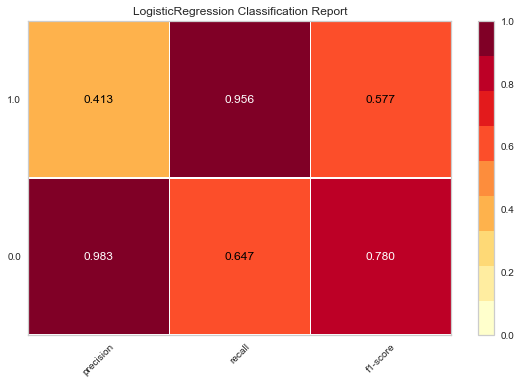

In [580]:
viz = ClassificationReport(lr)
viz.score(X_test, y_test)
viz.poof()

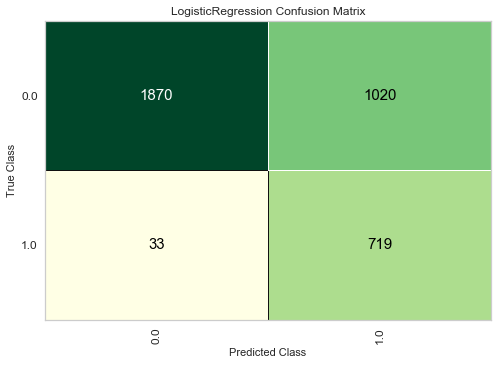

In [557]:
viz = ConfusionMatrix(lr, cmap='YlGn')
viz.score(X_test, y_test)
for label in viz.ax.texts:
    label.set_size(15)
viz.poof(outpath="cm.png")

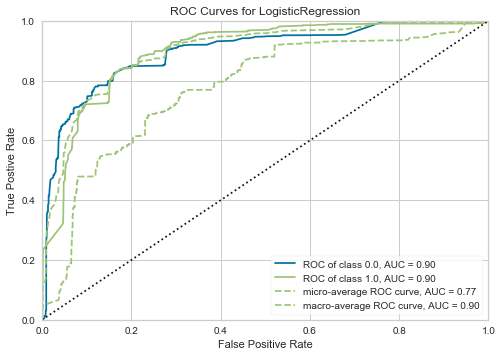

In [558]:
viz = ROCAUC(lr)
viz.score(X_test, y_test)
for label in viz.ax.texts:
    label.set_size(15)
viz.poof(outpath="roc.png")